# Testing the Infant filter

Will try to load the Infant filter and test it by parsing a tar of alerts.

In [1]:
import logging, os, requests
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logpath = '/home/jnordin/tmp/'
handler = logging.FileHandler(os.path.join(logpath, 'test_infantsnt0.log'))
logger.addHandler(handler)

First step is to load the filter, using the path specified in the `setup.py` file in the repository. 


In [2]:
from ampel.contrib.weizmann.t0.InfantFilter import InfantFilter

The full behaviour of a T0 unit is controlled by a set of parameters provided as `run_config`. We here directly specify these as a dictionary. When implemented for a live channel these constitue one entry to the `channel.json` main configuration file.

In [3]:
runConfig = {
                    "MIN_NDET": 1,
                    "MAX_NDET": 3,
                    "MIN_TSPAN": 0.02,
                    "MAX_TSPAN": 4.5,
                    "MAX_TUL": 2.5,
                    "MIN_RB": 0.3,
                    "MIN_DRB": 0.3,
                    "MIN_FWHM": 0.5,
                    "MAX_FWHM": 5.0,
                    "MAX_ELONG": 100,
                    "MAX_MAGDIFF": 0.75,
                    "MAX_NBAD": 5,
                    "MIN_SSO_DIST": 20,
                    "MIN_GAL_LAT": 14,
                    "GAIA_RS": 40,
                    "GAIA_PM_SIGNIF": 3,
                    "GAIA_PLX_SIGNIF": 3,
                    "GAIA_VETO_GMAG_MIN": 9,
                    "GAIA_VETO_GMAG_MAX": 20,
                    "GAIA_EXCESSNOISE_SIG_MAX": 999,
                    "PS1_SGVETO_RAD": 2,
                    "PS1_SGVETO_TH": 0.76,
                    "PS1_CONFUSION_RAD": 3,
                    "PS1_CONFUSION_SG_TOL": 0.1
                    }

In [4]:
# Temporarily remove gaia matching (not available)
runConfig['GAIA_RS'] = 0
# Running on old alert collections prior to DRB, so disable this
runConfig["MIN_DRB"] =  0
# There will be no transients with only one detection and a detection history. Preferred?
runConfig["MIN_TSPAN"] =  0


In [44]:
runConfig["resource"] = {"ampel-ztf/catalogmatch":"https://ampel.zeuthen.desy.de/api/catalogmatch/"}

In [45]:
runConfig_lc = {k.lower():v for k, v in runConfig.items()}

In [46]:
t0filter = InfantFilter( **runConfig_lc, logger=logger )

In [47]:
t0filter.post_init()

In [48]:
from ampel.ztf.t0.load.ZTFArchiveAlertLoader import ZTFArchiveAlertLoader
from ampel.ztf.alert.ZiAlertSupplier import ZiAlertSupplier
from ampel.alert.load.TarAlertLoader import TarAlertLoader

In [49]:
# This is the archive token which can be obtained from https://ampel.zeuthen.desy.de/live/dashboard/tokens
# In order to retrieve ZTF partnership alerts your token needs to have the appropriate access
token = os.environ["ARCHIVE_TOKEN"]   # I have mine stored
header = {"Authorization": "bearer "+token}

In [50]:
endpoint = 'https://ampel.zeuthen.desy.de/api/ztf/archive/v3/streams/from_query?programid=1'

In [51]:
# Base alert query: 
query = {
  "jd": {
#    "$gt": 2459990,
#    "$gt": 2460000,
#    "$lt": 2460100,
    "$gt": 2459980,
    "$lt": 2459990,
  },
  "candidate": {
    "drb": {
      "$gt": 0.95
    },
    "ndethist": {
      "$lt": 4,
    },
    "isdiffpos": {"$in": ["t", "1"]},
  }
}

In [21]:
response = requests.post(endpoint, headers=header, json=query )

In [22]:
if not response.ok:
    print( 'Query creation failed.')

In [23]:
# The full response contains the resume token as well as the chunk size, i.e.
# how many alerts will be return in each call to the alert iterator.
response.json()

{'resume_token': 'kMvqbxlyoPf0eO05kcF35o1-XO7RiWFu0u-c3Baowh0',
 'chunk_size': 100}

In [24]:
resume_token = response.json()['resume_token']
#resume_token = "Tqrsm-kZ1alO5sca0Neqp9EMkS3HX7aqJ2bwjH2XgO8"

In [25]:
# The loader config contains the resume_token as stream identifier
config = {'archive':"https://ampel.zeuthen.desy.de/api/ztf/archive/v3", 
          "stream":resume_token}

In [52]:
accepted_alerts = []
alertcount = 0

In [53]:
try:
    alertloader = ZTFArchiveAlertLoader(**config)
    for alert in alertloader.get_alerts():
        alertcount += 1
        print(alert['objectId'], alert['candidate']['jd'])
        filter_accept = t0filter.process( ZiAlertSupplier.shape_alert_dict( alert, [] ) )
        if filter_accept:
            accepted_alerts.append(alert)
            print('... accepted')
except requests.exceptions.HTTPError as e:
    status_code = e.response.status_code
    if status_code==423:
        print('HTTP error {}: likely caused by server staging process. Wait and try again.'.format(status_code) )
    else:
        raise e

ZTF23aabwrri 2459980.9409259
ZTF23aabwrrp 2459980.9409259
ZTF23aabwrug 2459980.9409259
ZTF23aabwrrz 2459980.9409259
ZTF23aabwrvc 2459980.9409259
ZTF23aabwrqy 2459980.9409259
ZTF23aabwrqe 2459980.9409259
ZTF23aabwrsr 2459980.9409259
ZTF23aabwrsp 2459980.9409259
ZTF23aabwrqj 2459980.9409259
ZTF23aabwrwb 2459980.9409259
ZTF23aabwrta 2459980.9409259
ZTF23aabwrsy 2459980.9409259
ZTF23aabwrsl 2459980.9409259
ZTF23aabwrsb 2459980.9409259
ZTF23aabwrtz 2459980.9409259
ZTF23aabwrqs 2459980.9409259
ZTF23aabwrsf 2459980.9409259
ZTF23aabwrrn 2459980.9409259
ZTF23aabwrvq 2459980.9409259
ZTF23aabwrvr 2459980.9409259
ZTF23aabwruw 2459980.9409259
ZTF23aabwrql 2459980.9409259
ZTF23aabwrwa 2459980.9409259
ZTF23aabwruh 2459980.9409259
ZTF23aabwrsq 2459980.9409259
ZTF23aabwrtx 2459980.9409259
ZTF23aabwrsx 2459980.9409259
ZTF23aabwrtu 2459980.9409259
ZTF23aabwrtf 2459980.9409259
ZTF23aabwruu 2459980.9409259
ZTF23aabwrst 2459980.9409259
ZTF23aabwrrq 2459980.9409259
ZTF23aabwrry 2459980.9409259
ZTF23aabwruz 2

ZTF23aabwshz 2459980.941875
ZTF23aabwsje 2459980.941875
ZTF23aabwsin 2459980.941875
ZTF23aabwsjh 2459980.941875
ZTF23aabwsil 2459980.941875
ZTF23aabwsft 2459980.941875
ZTF23aabwskd 2459980.941875
ZTF23aabwsfl 2459980.941875
ZTF23aabwsfb 2459980.941875
ZTF23aabwsju 2459980.941875
ZTF23aabwske 2459980.941875
ZTF23aabwsjl 2459980.941875
ZTF23aabwshx 2459980.941875
ZTF23aabwsfn 2459980.941875
ZTF23aabwsim 2459980.941875
ZTF23aabwsgt 2459980.941875
ZTF23aabwslc 2459980.941875
ZTF23aabwsdi 2459980.941875
ZTF23aabwsic 2459980.941875
ZTF19aavsmkg 2459980.941875
ZTF23aabwsij 2459980.941875
ZTF23aabwskp 2459980.941875
ZTF23aabwsip 2459980.941875
ZTF23aabwsfm 2459980.941875
ZTF23aabwsjd 2459980.941875
ZTF23aabwsjx 2459980.941875
ZTF23aabwsgp 2459980.941875
ZTF23aabwsfp 2459980.941875
ZTF23aabwsdy 2459980.941875
ZTF23aabwsia 2459980.941875
ZTF23aabwshu 2459980.941875
ZTF23aabwskl 2459980.941875
ZTF23aabwsii 2459980.941875
ZTF23aabwsih 2459980.941875
ZTF23aabwskf 2459980.941875
ZTF23aabwsfs 2459980

ZTF23aabwsux 2459980.942338
ZTF23aabwshf 2459980.942338
ZTF23aabwsuu 2459980.942338
ZTF23aabwssb 2459980.9428241
ZTF23aabwspc 2459980.942338
ZTF23aabwshd 2459980.942338
ZTF23aabwsma 2459980.942338
ZTF23aabwsuv 2459980.942338
ZTF23aabwsmb 2459980.942338
ZTF23aabwsph 2459980.942338
ZTF23aabwssy 2459980.9428241
ZTF23aabwsuk 2459980.9428241
ZTF23aabwsts 2459980.9428241
ZTF23aabwspb 2459980.942338
ZTF23aabwssu 2459980.9428241
ZTF23aabwshh 2459980.942338
ZTF23aabwspi 2459980.942338
ZTF23aabwspa 2459980.942338
ZTF23aabwsow 2459980.942338
ZTF23aabwstk 2459980.9428241
ZTF23aabwsoy 2459980.942338
ZTF23aabwskj 2459980.942338
ZTF23aabwsqn 2459980.942338
ZTF23aabwsqm 2459980.942338
ZTF23aabwsis 2459980.942338
ZTF23aabwsso 2459980.9428241
ZTF23aabwska 2459980.942338
ZTF23aabwsse 2459980.9428241
ZTF23aabwsss 2459980.9428241
ZTF23aabwsix 2459980.942338
ZTF23aabwsir 2459980.942338
ZTF23aabwsos 2459980.942338
ZTF23aabwshc 2459980.942338
ZTF23aabwsnt 2459980.942338
ZTF23aabwsqo 2459980.942338
ZTF23aabwsr

ZTF23aabwthu 2459980.943287
ZTF23aabwthe 2459980.9442593
ZTF23aabwtef 2459980.9442593
ZTF23aabwthh 2459980.9442593
ZTF23aabwthv 2459980.943287
ZTF23aabwtha 2459980.9442593
ZTF23aabwteb 2459980.9442593
ZTF23aabwtjd 2459980.9442593
ZTF23aabwtky 2459980.9442593
ZTF23aabwtei 2459980.9442593
ZTF23aabwtjw 2459980.9442593
ZTF23aabwtdg 2459980.943287
ZTF23aabwtel 2459980.9442593
ZTF23aabwtlb 2459980.9442593
ZTF23aabwthd 2459980.9442593
ZTF23aabwtdt 2459980.9442593
ZTF23aabwtie 2459980.9442593
ZTF23aabwtck 2459980.943287
ZTF23aabwthj 2459980.9442593
ZTF23aabwtix 2459980.9442593
ZTF23aabwtdh 2459980.943287
ZTF23aabwtkk 2459980.9442593
ZTF23aabwtem 2459980.9442593
ZTF23aabwtca 2459980.943287
ZTF23aabwtje 2459980.9442593
ZTF23aabwtcw 2459980.943287
ZTF23aabwthb 2459980.9442593
ZTF23aabwtcj 2459980.943287
ZTF23aabwtin 2459980.9442593
ZTF23aabwthx 2459980.9442593
ZTF23aabwtdx 2459980.9442593
ZTF23aabwteg 2459980.9442593
ZTF23aabwtlm 2459980.9442593
ZTF23aabwtkd 2459980.9442593
ZTF23aabwtev 2459980.9

ZTF23aabwtsn 2459980.9452083
ZTF23aabwtrt 2459980.9452083
ZTF23aabwubx 2459980.9452083
ZTF23aabwtzw 2459980.9452083
ZTF23aabwttt 2459980.9452083
ZTF23aabwtsi 2459980.9452083
ZTF23aabwtsp 2459980.9452083
ZTF23aabwtyl 2459980.9452083
ZTF23aabwtta 2459980.9452083
ZTF23aabwtzx 2459980.9452083
ZTF23aabwtwm 2459980.9452083
ZTF23aabwtuo 2459980.9452083
ZTF23aabwubh 2459980.9452083
ZTF23aabwtsy 2459980.9452083
ZTF23aabwtvk 2459980.9452083
ZTF23aabwtsl 2459980.9452083
ZTF23aabwtvi 2459980.9452083
ZTF23aabwttc 2459980.9452083
ZTF23aabwtrr 2459980.9452083
ZTF23aabwtro 2459980.9452083
ZTF23aabwtsc 2459980.9452083
ZTF23aabwtsm 2459980.9452083
ZTF23aabwtul 2459980.9452083
ZTF23aabwttx 2459980.9452083
ZTF23aabwucf 2459980.9452083
ZTF23aabwubi 2459980.9452083
ZTF19aaloooe 2459980.9452083
ZTF23aabwtwy 2459980.9452083
ZTF23aabwtwg 2459980.9452083
ZTF23aabwtvj 2459980.9452083
ZTF23aabwtsh 2459980.9452083
ZTF23aabwube 2459980.9452083
ZTF23aabwtty 2459980.9452083
ZTF23aabwtsq 2459980.9452083
ZTF23aabwtxe 2

ZTF23aabwvjb 2459981.6076505
ZTF23aabwvju 2459981.608125
ZTF23aabwvix 2459981.6076505
ZTF23aabwvjx 2459981.6071759
ZTF23aabwvhm 2459981.6071759
ZTF23aabwvkq 2459981.608125
ZTF23aabwvfx 2459981.6071759
ZTF23aabwvkn 2459981.608125
ZTF23aabwvlx 2459981.6071759
ZTF23aabwvgz 2459981.6071759
ZTF23aabwvkg 2459981.608125
ZTF23aabwvqg 2459981.6076505
ZTF23aabwvod 2459981.6076505
ZTF23aabwvkb 2459981.608125
ZTF23aabwvnx 2459981.6076505
ZTF23aabwvlv 2459981.6071759
ZTF23aabwvkh 2459981.6076505
ZTF23aabwvjh 2459981.6076505
ZTF23aabwvlt 2459981.6071759
ZTF23aabwvpc 2459981.6071759
ZTF23aabwvlw 2459981.6071759
ZTF23aabwvly 2459981.6071759
ZTF23aabwvjp 2459981.6071759
ZTF23aabwvje 2459981.6076505
ZTF23aabwvgs 2459981.6071759
ZTF23aabwvhn 2459981.6071759
ZTF23aabwvgx 2459981.6071759
ZTF23aabwvnc 2459981.6076505
ZTF23aabwvjg 2459981.6076505
ZTF23aabwvjc 2459981.6076505
ZTF23aabwvfy 2459981.6071759
ZTF23aabwvgn 2459981.6071759
ZTF23aabwvqu 2459981.6076505
ZTF23aabwvkc 2459981.6076505
ZTF23aabwvjq 245998

ZTF23aabwvxg 2459981.6100463
ZTF23aabwvug 2459981.6100463
ZTF23aabwwae 2459981.6100463
ZTF23aabwvwr 2459981.6105208
ZTF23aabwvzd 2459981.6100463
ZTF23aabwvwj 2459981.6105208
ZTF23aabwwbs 2459981.6100463
ZTF23aabwvzt 2459981.6100463
ZTF23aabwvyh 2459981.6100463
ZTF23aabwwan 2459981.6100463
ZTF23aabwvta 2459981.6105208
ZTF23aabwvxf 2459981.6100463
ZTF23aabwvxo 2459981.6100463
ZTF23aabwvvh 2459981.6105208
ZTF23aabwvya 2459981.6105208
ZTF23aabwvwz 2459981.6105208
ZTF23aabwvwp 2459981.6105208
ZTF23aabwvum 2459981.6105208
ZTF23aabwvtj 2459981.6105208
ZTF23aabwwbr 2459981.6100463
ZTF23aabwvul 2459981.6105208
ZTF23aabwwbp 2459981.6100463
ZTF23aabwwao 2459981.6100463
ZTF23aabwvti 2459981.6100463
ZTF23aabwvui 2459981.6100463
ZTF23aabwvwo 2459981.6105208
ZTF23aabwvtx 2459981.6105208
ZTF23aabwvvz 2459981.6100463
ZTF23aabwvto 2459981.6100463
ZTF23aabwvua 2459981.6105208
ZTF23aabwwak 2459981.6100463
ZTF23aabwvup 2459981.6100463
ZTF23aabwvyr 2459981.6100463
ZTF23aabwvvn 2459981.6105208
ZTF23aabwvxt 2

ZTF23aabwwri 2459981.6188657
ZTF23aabwwpw 2459981.6183912
ZTF23aabwxhe 2459981.6207639
ZTF23aabwxhf 2459981.6207639
ZTF23aabwwuk 2459981.6198264
ZTF23aabwwrr 2459981.6188657
ZTF23aabwwte 2459981.6188657
ZTF23aabwwom 2459981.6183912
ZTF23aabwwqd 2459981.6183912
ZTF23aabwwvs 2459981.6198264
ZTF23aabwwwg 2459981.6207639
ZTF23aabwwpu 2459981.6188657
ZTF23aabwwpn 2459981.6183912
ZTF23aabwwkl 2459981.6135069
ZTF23aabwwor 2459981.6183912
ZTF23aabwwpb 2459981.6183912
ZTF23aabwwsg 2459981.6188657
ZTF23aabwwpi 2459981.6188657
ZTF23aabwwqr 2459981.6188657
ZTF23aabwwpx 2459981.6183912
ZTF23aabwwqv 2459981.6193403
ZTF23aabwwvi 2459981.6198264
ZTF23aabwwsw 2459981.6198264
ZTF23aabwwnq 2459981.6183912
ZTF23aabwwnr 2459981.6183912
ZTF23aabwwoq 2459981.6183912
ZTF23aabwwmc 2459981.6135069
ZTF23aabwwvp 2459981.6202894
ZTF23aabwwpv 2459981.6183912
ZTF23aabwwok 2459981.6183912
ZTF23aabwwov 2459981.6183912
ZTF23aabwwus 2459981.6188657
ZTF23aabwwpr 2459981.6183912
ZTF23aabwwty 2459981.6193403
ZTF23aabwwoh 2

ZTF23aabwyxy 2459981.6518866
ZTF23aabwyuj 2459981.651412
ZTF23aabwyzp 2459981.6518866
ZTF23aabwyrt 2459981.651412
ZTF23aabwyvi 2459981.651412
ZTF23aabwzbi 2459981.6518866
ZTF23aabwzew 2459981.651412
ZTF23aabwyvy 2459981.651412
ZTF23aabwyuz 2459981.651412
ZTF23aabwyxs 2459981.651412
ZTF23aabwyym 2459981.6518866
ZTF23aabwyud 2459981.651412
ZTF23aabwyzw 2459981.6518866
ZTF23aabwyvg 2459981.6509375
ZTF23aabwyzm 2459981.6518866
ZTF23aabwyyj 2459981.6518866
ZTF23aabwyxm 2459981.6518866
ZTF23aabwysj 2459981.651412
ZTF23aabwytf 2459981.651412
ZTF23aabwyum 2459981.651412
ZTF23aabwyss 2459981.6509375
ZTF23aabwysi 2459981.651412
ZTF23aabwywx 2459981.6509375
ZTF23aabwyuw 2459981.651412
ZTF20acggjtu 2459981.651412
ZTF23aabwzac 2459981.6518866
ZTF23aabwyyw 2459981.6518866
ZTF23aabwytx 2459981.651412
ZTF23aabwyzo 2459981.6518866
ZTF23aabwyzf 2459981.6518866
ZTF23aabwyty 2459981.651412
ZTF23aabwysg 2459981.651412
ZTF23aabwyxn 2459981.6518866
ZTF23aabwzcp 2459981.6518866
ZTF23aabwytd 2459981.651412
ZTF

ZTF23aabxads 2459981.6775231
ZTF23aabxagg 2459981.6779977
ZTF23aabxagi 2459981.6779977
ZTF23aabxafu 2459981.6779977
ZTF23aabxafw 2459981.6779977
ZTF23aabxaeg 2459981.6775231
ZTF23aabxaer 2459981.6779977
ZTF23aabxain 2459981.6775231
ZTF23aabxafm 2459981.6779977
ZTF23aabxalq 2459981.6775231
ZTF23aabxaju 2459981.6775231
ZTF23aabxaea 2459981.6775231
ZTF23aabxalu 2459981.6775231
ZTF23aabxaky 2459981.6775231
ZTF23aabxaft 2459981.6779977
ZTF23aabxamk 2459981.6775231
ZTF23aabxaei 2459981.6779977
ZTF23aabxalt 2459981.6775231
ZTF23aabxadw 2459981.6775231
ZTF23aabxaeu 2459981.6775231
ZTF23aabwzpc 2459981.6775231
ZTF23aabxagj 2459981.6779977
ZTF23aabxajt 2459981.6775231
ZTF23aabxaeb 2459981.6775231
ZTF23aabxafl 2459981.6779977
ZTF23aabxajm 2459981.6775231
ZTF23aabxaeh 2459981.6775231
ZTF23aabxaej 2459981.6775231
ZTF23aabxakb 2459981.6775231
ZTF23aabxael 2459981.6775231
ZTF23aabxadx 2459981.6775231
ZTF23aabxajk 2459981.6775231
ZTF23aabxaei 2459981.6775231
ZTF23aabxadt 2459981.6775231
ZTF23aabxafr 2

ZTF23aabxbls 2459981.6820602
ZTF23aabxayc 2459981.6825347
ZTF23aabxbob 2459981.6820602
ZTF23aabxbsl 2459981.6820602
ZTF23aabxbnv 2459981.6820602
ZTF23aabxbql 2459981.6820602
ZTF23aabxbqz 2459981.6820602
ZTF23aabxbtj 2459981.6820602
ZTF23aabxcgl 2459981.6820602
ZTF23aabxbqh 2459981.6820602
ZTF23aabxbqf 2459981.6820602
ZTF23aabxayd 2459981.6825347
ZTF23aabxbsp 2459981.6820602
ZTF23aabxbsn 2459981.6820602
ZTF23aabxbqr 2459981.6820602
ZTF23aabxbsr 2459981.6820602
ZTF23aabxbqq 2459981.6820602
ZTF23aabxbth 2459981.6820602
ZTF23aabxbqn 2459981.6820602
ZTF23aabxbps 2459981.6820602
ZTF23aabxaya 2459981.6825347
ZTF23aabxbti 2459981.6820602
ZTF23aabxbrb 2459981.6820602
ZTF23aabxavr 2459981.6825347
ZTF23aabxavp 2459981.6825347
ZTF23aabxceo 2459981.6820602
ZTF23aabxaut 2459981.6825347
ZTF23aabxbqw 2459981.6820602
ZTF23aabxcdr 2459981.6820602
ZTF23aabxaxw 2459981.6825347
ZTF23aabxauu 2459981.6825347
ZTF23aabxbqt 2459981.6820602
ZTF23aabxbna 2459981.6820602
ZTF23aabxblp 2459981.6820602
ZTF23aabxblh 2

ZTF23aabxcia 2459981.6834954
ZTF23aabxbzb 2459981.6834954
ZTF23aabxbwp 2459981.6834954
ZTF23aabxcju 2459981.6834954
ZTF23aabxcfi 2459981.6834954
ZTF23aabxcfp 2459981.6834954
ZTF23aabxcqc 2459981.6830093
ZTF23aabxbxv 2459981.6834954
ZTF23aabxbwd 2459981.6834954
ZTF23aabxbzc 2459981.6834954
ZTF23aabxcew 2459981.6834954
ZTF23aabxcip 2459981.6834954
ZTF23aabxcjk 2459981.6834954
ZTF23aabxcef 2459981.6834954
ZTF23aabxcbe 2459981.6834954
ZTF23aabxcqe 2459981.6830093
ZTF23aabxcej 2459981.6834954
ZTF23aabxcdb 2459981.6834954
ZTF23aabxckh 2459981.6834954
ZTF23aabxbwg 2459981.6834954
ZTF23aabxbtq 2459981.6834954
ZTF23aabxcoe 2459981.6830093
ZTF23aabxcjq 2459981.6834954
ZTF23aabxcfq 2459981.6834954
ZTF23aabxcfa 2459981.6834954
ZTF23aabxcjs 2459981.6834954
ZTF23aabxcbo 2459981.6834954
ZTF23aabxchj 2459981.6834954
ZTF23aabxbxr 2459981.6834954
ZTF23aabxcjl 2459981.6834954
ZTF23aabxcjf 2459981.6834954
ZTF23aabxbzu 2459981.6834954
ZTF23aabxbxu 2459981.6834954
ZTF23aabxbzi 2459981.6834954
ZTF23aabxcjo 2

ZTF23aabxcns 2459981.6839583
ZTF23aabxcpz 2459981.6850926
ZTF23aabxcyg 2459981.690162
ZTF23aabwxqa 2459981.6896991
ZTF23aabxcnx 2459981.6839583
ZTF23aabxcnl 2459981.6839583
ZTF23aabxcyw 2459981.690162
ZTF23aabxckg 2459981.6844907
ZTF23aabxczu 2459981.690162
ZTF23aabxcny 2459981.6839583
ZTF23aabxddb 2459981.6906366
ZTF23aabxcyr 2459981.690162
ZTF23aabxcyf 2459981.6896991
ZTF23aabxcnn 2459981.6839583
ZTF23aabxcuz 2459981.6850926
ZTF23aabxcyn 2459981.6892245
ZTF23aabxcnv 2459981.6839583
ZTF23aabxcnp 2459981.6839583
ZTF23aabxcps 2459981.6839583
ZTF23aabxcyz 2459981.690162
ZTF23aabxcpu 2459981.6839583
ZTF23aabxcnt 2459981.6839583
ZTF23aabxdar 2459981.690162
ZTF23aabxcxq 2459981.6892245
ZTF23aabxcpx 2459981.6839583
ZTF23aabxcno 2459981.6839583
ZTF23aabxclk 2459981.6844907
ZTF23aabxdbv 2459981.690162
ZTF23aabxcoj 2459981.6844907
ZTF23aabxdaj 2459981.690162
ZTF23aabxdch 2459981.690162
ZTF23aabxdbh 2459981.690162
ZTF23aabxcxn 2459981.6896991
ZTF23aabxcme 2459981.6844907
ZTF23aabxdjg 2459981.690

ZTF23aabxdia 2459981.6915741
ZTF23aabxdkb 2459981.6915741
ZTF23aabxdqr 2459981.6915741
ZTF23aabxdnr 2459981.6915741
ZTF23aabxdli 2459981.6915741
ZTF23aabxdgh 2459981.6915741
ZTF23aabxdfo 2459981.6915741
ZTF23aabxdmx 2459981.6915741
ZTF23aabxdlh 2459981.6915741
ZTF23aabxdjz 2459981.6915741
ZTF23aabxdnw 2459981.6915741
ZTF23aabxdns 2459981.6915741
ZTF23aabxdmy 2459981.6915741
ZTF23aabxdlm 2459981.6915741
ZTF23aabxdea 2459981.6915741
ZTF23aabxdoy 2459981.6915741
ZTF23aabxdkv 2459981.6915741
ZTF23aabxdpq 2459981.6915741
ZTF23aabxdge 2459981.6915741
ZTF23aabxdpa 2459981.6915741
ZTF23aabxdgf 2459981.6915741
ZTF23aabxdpe 2459981.6915741
ZTF23aabxddu 2459981.6915741
ZTF23aabxdqw 2459981.6915741
ZTF23aabxdks 2459981.6915741
ZTF23aabxdpb 2459981.6915741
ZTF23aabxdnh 2459981.6915741
ZTF23aabxdib 2459981.6915741
ZTF23aabxdqn 2459981.6915741
ZTF23aabxdkc 2459981.6915741
ZTF23aabxdje 2459981.6915741
ZTF23aabxdjb 2459981.6915741
ZTF23aabxdif 2459981.6915741
ZTF23aabxdfl 2459981.6915741
ZTF23aabxddv 2

ZTF23aabxdmi 2459981.6925231
ZTF23aabxdvu 2459981.6925231
ZTF23aabxdqk 2459981.6925231
ZTF23aabxdox 2459981.6925231
ZTF23aabxdmm 2459981.6925231
ZTF23aabxdit 2459981.6925231
ZTF23aabxdlr 2459981.6925231
ZTF23aabxdsd 2459981.6925231
ZTF23aabxdql 2459981.6925231
ZTF23aabxdnx 2459981.6925231
ZTF23aabxdhf 2459981.6925231
ZTF23aabxdis 2459981.6925231
ZTF23aabxdhg 2459981.6925231
ZTF23aabxdxr 2459981.6925231
ZTF23aabxdze 2459981.6925231
ZTF23aabxdzk 2459981.6925231
ZTF23aabxdzt 2459981.6925231
ZTF23aabxdwu 2459981.6925231
ZTF23aabxdny 2459981.6925231
ZTF23aabxdxh 2459981.6925231
ZTF23aabxdvt 2459981.6925231
ZTF23aabxduw 2459981.6925231
ZTF23aabxdyj 2459981.6925231
ZTF23aabxdrf 2459981.6925231
ZTF23aabxdwp 2459981.6925231
ZTF23aabxdzv 2459981.6925231
ZTF23aabxdry 2459981.6925231
ZTF23aabxdwg 2459981.6925231
ZTF23aabxdvs 2459981.6925231
ZTF23aabxdqm 2459981.6925231
ZTF23aabxdzs 2459981.6925231
ZTF23aabxdup 2459981.6925231
ZTF23aabxdvv 2459981.6925231
ZTF23aabxdxj 2459981.6925231
ZTF23aabxdhe 2

ZTF23aabxefs 2459981.6934606
ZTF23aabxeaa 2459981.6934606
ZTF23aabxeku 2459981.6954514
ZTF23aabxehy 2459981.6934606
ZTF23aabxefo 2459981.6934606
ZTF23aabxdwn 2459981.6934606
ZTF23aabxeki 2459981.6954514
ZTF23aabxdxk 2459981.6934606
ZTF23aabxdtk 2459981.6934606
ZTF19aaexmcq 2459981.6934606
ZTF23aabxedd 2459981.6934606
ZTF23aabxdtl 2459981.6934606
ZTF23aabxelv 2459981.6934606
ZTF23aabxeih 2459981.6934606
ZTF23aabxehp 2459981.6934606
ZTF23aabxdul 2459981.6934606
ZTF23aabxela 2459981.6934606
ZTF23aabxegy 2459981.6954514
ZTF23aabxdyr 2459981.6934606
ZTF23aabxeaj 2459981.6934606
ZTF23aabxecs 2459981.6934606
ZTF23aabxelx 2459981.6934606
ZTF23aabxedf 2459981.6934606
ZTF23aabxekb 2459981.6954514
ZTF23aabxdwk 2459981.6934606
ZTF23aabxeib 2459981.6954514
ZTF23aabxedg 2459981.6934606
ZTF23aabxdxm 2459981.6934606
ZTF23aabxdwo 2459981.6934606
ZTF23aabxdxl 2459981.6934606
ZTF23aabxemw 2459981.6934606
ZTF23aabxena 2459981.6954514
ZTF23aabxefp 2459981.6934606
ZTF23aabxegh 2459981.6934606
ZTF23aabxegi 2

ZTF23aabxgto 2459982.6112269
ZTF23aabxfob 2459982.6098148
ZTF23aabxhce 2459982.6112269
ZTF23aabxfok 2459982.6112269
ZTF23aabxfnj 2459982.6098148
ZTF23aabxfpo 2459982.6117014
ZTF23aabxfod 2459982.6098148
ZTF23aabxhaw 2459982.6112269
ZTF23aabxgty 2459982.6131134
ZTF23aabxfnh 2459982.6098148
ZTF23aabxfpq 2459982.6112269
ZTF23aabxfqs 2459982.613588
ZTF23aabxfsa 2459982.6131134
ZTF23aabxgzn 2459982.6131134
ZTF23aabxifi 2459982.6117014
ZTF23aabxheo 2459982.6107523
ZTF23aabxfqt 2459982.613588
... accepted
ZTF23aabxfst 2459982.613588
ZTF23aabxfsk 2459982.613588
ZTF23aabxfnq 2459982.6098148
ZTF23aabxhcb 2459982.6112269
ZTF23aabxfnl 2459982.6098148
ZTF23aabxfon 2459982.6112269
ZTF23aabxfpm 2459982.6117014
ZTF23aabxfoe 2459982.6112269
ZTF23aabxfnu 2459982.6098148
ZTF23aabxiaz 2459982.6112269
ZTF23aabxfoo 2459982.6121644
ZTF23aabxfnz 2459982.6098148
ZTF23aabxflr 2459982.6102778
ZTF23aabxfnk 2459982.6098148
ZTF23aabxhca 2459982.6112269
ZTF23aabxfom 2459982.6107523
ZTF23aabxfqq 2459982.613588
ZTF23a

ZTF23aabxfyy 2459982.6173727
ZTF23aabxfxq 2459982.6173727
ZTF23aabxhcn 2459982.6168981
ZTF23aabxfyo 2459982.6173727
ZTF23aabxfzr 2459982.6173727
ZTF23aabxhcq 2459982.6168981
ZTF23aabxfyq 2459982.6173727
ZTF23aabxgcl 2459982.6168981
ZTF23aabxgbm 2459982.6168981
ZTF23aabximw 2459982.6168981
ZTF23aabxfwz 2459982.6173727
ZTF23aabximx 2459982.6168981
ZTF23aabxfxx 2459982.6168981
ZTF23aabxfwm 2459982.6173727
ZTF23aabxfwp 2459982.6173727
ZTF23aabxgym 2459982.6168981
ZTF23aabxgcn 2459982.6168981
ZTF23aabxgbd 2459982.6173727
ZTF23aabxfzq 2459982.6173727
ZTF23aabxgae 2459982.6168981
ZTF23aabxgbj 2459982.6173727
ZTF23aabxgbn 2459982.6173727
ZTF23aabxfwn 2459982.6173727
ZTF23aabxfzb 2459982.6173727
ZTF23aabxfxs 2459982.6173727
ZTF23aabxfzs 2459982.6168981
ZTF23aabxfyf 2459982.6168981
ZTF23aabxfzj 2459982.6173727
ZTF23aabxfxv 2459982.6173727
ZTF23aabxfxk 2459982.6173727
ZTF23aabxfzp 2459982.6173727
ZTF23aabxhrg 2459982.6168981
ZTF23aabxgaa 2459982.6168981
ZTF23aabxfxe 2459982.6168981
ZTF23aabxfyv 2

ZTF23aabxgji 2459982.6192593
ZTF23aabxglz 2459982.6192593
ZTF23aabxibm 2459982.6192593
ZTF23aabxggj 2459982.6192593
ZTF19ablpssv 2459982.6192593
ZTF23aabxggi 2459982.6192593
ZTF23aabxgfu 2459982.6192593
ZTF23aabxgjd 2459982.6192593
ZTF23aabxhcw 2459982.6187847
ZTF23aabxgne 2459982.6192593
ZTF23aabxggg 2459982.6192593
ZTF23aabxgkb 2459982.6192593
ZTF23aabxhzk 2459982.6187847
ZTF23aabxgio 2459982.6192593
ZTF23aabxghj 2459982.6192593
ZTF23aabxgmb 2459982.6192593
ZTF23aabxghk 2459982.6192593
ZTF23aabxgkp 2459982.6192593
ZTF23aabxibd 2459982.6192593
ZTF23aabxglv 2459982.6192593
ZTF23aabxglt 2459982.6192593
ZTF23aabxibq 2459982.6187847
ZTF23aabxgmd 2459982.6192593
ZTF23aabxgkx 2459982.6192593
ZTF23aabxgiw 2459982.6192593
ZTF23aabxghw 2459982.6192593
ZTF23aabxgjc 2459982.6192593
ZTF23aabxgjn 2459982.6192593
ZTF23aabxggp 2459982.6192593
ZTF23aabxggs 2459982.6192593
ZTF23aabxgjj 2459982.6192593
ZTF23aabxhzo 2459982.6192593
ZTF23aabxgqo 2459982.6192593
ZTF23aabxhhw 2459982.6192593
ZTF23aabxgjm 2

ZTF23aabxhfn 2459982.63625
ZTF23aabxhfi 2459982.63625
ZTF23aabxipl 2459982.63625
ZTF23aabxhih 2459982.636713
ZTF23aabxivx 2459982.63625
ZTF23aabxhjm 2459982.63625
ZTF23aabxhvp 2459982.63625
ZTF23aabxhqu 2459982.63625
ZTF23aabxhez 2459982.63625
ZTF23aabxixj 2459982.63625
ZTF23aabxhet 2459982.63625
ZTF23aabxiqy 2459982.6321759
ZTF23aabxhff 2459982.63625
ZTF23aabxhii 2459982.636713
ZTF23aabxhia 2459982.636713
ZTF23aabxhhz 2459982.63625
ZTF23aabxhep 2459982.63625
ZTF23aabxhhy 2459982.63625
ZTF23aabxhee 2459982.63625
ZTF23aabxhin 2459982.636713
ZTF23aabxhjr 2459982.63625
ZTF23aabxhfd 2459982.63625
ZTF23aabxhfc 2459982.63625
ZTF23aabxhvq 2459982.63625
ZTF23aabxhef 2459982.63625
ZTF23aabxige 2459982.6321759
ZTF23aabxite 2459982.63625
ZTF23aabxhgx 2459982.63625
ZTF23aabxhim 2459982.636713
ZTF23aabxjan 2459982.63625
ZTF23aabxhea 2459982.63625
ZTF23aabxhhi 2459982.636713
ZTF23aabxhev 2459982.63625
ZTF23aabxhfr 2459982.63625
ZTF23aabxitd 2459982.63625
ZTF23aabxhfm 2459982.63625
ZTF23aabxhfs 24599

ZTF23aabxhqa 2459982.6371875
ZTF23aabxhnm 2459982.6371875
ZTF23aabxhsg 2459982.6371875
ZTF23aabxhou 2459982.6371875
ZTF23aabxhrq 2459982.6371875
ZTF23aabxhlw 2459982.6371875
ZTF23aabxhlz 2459982.6371875
ZTF23aabxhqi 2459982.6371875
ZTF23aabxhlu 2459982.6371875
ZTF23aabxhry 2459982.6371875
ZTF23aabxhqh 2459982.6371875
ZTF23aabxhnl 2459982.6371875
ZTF23aabxhqd 2459982.6371875
ZTF23aabxhpj 2459982.6371875
ZTF23aabxhqw 2459982.6371875
ZTF23aabxhov 2459982.6371875
ZTF23aabxhrs 2459982.6371875
ZTF23aabxhmr 2459982.6371875
ZTF23aabxhmp 2459982.6371875
ZTF23aabxhpv 2459982.6371875
ZTF23aabxhpi 2459982.6371875
ZTF23aabxhoy 2459982.6371875
ZTF23aabxhrx 2459982.6371875
ZTF23aabxhqg 2459982.6371875
ZTF23aabxhoh 2459982.6371875
ZTF23aabxhqf 2459982.6371875
ZTF23aabxhpn 2459982.6371875
ZTF23aabxhmo 2459982.6371875
ZTF23aabxhkw 2459982.6371875
ZTF23aabxhot 2459982.6371875
ZTF23aabxhql 2459982.6371875
ZTF23aabxhox 2459982.6371875
ZTF23aabxhpo 2459982.6371875
ZTF23aabxhrl 2459982.6371875
ZTF23aabxhos 2

ZTF23aabxiej 2459982.6426736
ZTF23aabxiez 2459982.6426736
ZTF23aabxinf 2459982.6421991
ZTF23aabxilh 2459982.6421991
ZTF23aabxiqq 2459982.6421991
ZTF23aabxilq 2459982.6421991
ZTF23aabxihj 2459982.6421991
ZTF23aabxiho 2459982.6421991
ZTF23aabximk 2459982.6421991
ZTF23aabxilp 2459982.6421991
ZTF23aabxiiy 2459982.6421991
ZTF23aabxikz 2459982.6421991
ZTF23aabxilk 2459982.6421991
ZTF23aabxigb 2459982.6426736
ZTF23aabxiev 2459982.6426736
ZTF23aabxijm 2459982.6421991
ZTF23aabxije 2459982.6421991
ZTF23aabxidu 2459982.6426736
ZTF23aabxijo 2459982.6421991
ZTF23aabxijn 2459982.6421991
ZTF23aabxieg 2459982.6426736
ZTF23aabxjxt 2459982.6421991
ZTF23aabximj 2459982.6421991
ZTF23aabxijx 2459982.6421991
ZTF23aabxifp 2459982.6426736
ZTF23aabxifj 2459982.6426736
ZTF23aabximg 2459982.6421991
ZTF23aabxija 2459982.6421991
ZTF23aabxihg 2459982.6421991
ZTF23aabxigv 2459982.6421991
ZTF23aabxiih 2459982.6421991
ZTF23aabxifg 2459982.6426736
ZTF23aabxijb 2459982.6421991
ZTF23aabxijk 2459982.6421991
ZTF23aabxiji 2

ZTF23aabxjzz 2459982.6622454
ZTF23aabxjyr 2459982.6622454
ZTF23aabxjwv 2459982.6617477
ZTF23aabxjyn 2459982.6622454
ZTF23aabxjya 2459982.6622454
ZTF23aabxjyt 2459982.6622454
ZTF23aabxjyg 2459982.6617477
ZTF23aabxjwk 2459982.6617477
ZTF23aabxjwj 2459982.6612731
ZTF23aabxjxx 2459982.6622454
ZTF23aabxjza 2459982.6622454
ZTF23aabxjws 2459982.6617477
ZTF23aabxjwn 2459982.6617477
ZTF23aabxjwu 2459982.6617477
ZTF23aabxjyv 2459982.6622454
ZTF23aabxjwm 2459982.6617477
ZTF23aabxjwh 2459982.6612731
ZTF23aabxjwq 2459982.6617477
ZTF23aabxjwi 2459982.6612731
ZTF23aabxjzv 2459982.6622454
ZTF23aabxjxr 2459982.6617477
ZTF23aabxjyo 2459982.6622454
ZTF23aabxjxb 2459982.6617477
ZTF23aabxjww 2459982.6617477
ZTF23aabxjxz 2459982.6622454
ZTF23aabxjzu 2459982.6622454
ZTF23aabxkor 2459982.6617477
ZTF23aabxjzs 2459982.6617477
ZTF23aabxjxi 2459982.6617477
ZTF23aabxjxj 2459982.6617477
ZTF23aabxjsk 2459982.6612731
ZTF23aabxjym 2459982.6622454
ZTF23aabxjzx 2459982.6622454
ZTF23aabxjzt 2459982.6617477
ZTF23aabxkve 2

ZTF23aabxlhn 2459982.6781134
ZTF23aabxlyr 2459982.6776389
ZTF23aabxlks 2459982.6776389
ZTF23aabxlge 2459982.6776389
ZTF23aabxlst 2459982.6776389
ZTF23aabxlnf 2459982.6776389
ZTF23aabxlmn 2459982.6776389
ZTF23aabxlgp 2459982.6776389
ZTF23aabxlgf 2459982.6776389
ZTF23aabxlot 2459982.6776389
ZTF23aabxlhj 2459982.6776389
ZTF23aabxlrr 2459982.6771644
ZTF23aabxliz 2459982.6776389
ZTF23aabxlhb 2459982.6776389
ZTF23aabxlua 2459982.6776389
ZTF23aabxmby 2459982.6771644
ZTF23aabxlis 2459982.6776389
ZTF23aabxlha 2459982.6776389
ZTF23aabxliw 2459982.6781134
ZTF22abgfxlr 2459982.6776389
ZTF23aabxlzc 2459982.6776389
ZTF23aabxlrm 2459982.6771644
ZTF23aabxlgc 2459982.6776389
ZTF23aabxlxm 2459982.6776389
ZTF23aabxlsn 2459982.6771644
ZTF23aabxlwk 2459982.6776389
ZTF23aabxlon 2459982.6781134
ZTF23aabxlnb 2459982.6781134
ZTF23aabxlsv 2459982.6776389
ZTF23aabxlrp 2459982.6771644
ZTF23aabxlhk 2459982.6776389
ZTF23aabxlip 2459982.6776389
ZTF23aabxlgi 2459982.6781134
ZTF23aabxlrg 2459982.6776389
ZTF23aabxlfd 2

ZTF23aabxqxf 2459982.7373032
ZTF23aabxrdk 2459982.7373032
ZTF23aabxrhz 2459982.7373032
ZTF23aabxrlt 2459982.7373032
ZTF23aabxqny 2459982.7368287
ZTF23aabxqnz 2459982.7368287
ZTF20aczdlsf 2459982.7322801
ZTF23aabxqea 2459982.7373032
ZTF23aabxpwz 2459982.7363542
ZTF23aabxrpg 2459982.7363542
ZTF19acvdhtv 2459982.7318056
ZTF23aabxrul 2459982.7373032
ZTF23aabxrcd 2459982.7368287
ZTF23aabxrrf 2459982.7373032
ZTF23aabxrqx 2459982.7373032
ZTF23aabxrnn 2459982.7373032
ZTF23aabxrea 2459982.7373032
ZTF23aabxpvh 2459982.7318056
ZTF23aabxqiz 2459982.7378125
ZTF23aabxrhx 2459982.7373032
ZTF20adgrnow 2459982.7322801
ZTF23aabxpka 2459982.7318056
ZTF23aabxpje 2459982.7322801
ZTF23aabxrnm 2459982.7373032
ZTF23aabxprx 2459982.7322801
ZTF23aabxpqo 2459982.7318056
ZTF23aabxrme 2459982.7373032
ZTF23aabxqsq 2459982.7373032
ZTF23aabxqpy 2459982.7368287
ZTF23aabxpra 2459982.7318056
ZTF23aabxqfq 2459982.7378125
ZTF23aabxqmg 2459982.7373032
ZTF23aabxqqa 2459982.7373032
ZTF23aabxqbi 2459982.7363542
ZTF23aabxrql 2

ZTF23aabxqas 2459982.7382755
ZTF23aabxrxk 2459982.7378125
ZTF23aabxqcm 2459982.7382755
ZTF23aabxruz 2459982.7378125
ZTF23aabxqdb 2459982.7382755
ZTF23aabxrzr 2459982.7378125
ZTF23aabxqff 2459982.7382755
ZTF23aabxqcz 2459982.7382755
ZTF23aabxqfc 2459982.7382755
ZTF23aabxqar 2459982.7382755
ZTF23aabxqhh 2459982.7382755
ZTF23aabxqcl 2459982.7382755
ZTF23aabxqhn 2459982.7382755
ZTF23aabxqbb 2459982.7382755
ZTF23aabxqds 2459982.7382755
ZTF23aabxqcx 2459982.7382755
ZTF23aabxqfi 2459982.7382755
ZTF23aabxqfw 2459982.7382755
ZTF23aabxqeo 2459982.7382755
ZTF23aabxqfa 2459982.7382755
ZTF23aabxqcw 2459982.7382755
ZTF23aabxqfy 2459982.7382755
ZTF23aabxqgc 2459982.7382755
ZTF23aabxqdv 2459982.7382755
ZTF23aabxqcj 2459982.7382755
ZTF23aabxqen 2459982.7382755
ZTF23aabxqfb 2459982.7382755
ZTF23aabxqhz 2459982.7382755
ZTF23aabxqev 2459982.7382755
ZTF23aabxrva 2459982.7378125
ZTF23aabxqem 2459982.7382755
ZTF23aabxqfj 2459982.7382755
ZTF23aabxqex 2459982.7382755
ZTF23aabxrzo 2459982.7378125
ZTF23aabxqcr 2

ZTF23aabxrqe 2459982.7387616
ZTF23aabxrpn 2459982.7387616
ZTF23aabxrgf 2459982.7387616
ZTF23aabxrez 2459982.7387616
ZTF23aabxqyn 2459982.7387616
ZTF23aabxrqb 2459982.7387616
ZTF23aabxrlm 2459982.7387616
ZTF23aabxrpl 2459982.7387616
ZTF23aabxrkd 2459982.7387616
ZTF23aabxrkm 2459982.7387616
ZTF23aabxqyp 2459982.7387616
ZTF23aabxrdn 2459982.7387616
ZTF23aabxrck 2459982.7387616
ZTF23aabxrcn 2459982.7387616
ZTF23aabxrni 2459982.7387616
ZTF23aabxrlc 2459982.7387616
ZTF23aabxqyg 2459982.7387616
ZTF23aabxrnc 2459982.7387616
ZTF23aabxred 2459982.7387616
ZTF23aabxrld 2459982.7387616
ZTF23aabxrgd 2459982.7387616
ZTF23aabxras 2459982.7387616
ZTF23aabxrna 2459982.7387616
ZTF23aabxrkj 2459982.7387616
ZTF23aabxrge 2459982.7387616
ZTF23aabxrap 2459982.7387616
ZTF23aabxrdm 2459982.7387616
ZTF23aabxrlr 2459982.7387616
ZTF23aabxrkb 2459982.7387616
ZTF23aabxrne 2459982.7387616
ZTF23aabxrdr 2459982.7387616
ZTF20aapkvez 2459982.7387616
ZTF23aabxrlp 2459982.7387616
ZTF23aabxrcm 2459982.7387616
ZTF23aabxrav 2

ZTF23aabxtgz 2459982.7579861
ZTF23aabxtga 2459982.7579861
ZTF23aabxthf 2459982.7579861
ZTF23aabxtlh 2459982.7579861
ZTF23aabxtif 2459982.7579861
ZTF23aabxtgy 2459982.7579861
ZTF23aabxtij 2459982.7584491
ZTF23aabxthj 2459982.7579861
ZTF23aabxuey 2459982.7579861
ZTF23aabxtgt 2459982.7579861
ZTF23aabxuny 2459982.7579861
ZTF23aabxtml 2459982.7579861
ZTF23aabxuca 2459982.7584491
ZTF23aabxtic 2459982.7579861
ZTF23aabxtgf 2459982.7579861
ZTF23aabxunw 2459982.7579861
ZTF23aabxtfs 2459982.7579861
ZTF23aabxuok 2459982.7579861
ZTF23aabxtpl 2459982.7579861
ZTF23aabxtie 2459982.7579861
ZTF23aabxunz 2459982.7579861
ZTF23aabxtgi 2459982.7579861
ZTF23aabxuel 2459982.7579861
ZTF23aabxtgw 2459982.7579861
ZTF23aabxtvi 2459982.7579861
ZTF23aabxtph 2459982.7579861
ZTF23aabxtpi 2459982.7579861
ZTF23aabxtlj 2459982.7579861
ZTF23aabxtfq 2459982.7579861
ZTF23aabxuep 2459982.7579861
ZTF23aabxtpk 2459982.7579861
ZTF23aabxtqx 2459982.7579861
ZTF23aabxtik 2459982.7584491
ZTF23aabxtmw 2459982.7579861
ZTF23aabxtgl 2

ZTF23aabxujv 2459982.7584491
ZTF23aabxuqq 2459982.7584491
ZTF23aabxuvp 2459982.7584491
ZTF23aabxura 2459982.7584491
ZTF23aabxuvn 2459982.7584491
ZTF23aabxurb 2459982.7584491
ZTF23aabxtln 2459982.7589583
ZTF23aabxuli 2459982.7584491
ZTF23aabxukg 2459982.7584491
ZTF23aabxunb 2459982.7584491
ZTF23aabxukf 2459982.7584491
ZTF23aabxumw 2459982.7584491
ZTF23aabxupi 2459982.7584491
ZTF23aabxukx 2459982.7584491
ZTF23aabxuqm 2459982.7584491
ZTF23aabxuky 2459982.7584491
ZTF23aabxuud 2459982.7584491
ZTF23aabxuuf 2459982.7584491
ZTF23aabxuqn 2459982.7584491
ZTF23aabxuqz 2459982.7584491
ZTF23aabxuio 2459982.7584491
ZTF23aabxulf 2459982.7584491
ZTF23aabxukh 2459982.7584491
ZTF23aabxupl 2459982.7584491
ZTF23aabxukm 2459982.7584491
ZTF23aabxurf 2459982.7584491
ZTF23aabxuju 2459982.7584491
ZTF23aabxukv 2459982.7584491
ZTF23aabxuki 2459982.7584491
ZTF23aabxukw 2459982.7584491
ZTF23aabxupw 2459982.7584491
ZTF23aabxuqs 2459982.7584491
ZTF23aabxula 2459982.7584491
ZTF23aabxujw 2459982.7584491
ZTF23aabxulc 2

ZTF23aabxubn 2459982.7603704
ZTF23aabxurq 2459982.7598958
ZTF23aabxumm 2459982.7598958
ZTF23aabxupc 2459982.7594329
ZTF23aabxuoc 2459982.7594329
ZTF23aabxtpx 2459982.7598958
ZTF23aabxtzn 2459982.7603704
ZTF23aabxumo 2459982.7598958
ZTF23aabxugx 2459982.7598958
ZTF23aabxuej 2459982.7598958
ZTF23aabxueg 2459982.7603704
ZTF23aabxudj 2459982.7598958
ZTF23aabxuaz 2459982.7598958
ZTF23aabxugl 2459982.7598958
ZTF23aabxupe 2459982.7598958
ZTF23aabxudi 2459982.7598958
ZTF23aabxuoi 2459982.7594329
ZTF23aabxtlo 2459982.7598958
ZTF23aabxugu 2459982.7598958
ZTF23aabxubj 2459982.7598958
ZTF23aabxucl 2459982.7603704
ZTF23aabxuga 2459982.7598958
ZTF23aabxujk 2459982.7594329
ZTF23aabxupx 2459982.7598958
ZTF23aabxube 2459982.7598958
ZTF23aabxuai 2459982.7603704
ZTF23aabxunm 2459982.7594329
ZTF23aabxulm 2459982.7598958
ZTF23aabxuto 2459982.7598958
ZTF23aabxuin 2459982.7598958
ZTF23aabxukz 2459982.7598958
ZTF23aabxuax 2459982.7598958
ZTF23aabxuft 2459982.7598958
ZTF23aabxuoh 2459982.7594329
ZTF23aabxudg 2

ZTF23aabxxeg 2459983.6061806
ZTF23aabxxhh 2459983.6061806
ZTF23aabxxbk 2459983.6061806
ZTF23aabxxfp 2459983.6061806
ZTF23aabxxgc 2459983.6061806
ZTF23aabxxck 2459983.6061806
ZTF23aabxxbl 2459983.6061806
ZTF23aabxxcc 2459983.6061806
ZTF23aabxxhd 2459983.6061806
ZTF23aabxxan 2459983.6061806
ZTF23aabxwwi 2459983.6061806
ZTF23aabxwzb 2459983.6061806
ZTF23aabxxdh 2459983.6061806
ZTF23aabxwvl 2459983.6061806
ZTF23aabxxib 2459983.6061806
ZTF23aabxxgi 2459983.6061806
ZTF23aabxxao 2459983.6061806
ZTF23aabxwyt 2459983.6061806
ZTF23aabxxbj 2459983.6061806
ZTF23aabxxaj 2459983.6061806
ZTF23aabxxbh 2459983.6061806
ZTF23aabxxda 2459983.6061806
ZTF23aabxxbu 2459983.6061806
ZTF23aabxxhz 2459983.6061806
ZTF23aabxxig 2459983.6061806
ZTF23aabxxga 2459983.6061806
ZTF23aabxxgb 2459983.6061806
ZTF23aabxxed 2459983.6061806
ZTF23aabxwwm 2459983.6061806
ZTF23aabxwwj 2459983.6061806
ZTF23aabxxae 2459983.6061806
ZTF23aabxxbg 2459983.6061806
ZTF23aabxwyq 2459983.6061806
ZTF23aabxxcz 2459983.6061806
ZTF23aabxxbt 2

ZTF23aabxxtx 2459983.6071412
ZTF23aabxxpu 2459983.6071412
ZTF23aabxxor 2459983.6071412
ZTF23aabxxiu 2459983.6071412
ZTF23aabxxud 2459983.6071412
ZTF23aabxxsq 2459983.6071412
ZTF23aabxxpa 2459983.6071412
ZTF23aabxxqo 2459983.6071412
ZTF23aabxxry 2459983.6071412
ZTF23aabxxma 2459983.6071412
ZTF23aabxxrb 2459983.6071412
ZTF23aabxxnn 2459983.6071412
ZTF23aabxxpq 2459983.6071412
ZTF23aabxxnd 2459983.6071412
ZTF23aabxxov 2459983.6071412
ZTF23aabxxsa 2459983.6071412
ZTF23aabxxoz 2459983.6071412
ZTF23aabxxko 2459983.6071412
ZTF23aabxxmc 2459983.6071412
ZTF23aabxxpp 2459983.6071412
ZTF23aabxxhn 2459983.6071412
ZTF23aabxxbk 2459983.6071412
ZTF23aabxxuo 2459983.6071412
ZTF23aabxxlw 2459983.6071412
ZTF23aabxxql 2459983.6071412
ZTF23aabxxpl 2459983.6071412
ZTF23aabxxna 2459983.6071412
ZTF23aabxxuu 2459983.6071412
ZTF23aabxxou 2459983.6071412
ZTF23aabxxmk 2459983.6071412
ZTF23aabxxpm 2459983.6071412
ZTF23aabxxqy 2459983.6071412
ZTF23aabxxmi 2459983.6071412
ZTF23aabxxis 2459983.6071412
ZTF23aabxxqz 2

ZTF23aabxyig 2459983.6076157
ZTF23aabxymt 2459983.6076157
ZTF23aabxzhn 2459983.6076157
ZTF23aabxyov 2459983.6076157
ZTF23aabxysw 2459983.6076157
ZTF23aabxyrp 2459983.6076157
ZTF23aabxzcv 2459983.6076157
ZTF23aabxyxl 2459983.6076157
ZTF23aabxyzt 2459983.6076157
ZTF23aabxzfw 2459983.6076157
ZTF23aabxzcs 2459983.6076157
ZTF23aabxyos 2459983.6076157
ZTF23aabxyon 2459983.6076157
ZTF23aabxytx 2459983.6076157
ZTF23aabxzfx 2459983.6076157
ZTF23aabxyjx 2459983.6076157
ZTF23aabxyzr 2459983.6076157
ZTF23aabxyts 2459983.6076157
ZTF23aabxysq 2459983.6076157
ZTF23aabxyzz 2459983.6076157
ZTF23aabxzag 2459983.6076157
ZTF23aabxyxm 2459983.6076157
ZTF23aabxzft 2459983.6076157
ZTF23aabxzcx 2459983.6076157
ZTF23aabxyss 2459983.6076157
ZTF23aabxyop 2459983.6076157
ZTF23aabxyor 2459983.6076157
ZTF23aabxzcr 2459983.6076157
ZTF23aabxyro 2459983.6076157
ZTF23aabxzae 2459983.6076157
ZTF23aabxyoo 2459983.6076157
ZTF23aabxytv 2459983.6076157
ZTF23aabxyia 2459983.6076157
ZTF23aabxzhr 2459983.6076157
ZTF23aabxyxn 2

ZTF23aabxzvq 2459983.6086111
ZTF23aabxzsr 2459983.6086111
ZTF23aabxzst 2459983.6086111
ZTF23aabxzcz 2459983.6086111
ZTF23aabyadi 2459983.6086111
ZTF23aabxzuf 2459983.6086111
ZTF23aabyabb 2459983.6086111
ZTF23aabyasj 2459983.6086111
ZTF23aabxzue 2459983.6086111
ZTF23aabxyyd 2459983.6086111
ZTF23aabyaue 2459983.6086111
ZTF23aabyanh 2459983.6086111
ZTF23aabyaaa 2459983.6086111
ZTF23aabyabc 2459983.6086111
ZTF23aabyahe 2459983.6086111
ZTF23aabyade 2459983.6086111
ZTF23aabxzsq 2459983.6086111
ZTF23aabxzjv 2459983.6086111
ZTF23aabyauc 2459983.6086111
ZTF23aabxzna 2459983.6086111
ZTF23aabxzzz 2459983.6086111
ZTF23aabyary 2459983.6086111
ZTF23aabyank 2459983.6086111
ZTF23aabyaqa 2459983.6086111
ZTF23aabxyxy 2459983.6086111
ZTF23aabxzzf 2459983.6086111
ZTF23aabyasd 2459983.6086111
ZTF23aabyadk 2459983.6086111
ZTF23aabxzec 2459983.6086111
ZTF23aabyavm 2459983.6086111
ZTF23aabxywq 2459983.6086111
ZTF23aabxzze 2459983.6086111
ZTF23aabyahi 2459983.6086111
ZTF23aabyabe 2459983.6086111
ZTF23aabxzvn 2

ZTF20aadotyc 2459983.6096528
ZTF23aabxyaq 2459983.6096528
ZTF23aabxyhu 2459983.6096528
ZTF23aabxyuq 2459983.6096528
ZTF23aabxyfd 2459983.6096528
ZTF23aabxyjp 2459983.6096528
ZTF23aabxyus 2459983.6096528
ZTF23aabxyls 2459983.6096528
ZTF23aabxyqa 2459983.6096528
ZTF23aabxyhv 2459983.6096528
ZTF23aabxyhz 2459983.6096528
ZTF23aabxyqi 2459983.6096528
ZTF22abhjepk 2459983.6096528
ZTF23aabxymz 2459983.6096528
ZTF23aabxyqh 2459983.6096528
ZTF23aabxyar 2459983.6096528
ZTF23aabxylb 2459983.6096528
ZTF23aabxyzy 2459983.6096528
ZTF23aabxyhx 2459983.6096528
ZTF23aabxylw 2459983.6096528
ZTF23aabxyky 2459983.6096528
ZTF23aabxygj 2459983.6096528
ZTF23aabxypo 2459983.6096528
ZTF23aabxzal 2459983.6096528
ZTF23aabxzhm 2459983.6096528
ZTF23aabxylt 2459983.6096528
ZTF23aabxykw 2459983.6096528
ZTF23aabxyww 2459983.6096528
ZTF23aabxyfq 2459983.6096528
ZTF23aabxyfh 2459983.6096528
ZTF23aabxzeo 2459983.6096528
ZTF23aabxyjn 2459983.6096528
ZTF23aabxyfa 2459983.6096528
ZTF23aabxytd 2459983.6096528
ZTF23aabxyhy 2

ZTF23aabxyol 2459983.6106713
ZTF23aabxyqz 2459983.6106713
ZTF23aabyadt 2459983.6101389
ZTF23aabxyof 2459983.6106713
ZTF23aabyaoa 2459983.6101389
ZTF23aabyaet 2459983.6101389
ZTF23aabxynd 2459983.6106713
ZTF23aabyaoj 2459983.6101389
ZTF23aabxyoj 2459983.6106713
ZTF23aabxynn 2459983.6106713
ZTF23aabxysh 2459983.6106713
ZTF23aabyadc 2459983.6101389
ZTF23aabyaam 2459983.6101389
ZTF23aabxyjs 2459983.6106713
ZTF23aabxzzi 2459983.6101389
ZTF23aabxyhe 2459983.6106713
ZTF23aabxynt 2459983.6106713
ZTF23aabxzza 2459983.6101389
ZTF23aabxzyi 2459983.6101389
ZTF23aabxyhf 2459983.6106713
ZTF23aabyadb 2459983.6101389
ZTF23aabxyna 2459983.6106713
ZTF23aabyadx 2459983.6101389
ZTF23aabyabj 2459983.6101389
ZTF23aabxyru 2459983.6106713
ZTF23aabyaev 2459983.6101389
ZTF23aabyaew 2459983.6101389
ZTF23aabxzyw 2459983.6101389
ZTF23aabxyoc 2459983.6106713
ZTF23aabxyrc 2459983.6106713
ZTF23aabxysi 2459983.6106713
ZTF23aabxysf 2459983.6106713
ZTF23aabxynb 2459983.6106713
ZTF23aabxyaw 2459983.6106713
ZTF23aabxysk 2

ZTF23aabyayh 2459983.6159606
ZTF23aabyayf 2459983.6159606
ZTF23aabyark 2459983.6140741
ZTF23aabyaxr 2459983.6159606
ZTF23aabyavb 2459983.6154861
ZTF23aabyayy 2459983.6159606
ZTF23aabyawx 2459983.6154861
ZTF23aabyawu 2459983.6150116
ZTF21aakdfqv 2459983.6150116
ZTF23aabyayx 2459983.6159606
ZTF23aabyapc 2459983.6140741
ZTF23aabyaxg 2459983.6159606
ZTF23aabyanm 2459983.6140741
ZTF23aabyavu 2459983.6150116
ZTF23aabyatd 2459983.6150116
ZTF23aabyaum 2459983.6150116
ZTF20acjhgos 2459983.6150116
ZTF23aabyaru 2459983.6140741
ZTF23aabyaua 2459983.6150116
ZTF23aabyawn 2459983.6154861
ZTF23aabyapb 2459983.6150116
ZTF23aabyapi 2459983.6140741
ZTF23aabyapa 2459983.6150116
ZTF23aabyaut 2459983.6154861
ZTF23aabyatg 2459983.6150116
ZTF23aabyasv 2459983.6150116
ZTF23aabyayg 2459983.6159606
ZTF23aabyawr 2459983.6154861
ZTF23aabyazh 2459983.6159606
ZTF23aabyaxi 2459983.6159606
ZTF23aabyatc 2459983.6154861
ZTF23aabyate 2459983.6150116
ZTF23aabyatr 2459983.6150116
ZTF23aabyauv 2459983.6150116
ZTF23aabyawc 2

ZTF23aabybwm 2459983.6203241
ZTF23aabybmj 2459983.6203241
ZTF23aabybyq 2459983.6203241
ZTF23aabybpk 2459983.6203241
ZTF23aabygmt 2459983.6212731
ZTF23aabycnh 2459983.6203241
ZTF23aabyceh 2459983.6203241
ZTF23aabybrr 2459983.6188889
ZTF23aabybwo 2459983.6184144
ZTF23aabyboz 2459983.6217477
ZTF23aabydny 2459983.6207986
ZTF23aabycmu 2459983.6207986
ZTF23aabybzi 2459983.6217477
ZTF23aabybpb 2459983.6188889
ZTF23aabybxe 2459983.6203241
ZTF23aabybrg 2459983.6184144
ZTF23aabybvc 2459983.6184144
ZTF23aabvowg 2459983.6217477
ZTF23aabydmk 2459983.6203241
ZTF23aabybpm 2459983.6203241
ZTF23aabydxl 2459983.6203241
ZTF23aabycrf 2459983.623206
ZTF23aabyctd 2459983.6217477
ZTF23aabycae 2459983.6198495
ZTF23aabybqt 2459983.6184144
ZTF23aabybpl 2459983.6203241
ZTF23aabyboy 2459983.6217477
ZTF23aabyejk 2459983.6198495
ZTF23aabvioz 2459983.6203241
ZTF23aabycek 2459983.6198495
ZTF23aabycqb 2459983.6203241
ZTF23aabybpq 2459983.6184144
ZTF23aabydnz 2459983.6207986
ZTF23aabybpi 2459983.6203241
ZTF23aabybwp 24

ZTF23aabydpb 2459983.6299306
ZTF23aabydlb 2459983.6299306
ZTF23aabyfsl 2459983.6299306
ZTF23aabydoj 2459983.6299306
ZTF23aabydnq 2459983.6299306
ZTF23aabyebq 2459983.6299306
ZTF23aabydua 2459983.6299306
ZTF23aabydtg 2459983.6299306
ZTF23aabydtz 2459983.6299306
ZTF23aabyexx 2459983.6299306
ZTF23aabydth 2459983.6299306
ZTF23aabydtu 2459983.6299306
ZTF23aabydlf 2459983.6299306
ZTF23aabydkp 2459983.6299306
ZTF23aabydlj 2459983.6299306
ZTF23aabyfsb 2459983.6299306
ZTF23aabydkq 2459983.6299306
ZTF23aabyebt 2459983.6299306
ZTF23aabyebo 2459983.6299306
ZTF23aabyebp 2459983.6299306
ZTF23aabydns 2459983.6299306
ZTF23aabydjv 2459983.6299306
ZTF23aabydnl 2459983.6299306
ZTF23aabydml 2459983.6299306
ZTF23aabydju 2459983.6299306
ZTF23aabydnk 2459983.6299306
ZTF23aabydnr 2459983.6299306
ZTF23aabydls 2459983.6299306
ZTF23aabyfsn 2459983.6299306
ZTF23aabyebl 2459983.6299306
ZTF23aabydlr 2459983.6299306
ZTF23aabydmm 2459983.6299306
ZTF23aabyfsi 2459983.6299306
ZTF23aabydkm 2459983.6299306
ZTF23aabydlh 2

ZTF23aabydvn 2459983.6313657
ZTF23aabydwy 2459983.6313657
ZTF23aabydvs 2459983.6313657
ZTF23aabydvm 2459983.6313657
ZTF23aabydoc 2459983.6313657
ZTF23aabydxw 2459983.6313657
ZTF23aabydyx 2459983.6313657
ZTF23aabydsx 2459983.6313657
ZTF23aabydqv 2459983.6313657
ZTF23aabydsc 2459983.6313657
ZTF23aabydsj 2459983.6313657
ZTF23aabydtr 2459983.6313657
ZTF23aabydqj 2459983.6313657
ZTF23aabydqu 2459983.6313657
ZTF23aabydwg 2459983.6313657
ZTF23aabydue 2459983.6313657
ZTF23aabydum 2459983.6313657
ZTF23aabydvv 2459983.6313657
ZTF23aabydrv 2459983.6313657
ZTF23aabydyd 2459983.6313657
ZTF23aabydst 2459983.6313657
ZTF23aabydsi 2459983.6313657
ZTF23aabydtd 2459983.6313657
ZTF23aabyduj 2459983.6313657
ZTF23aabydvw 2459983.6313657
ZTF23aabydsz 2459983.6313657
ZTF23aabydvi 2459983.6313657
ZTF23aabydsq 2459983.6313657
ZTF23aabydug 2459983.6313657
ZTF23aabydwr 2459983.6313657
ZTF23aabydoe 2459983.6313657
ZTF23aabydww 2459983.6313657
ZTF23aabydss 2459983.6313657
ZTF23aabydsv 2459983.6313657
ZTF23aabydxb 2

ZTF23aabyedt 2459983.632338
ZTF23aabyejz 2459983.632338
ZTF23aabydzl 2459983.632338
ZTF23aabyekr 2459983.632338
ZTF23aabyeim 2459983.632338
ZTF23aabyefp 2459983.632338
ZTF23aabyeco 2459983.632338
ZTF23aabydzm 2459983.632338
ZTF23aabyeea 2459983.632338
ZTF23aabyegn 2459983.632338
ZTF23aabyegf 2459983.632338
ZTF23aabyeed 2459983.632338
ZTF23aabyekp 2459983.632338
ZTF23aabyekl 2459983.632338
ZTF23aabyedy 2459983.632338
ZTF23aabyeio 2459983.632338
ZTF23aabyeia 2459983.632338
ZTF23aabyeeh 2459983.632338
ZTF23aabyeqa 2459983.632338
ZTF23aabyeiq 2459983.632338
ZTF23aabyein 2459983.632338
ZTF23aabyefa 2459983.632338
ZTF23aabyema 2459983.632338
ZTF23aabyeir 2459983.632338
ZTF23aabyelg 2459983.632338
ZTF23aabyehs 2459983.632338
ZTF23aabyeke 2459983.632338
ZTF23aabyeip 2459983.632338
ZTF23aabyedv 2459983.632338
ZTF23aabydwb 2459983.632338
ZTF23aabyeki 2459983.632338
ZTF23aabydwa 2459983.632338
ZTF23aabyeef 2459983.632338
ZTF23aabyelt 2459983.632338
ZTF23aabyegl 2459983.632338
ZTF23aabyegg 2459983

ZTF23aabviqy 2459980.6644444
ZTF23aabvipf 2459980.6644444
ZTF23aabviyl 2459980.6658681
ZTF23aabvjij 2459980.6725926
ZTF23aabvjkl 2459980.6730671
ZTF23aabvjcz 2459980.6711806
ZTF23aabvite 2459980.6649306
ZTF23aabvixl 2459980.6654051
ZTF23aabvjlc 2459980.6730671
ZTF23aabvjcc 2459980.670706
ZTF23aabviyp 2459980.6658681
ZTF23aabvizv 2459980.6702315
ZTF23aabvirl 2459980.6649306
ZTF23aabvipr 2459980.6644444
ZTF23aabvjib 2459980.6725926
ZTF23aabvjjm 2459980.6730671
ZTF23aabvjgw 2459980.6721181
ZTF23aabvjku 2459980.6730671
ZTF23aabvivw 2459980.6654051
ZTF23aabvjlq 2459980.6730671
ZTF23aabvjay 2459980.6711806
ZTF23aabvixp 2459980.6658681
ZTF23aabviqb 2459980.6644444
ZTF23aabvixa 2459980.6644444
ZTF23aabvjio 2459980.6725926
ZTF23aabviot 2459980.6644444
ZTF23aabvivl 2459980.6649306
ZTF23aabvjii 2459980.6725926
ZTF23aabviyo 2459980.6658681
ZTF23aabviob 2459980.6644444
ZTF23aabvitd 2459980.6658681
ZTF23aabvioi 2459980.6644444
ZTF23aabvjjx 2459980.6730671
ZTF23aabvjrj 2459980.6725926
ZTF23aabvjjb 24

ZTF23aabvxdw 2459980.7604167
ZTF23aabvxzv 2459980.7658218
ZTF23aabvxxo 2459980.7658218
ZTF23aabvyfg 2459980.7740509
ZTF23aabvxyj 2459980.7658218
ZTF23aabvyfw 2459980.7745139
ZTF23aabvxzt 2459980.7658218
ZTF23aabvxyz 2459980.7658218
ZTF23aabvxzq 2459980.7658218
ZTF23aabvyhz 2459980.7750116
ZTF23aabvyrm 2459980.773044
ZTF23aabvxzy 2459980.7658218
ZTF23aabvxyg 2459980.7658218
ZTF23aabvxxe 2459980.7658218
ZTF23aabvygn 2459980.7745139
ZTF23aabvxkb 2459980.7604167
ZTF23aabvykf 2459980.7745139
ZTF23aabvxza 2459980.7658218
ZTF23aabvyex 2459980.7735764
ZTF23aabvxxj 2459980.7658218
ZTF23aabvxyo 2459980.7658218
ZTF23aabvxkt 2459980.7604167
ZTF23aabvxyh 2459980.7658218
ZTF23aabvybr 2459980.7658218
ZTF23aabvxig 2459980.7604167
ZTF23aabvyrl 2459980.7745139
ZTF23aabvxzp 2459980.766331
ZTF23aabvyan 2459980.7658218
ZTF23aabvyig 2459980.7750116
ZTF21aahjtwm 2459980.773044
ZTF23aabvyhw 2459980.7745139
ZTF23aabvzlu 2459980.773044
ZTF23aabvxxr 2459980.7658218
ZTF23aabvxyx 2459980.766331
ZTF23aabvybu 245998

ZTF23aabyhxj 2459983.6333218
ZTF23aabyfwo 2459983.6333218
ZTF23aabyfil 2459983.6333218
ZTF23aabyehv 2459983.6337963
ZTF23aabyece 2459983.6337963
ZTF23aabyljl 2459983.6333218
ZTF23aabykia 2459983.6333218
ZTF23aabyefz 2459983.6337963
ZTF23aabynar 2459983.6333218
ZTF23aabyfmu 2459983.6333218
ZTF23aabyehw 2459983.6337963
ZTF23aabyelo 2459983.6337963
ZTF23aabyljk 2459983.6333218
ZTF23aabykid 2459983.6333218
ZTF23aabyfzq 2459983.6333218
ZTF23aabyffy 2459983.6333218
ZTF23aabynkj 2459983.6333218
ZTF23aabyobw 2459983.6333218
ZTF23aabyegz 2459983.6337963
ZTF23aabyehb 2459983.6337963
ZTF23aabyfzr 2459983.6333218
ZTF23aabykic 2459983.6333218
ZTF23aabyfft 2459983.6333218
ZTF23aabyeff 2459983.6337963
ZTF23aabyexl 2459983.6337963
ZTF23aabyegc 2459983.6337963
ZTF23aabyfww 2459983.6333218
ZTF18aagnrir 2459983.6333218
ZTF23aabyehd 2459983.6337963
ZTF23aabyefg 2459983.6337963
ZTF23aabylfv 2459983.6333218
ZTF23aabygra 2459983.6333218
ZTF23aabygaa 2459983.6333218
ZTF23aabyfwu 2459983.6333218
ZTF23aabykyf 2

ZTF23aabyerq 2459983.6342708
ZTF23aabyerk 2459983.6342708
ZTF23aabyepo 2459983.6342708
ZTF23aabyeyw 2459983.6342708
ZTF23aabynhr 2459983.6337963
ZTF23aabyluu 2459983.6337963
ZTF23aabyeyp 2459983.6342708
ZTF23aabynhn 2459983.6337963
ZTF23aabyeps 2459983.6342708
ZTF23aabynhp 2459983.6337963
ZTF23aabyenf 2459983.6342708
ZTF23aabylva 2459983.6337963
ZTF23aabyesl 2459983.6342708
ZTF23aabyewr 2459983.6342708
ZTF23aabyfar 2459983.6342708
ZTF23aabyeua 2459983.6342708
ZTF23aabyetp 2459983.6342708
ZTF23aabyewo 2459983.6342708
ZTF23aabyesi 2459983.6342708
ZTF23aabylux 2459983.6337963
ZTF23aabyetq 2459983.6342708
ZTF23aabyenl 2459983.6342708
ZTF23aabyevh 2459983.6342708
ZTF18achxuqj 2459983.6342708
ZTF23aabyepn 2459983.6342708
ZTF23aabyenh 2459983.6342708
ZTF23aabyesj 2459983.6342708
ZTF23aabyeyy 2459983.6342708
ZTF23aabyesm 2459983.6342708
ZTF23aabyerh 2459983.6342708
ZTF23aabyfap 2459983.6342708
ZTF23aabylmt 2459983.6337963
ZTF23aabyeta 2459983.6342708
ZTF23aabylmu 2459983.6337963
ZTF23aabyevu 2

ZTF23aabyers 2459983.6352894
ZTF23aabyfqy 2459983.637037
ZTF23aabymlp 2459983.6348148
ZTF23aabyeam 2459983.6348148
ZTF23aabynoi 2459983.6342708
ZTF23aabynos 2459983.6348148
ZTF23aabylko 2459983.637037
ZTF23aabygim 2459983.6348148
ZTF23aabylzd 2459983.6348148
ZTF23aabygxj 2459983.6348148
ZTF23aabyhdn 2459983.6348148
ZTF23aabyfau 2459983.6348148
ZTF23aabylhf 2459983.6352894
ZTF23aabyflc 2459983.637037
ZTF23aabynok 2459983.6342708
ZTF23aabygin 2459983.6348148
ZTF23aabyfpx 2459983.6348148
ZTF23aabymod 2459983.6352894
ZTF23aabyeru 2459983.6352894
ZTF23aabyfmi 2459983.637037
ZTF23aabynof 2459983.6342708
ZTF23aabvvch 2459983.6359722
ZTF23aabyfhk 2459983.6352894
ZTF23aabyjvs 2459983.6348148
ZTF23aabyfsw 2459983.6359722
ZTF23aabygff 2459983.6348148
ZTF23aabyeao 2459983.6348148
ZTF23aabygnf 2459983.6352894
ZTF23aabygxi 2459983.6348148
ZTF23aabyfmg 2459983.637037
ZTF23aabyfto 2459983.6348148
ZTF23aabyfxv 2459983.6352894
ZTF23aabymvv 2459983.6348148
ZTF23aabyfqv 2459983.6352894
ZTF23aabyffz 245998

ZTF23aabyhyk 2459983.648588
ZTF23aabynum 2459983.6481134
ZTF23aabyhyl 2459983.648588
ZTF23aabylcs 2459983.6476389
ZTF23aabyhtf 2459983.6481134
ZTF23aabyhzn 2459983.6476389
ZTF23aabyhzr 2459983.648588
ZTF23aabyhtu 2459983.6481134
ZTF23aabylob 2459983.6476389
ZTF23aabyhzt 2459983.648588
ZTF23aabyhxo 2459983.6481134
ZTF23aabyhvt 2459983.6481134
ZTF23aabyhwy 2459983.648588
ZTF23aabyhuw 2459983.6481134
ZTF23aabyhye 2459983.648588
ZTF23aabyloc 2459983.6481134
ZTF23aabyhzh 2459983.648588
ZTF23aabyhyd 2459983.648588
ZTF23aabylkx 2459983.6481134
ZTF23aabyhzl 2459983.6476389
ZTF23aabyibs 2459983.648588
ZTF23aabyhvl 2459983.6481134
ZTF23aabyhth 2459983.6481134
ZTF23aabyhsm 2459983.6481134
ZTF23aabyich 2459983.648588
ZTF23aabyhvq 2459983.6476389
ZTF23aabyhul 2459983.6481134
ZTF23aabyibr 2459983.648588
ZTF23aabylzn 2459983.6481134
ZTF23aabyhuk 2459983.6481134
ZTF23aabyhxl 2459983.648588
ZTF23aabyhyg 2459983.648588
ZTF23aabyhst 2459983.6481134
ZTF23aabykwh 2459983.6476389
ZTF23aabyhzb 2459983.648588

ZTF23aabyiub 2459983.6490509
ZTF23aabyiru 2459983.6490509
ZTF23aabymur 2459983.6490509
ZTF23aabymlc 2459983.6490509
ZTF23aabyiom 2459983.6490509
ZTF23aabyncb 2459983.6490509
ZTF23aabymus 2459983.6490509
ZTF23aabymlf 2459983.6490509
ZTF23aabymsv 2459983.6490509
ZTF23aabyjnm 2459983.6490509
ZTF23aabyivj 2459983.6490509
ZTF23aabyitu 2459983.6490509
ZTF23aabyjnn 2459983.6490509
ZTF23aabyiqr 2459983.6490509
ZTF23aabyisc 2459983.6490509
ZTF23aabyiuj 2459983.6490509
ZTF23aabyivl 2459983.6490509
ZTF23aabynbx 2459983.6490509
ZTF23aabynbs 2459983.6490509
ZTF23aabyjoz 2459983.6490509
ZTF23aabyiuf 2459983.6490509
ZTF23aabyirx 2459983.6490509
ZTF23aabyirj 2459983.6490509
ZTF23aabymuq 2459983.6490509
ZTF23aabymwb 2459983.6490509
ZTF23aabyirg 2459983.6490509
ZTF23aabymsx 2459983.6490509
ZTF23aabylnn 2459983.6490509
ZTF23aabymvz 2459983.6490509
ZTF23aabyjou 2459983.6490509
ZTF23aabyiyx 2459983.6490509
ZTF23aabyiui 2459983.6490509
ZTF23aabylnm 2459983.6490509
ZTF23aabyjot 2459983.6490509
ZTF23aabyiuh 2

ZTF23aabymrk 2459983.6495255
ZTF23aabyjhs 2459983.6495255
ZTF23aabyjim 2459983.6495255
ZTF23aabyjgg 2459983.6495255
ZTF23aabyjjo 2459983.6495255
ZTF23aabyjin 2459983.6495255
ZTF23aabynei 2459983.6495255
ZTF23aabyjfx 2459983.6495255
ZTF23aabyjjn 2459983.6495255
ZTF23aabxzac 2459983.6495255
ZTF23aabyndu 2459983.6495255
ZTF23aabyjio 2459983.6495255
ZTF23aabyjfs 2459983.6495255
ZTF23aabyned 2459983.6495255
ZTF23aabyjil 2459983.6495255
ZTF23aabymrg 2459983.6495255
ZTF23aabyndt 2459983.6495255
ZTF23aabyjie 2459983.6495255
ZTF23aabympi 2459983.6495255
ZTF23aabyjjm 2459983.6495255
ZTF23aabyhbs 2459983.6495255
ZTF23aabynds 2459983.6495255
ZTF23aabymrj 2459983.6495255
ZTF23aabykbb 2459983.6495255
ZTF23aabyndz 2459983.6495255
ZTF23aabylyk 2459983.6495255
ZTF23aabyjsl 2459983.6495255
ZTF23aabyjmq 2459983.6495255
ZTF23aabyjjk 2459983.6495255
ZTF19abpawkg 2459983.6495255
ZTF23aabyjif 2459983.6495255
ZTF23aabyjmt 2459983.6495255
ZTF23aabyjge 2459983.6495255
ZTF23aabymqx 2459983.6495255
ZTF23aabyjqk 2

ZTF23aabylvr 2459983.6501157
ZTF23aabyiko 2459983.6501157
ZTF23aabyinc 2459983.6501157
ZTF23aabylvx 2459983.6501157
ZTF23aabyiph 2459983.6501157
ZTF23aabyimc 2459983.6501157
ZTF23aabyikn 2459983.6501157
ZTF23aabyisw 2459983.6505903
ZTF23aabyipe 2459983.6501157
ZTF23aabyijy 2459983.6501157
ZTF23aabymwt 2459983.6501157
ZTF23aabyina 2459983.6501157
ZTF23aabylii 2459983.6501157
ZTF23aabyist 2459983.6505903
ZTF23aabymif 2459983.6501157
ZTF23aabyldc 2459983.6501157
ZTF23aabyipd 2459983.6501157
ZTF23aabyldb 2459983.6501157
ZTF23aabyikq 2459983.6501157
ZTF23aabylvz 2459983.6501157
ZTF23aabylij 2459983.6501157
ZTF23aabykxm 2459983.6501157
ZTF23aabyltp 2459983.6501157
ZTF23aabyltv 2459983.6501157
ZTF23aabyijx 2459983.6501157
ZTF23aabyime 2459983.6501157
ZTF23aabyiuv 2459983.6501157
ZTF23aabyipf 2459983.6501157
ZTF23aabylat 2459983.6501157
ZTF23aabykxl 2459983.6501157
ZTF23aabyily 2459983.6501157
ZTF23aabykyj 2459983.6501157
ZTF23aabyima 2459983.6501157
ZTF23aabyitc 2459983.6505903
ZTF23aabylts 2

ZTF23aabynah 2459983.6505903
ZTF23aabymkd 2459983.6505903
ZTF23aabymry 2459983.6505903
ZTF23aabymfw 2459983.6505903
ZTF23aabyleq 2459983.6505903
ZTF23aabymjt 2459983.6505903
ZTF23aabylxl 2459983.6505903
ZTF23aabymgc 2459983.6505903
ZTF23aabymgd 2459983.6505903
ZTF23aabymsa 2459983.6505903
ZTF23aabynai 2459983.6505903
ZTF23aabylxj 2459983.6505903
ZTF23aabymte 2459983.6505903
ZTF23aabymky 2459983.6505903
ZTF23aabymtn 2459983.6505903
ZTF23aabymju 2459983.6505903
ZTF23aabylyn 2459983.6505903
ZTF23aabymfm 2459983.6505903
ZTF23aabymtm 2459983.6505903
ZTF23aabymaj 2459983.6505903
ZTF23aabymkv 2459983.6505903
ZTF23aabymfl 2459983.6505903
ZTF23aabymft 2459983.6505903
ZTF23aabymfr 2459983.6505903
ZTF23aabymru 2459983.6505903
ZTF23aabylyo 2459983.6505903
ZTF23aabymfy 2459983.6505903
ZTF23aabynap 2459983.6505903
ZTF23aabymkw 2459983.6505903
ZTF23aabykfd 2459983.6505903
ZTF23aabymfn 2459983.6505903
ZTF23aabylma 2459983.6505903
ZTF23aabykbt 2459983.6505903
ZTF23aabymtl 2459983.6505903
ZTF23aabynal 2

ZTF23aabykdx 2459983.6510648
ZTF23aabynra 2459983.6510648
ZTF23aabymvp 2459983.6510648
ZTF23aabykko 2459983.6510648
ZTF23aabymao 2459983.6510648
ZTF23aabykep 2459983.6510648
ZTF23aabylvf 2459983.6510648
ZTF23aabynqc 2459983.6510648
ZTF23aabykeg 2459983.6510648
ZTF23aabymmn 2459983.6510648
ZTF23aabynlh 2459983.6510648
ZTF23aabyngi 2459983.6510648
ZTF23aabykeq 2459983.6510648
ZTF23aabymzb 2459983.6510648
ZTF23aabylwh 2459983.6510648
ZTF23aabymvm 2459983.6510648
ZTF23aabyngm 2459983.6510648
ZTF23aabymzx 2459983.6510648
ZTF23aabylwe 2459983.6510648
ZTF23aabynaa 2459983.6510648
ZTF23aabykfr 2459983.6510648
ZTF22ablojxd 2459983.6510648
ZTF23aabyngg 2459983.6510648
ZTF23aabynac 2459983.6510648
ZTF23aabyngn 2459983.6510648
ZTF23aabynlb 2459983.6510648
ZTF23aabymzr 2459983.6510648
ZTF23aabynld 2459983.6510648
ZTF23aabymzz 2459983.6510648
ZTF23aabymvq 2459983.6510648
ZTF23aabylwk 2459983.6510648
ZTF23aabynli 2459983.6510648
ZTF23aabymvn 2459983.6510648
ZTF23aabymzw 2459983.6510648
ZTF23aabylvm 2

ZTF23aabykqc 2459983.6520718
ZTF23aabyknf 2459983.6520718
ZTF23aabykuv 2459983.6520718
ZTF23aabykwr 2459983.6520718
ZTF23aabyksj 2459983.6520718
ZTF23aabyksb 2459983.6520718
ZTF23aabyksg 2459983.6520718
ZTF23aabykrz 2459983.6520718
ZTF23aabykry 2459983.6520718
ZTF23aabykoi 2459983.6520718
ZTF23aabykva 2459983.6520718
ZTF23aabyknj 2459983.6520718
ZTF23aabymir 2459983.6515625
ZTF23aabykvf 2459983.6520718
ZTF23aabykwv 2459983.6520718
ZTF23aabykng 2459983.6520718
ZTF23aabykuf 2459983.6520718
ZTF23aabykud 2459983.6520718
ZTF23aabykqn 2459983.6520718
ZTF23aabykmc 2459983.6520718
ZTF23aabymiw 2459983.6515625
ZTF23aabykjq 2459983.6520718
ZTF23aabykws 2459983.6520718
ZTF23aabyklf 2459983.6520718
ZTF23aabyknh 2459983.6520718
ZTF23aabyktc 2459983.6520718
ZTF23aabykug 2459983.6520718
ZTF23aabykln 2459983.6520718
ZTF23aabymkm 2459983.6515625
ZTF23aabyklp 2459983.6520718
ZTF23aabyklo 2459983.6520718
ZTF23aabymqi 2459983.6515625
ZTF23aabymim 2459983.6515625
ZTF23aabykli 2459983.6520718
ZTF23aabymiu 2

ZTF23aabynon 2459983.6540394
ZTF23aabymck 2459983.6555324
ZTF20acaturz 2459983.6555324
ZTF23aabylax 2459983.6545255
ZTF21aacwfgm 2459983.6555324
ZTF23aabymcq 2459983.6555324
ZTF23aabymec 2459983.6555324
ZTF23aabylse 2459983.6550579
ZTF23aabylua 2459983.6550579
ZTF23aabylhz 2459983.6540394
ZTF23aabyont 2459983.6555324
ZTF23aabyocu 2459983.6545255
ZTF23aabymee 2459983.6555324
ZTF23aabymck 2459983.6550579
ZTF23aabymzn 2459983.6530093
ZTF23aabynmm 2459983.6530093
ZTF23aabylnj 2459983.6559954
ZTF23aabylbf 2459983.6545255
ZTF23aabyloe 2459983.6559954
ZTF23aabynmo 2459983.6530093
ZTF23aabyquy 2459983.6555324
ZTF23aabynvb 2459983.6550579
ZTF23aabymhy 2459983.6555324
ZTF23aabylzk 2459983.6555324
ZTF23aabymjc 2459983.6550579
ZTF23aabyohz 2459983.6555324
ZTF23aabylzr 2459983.6555324
ZTF23aabylrl 2459983.6559954
ZTF23aabyloh 2459983.6559954
ZTF23aabyrlm 2459983.6555324
ZTF23aabymdo 2459983.6555324
ZTF23aabylry 2459983.6559954
ZTF23aabymba 2459983.6555324
ZTF23aabylql 2459983.6559954
ZTF23aabylzq 2

ZTF23aabyqxm 2459983.663588
ZTF23aabyqxq 2459983.663588
ZTF23aabyojz 2459983.663588
ZTF23aabyonw 2459983.663588
ZTF23aabyokg 2459983.663588
ZTF23aabyohy 2459983.663588
ZTF23aabyooe 2459983.663588
ZTF23aabyojy 2459983.6631134
ZTF23aabyoql 2459983.6631134
ZTF23aabyofr 2459983.663588
ZTF23aabyokt 2459983.6631134
ZTF23aabyoav 2459983.663588
ZTF23aabynpv 2459983.663588
ZTF23aabyoxl 2459983.6631134
ZTF23aabyqzc 2459983.663588
ZTF23aabyntk 2459983.663588
ZTF23aabyqxz 2459983.6631134
ZTF23aabysfw 2459983.663588
ZTF23aabyqhk 2459983.6631134
ZTF23aabyswy 2459983.6631134
ZTF23aabysvl 2459983.6631134
ZTF23aabyrfh 2459983.663588
ZTF23aabyper 2459983.6640625
ZTF23aabypet 2459983.6640625
ZTF23aabyqxn 2459983.663588
ZTF23aabyook 2459983.663588
ZTF23aabyoks 2459983.663588
ZTF23aabypse 2459983.6640625
ZTF23aabyokc 2459983.663588
ZTF23aabyrff 2459983.663588
ZTF23aabyonu 2459983.663588
ZTF23aabyogo 2459983.663588
ZTF23aabypew 2459983.6640625
ZTF23aabysdn 2459983.663588
ZTF23aabyscc 2459983.663588
ZTF23aab

ZTF23aabyscm 2459983.6671412
ZTF23aabyrbd 2459983.6671412
ZTF23aabysfd 2459983.6671412
ZTF23aabysjl 2459983.6671412
ZTF23aabysia 2459983.6671412
ZTF23aabyscn 2459983.6671412
ZTF23aabyqrg 2459983.6671412
ZTF23aabyqvn 2459983.6671412
ZTF23aabyqvj 2459983.6671412
ZTF23aabyqso 2459983.6671412
ZTF23aabyseu 2459983.6671412
ZTF23aabyqsz 2459983.6671412
ZTF23aabyskn 2459983.6671412
ZTF23aabyqvf 2459983.6671412
ZTF23aabyqrz 2459983.6671412
ZTF23aabysgk 2459983.6671412
ZTF23aabysgh 2459983.6671412
ZTF23aabysgi 2459983.6671412
ZTF23aabyqvh 2459983.6671412
ZTF23aabysez 2459983.6671412
ZTF23aabyqsu 2459983.6671412
ZTF23aabyray 2459983.6671412
ZTF23aabyqrh 2459983.6671412
ZTF23aabyqri 2459983.6671412
ZTF23aabysic 2459983.6671412
ZTF23aabyqui 2459983.6671412
ZTF23aabyqsk 2459983.6671412
ZTF23aabysfa 2459983.6671412
ZTF23aabyqqn 2459983.6671412
ZTF23aabysey 2459983.6671412
ZTF23aabyscl 2459983.6671412
ZTF23aabyqul 2459983.6671412
ZTF23aabysgd 2459983.6671412
ZTF23aabyqsw 2459983.6671412
ZTF23aabyqsp 2

ZTF23aabyqcj 2459983.6702546
ZTF23aabyptu 2459983.6702546
ZTF23aabypsb 2459983.6702546
ZTF23aabyuic 2459983.6697454
ZTF23aabypwn 2459983.6702546
ZTF23aabypvo 2459983.6702546
ZTF23aabypwo 2459983.6702546
ZTF23aabyusi 2459983.6697454
ZTF23aabyuha 2459983.6697454
ZTF23aabypqy 2459983.6702546
ZTF23aabyuhz 2459983.6697454
ZTF19acxjqou 2459983.6702546
ZTF23aabyqax 2459983.6702546
ZTF23aabyuhv 2459983.6697454
ZTF23aabyveh 2459983.6697454
ZTF23aabyupa 2459983.6697454
ZTF23aabypws 2459983.6702546
ZTF23aabyvei 2459983.6697454
ZTF23aabypwv 2459983.6702546
ZTF23aabyqep 2459983.6702546
ZTF23aabyqeo 2459983.6702546
ZTF23aabypwh 2459983.6702546
ZTF23aabyqer 2459983.6702546
ZTF23aabypsa 2459983.6702546
ZTF23aabypwr 2459983.6702546
ZTF23aabyuqm 2459983.6697454
ZTF23aabyqeq 2459983.6702546
ZTF23aabypwj 2459983.6702546
ZTF23aabyuhy 2459983.6697454
ZTF23aabyptt 2459983.6702546
ZTF23aabyqcm 2459983.6702546
ZTF23aabyqbf 2459983.6702546
ZTF23aabypvm 2459983.6702546
ZTF23aabyqbh 2459983.6702546
ZTF23aabypvl 2

ZTF23aabypyr 2459983.6707292
ZTF23aabypty 2459983.6707292
ZTF23aabyptp 2459983.6707292
ZTF23aabypxo 2459983.6707292
ZTF23aabyptq 2459983.6707292
ZTF23aabyprd 2459983.6707292
ZTF23aabyptn 2459983.6707292
ZTF23aabypym 2459983.6707292
ZTF23aabyqaf 2459983.6707292
ZTF23aabypxr 2459983.6707292
ZTF23aabypxl 2459983.6707292
ZTF23aabypxm 2459983.6707292
ZTF23aabypqr 2459983.6707292
ZTF23aabyppy 2459983.6707292
ZTF23aabyqaj 2459983.6707292
ZTF23aabypxv 2459983.6707292
ZTF23aabypok 2459983.6707292
ZTF23aabypqm 2459983.6707292
ZTF23aabyppu 2459983.6707292
ZTF23aabypxj 2459983.6707292
ZTF23aabypxn 2459983.6707292
ZTF23aabyptl 2459983.6707292
ZTF23aabyprr 2459983.6707292
ZTF23aabyprq 2459983.6707292
ZTF23aabyqae 2459983.6707292
ZTF23aabyqcz 2459983.6707292
ZTF23aabyprc 2459983.6707292
ZTF23aabyqcs 2459983.6707292
ZTF23aabypto 2459983.6707292
ZTF23aabypub 2459983.6707292
ZTF23aabyppi 2459983.6707292
ZTF23aabyppm 2459983.6707292
ZTF23aabyqaq 2459983.6707292
ZTF23aabypqv 2459983.6707292
ZTF23aabyqah 2

ZTF23aabyrou 2459983.6722338
ZTF23aabyrer 2459983.6722338
ZTF23aabyrep 2459983.6722338
ZTF23aabytgq 2459983.6711921
ZTF23aabytie 2459983.6711921
ZTF23aabyrfs 2459983.6722338
ZTF23aabytyz 2459983.6711921
ZTF23aabytqk 2459983.6711921
ZTF23aabytqj 2459983.6711921
ZTF23aabyror 2459983.6722338
ZTF23aabyrle 2459983.6722338
ZTF23aabysdi 2459983.6722338
ZTF23aabyrhz 2459983.6722338
ZTF23aabyres 2459983.6722338
ZTF23aabyros 2459983.6722338
ZTF23aabyrla 2459983.6722338
ZTF23aabyrot 2459983.6722338
ZTF23aabyrjp 2459983.6722338
ZTF23aabytij 2459983.6711921
ZTF23aabytik 2459983.6711921
ZTF23aabyrlj 2459983.6722338
ZTF23aabyrgz 2459983.6722338
ZTF23aabyrlz 2459983.6722338
ZTF23aabytza 2459983.6711921
ZTF23aabyrhb 2459983.6722338
ZTF23aabyrfr 2459983.6722338
ZTF23aabytif 2459983.6711921
ZTF23aabyroj 2459983.6722338
ZTF23aabyrog 2459983.6722338
ZTF23aabyrob 2459983.6722338
ZTF23aabyqyt 2459983.6722338
ZTF23aabytyy 2459983.6711921
ZTF23aabytzd 2459983.6711921
ZTF23aabytql 2459983.6711921
ZTF23aabyrol 2

ZTF23aabyqqf 2459983.6727083
ZTF23aabyrbo 2459983.6727083
ZTF23aabyqmw 2459983.6727083
ZTF23aabysxz 2459983.6727083
ZTF23aabyqxw 2459983.6727083
ZTF23aabyqnm 2459983.6727083
ZTF23aabyqnb 2459983.6727083
ZTF23aabyqmk 2459983.6727083
ZTF23aabysyx 2459983.6727083
ZTF23aabytbq 2459983.6727083
ZTF23aabyqzs 2459983.6727083
ZTF23aabyqnr 2459983.6727083
ZTF23aabyrcp 2459983.6727083
ZTF23aabysiu 2459983.6727083
ZTF23aabyrcr 2459983.6727083
ZTF23aabyqwu 2459983.6727083
ZTF23aabysnw 2459983.6727083
ZTF23aabyqnc 2459983.6727083
ZTF23aabyqms 2459983.6727083
ZTF23aabysyv 2459983.6727083
ZTF23aabyqzp 2459983.6727083
ZTF23aabyqng 2459983.6727083
ZTF23aabysxx 2459983.6727083
ZTF23aabyqnn 2459983.6727083
ZTF23aabyqqe 2459983.6727083
ZTF23aabyqqc 2459983.6727083
ZTF23aabyqxy 2459983.6727083
ZTF23aabyqni 2459983.6727083
ZTF23aabyqnj 2459983.6727083
ZTF23aabyswj 2459983.6727083
ZTF23aabyqpy 2459983.6727083
ZTF23aabyrhk 2459983.6727083
ZTF23aabyqnk 2459983.6727083
ZTF23aabyqmr 2459983.6727083
ZTF23aabyqqi 2

ZTF23aabytpc 2459983.6823611
ZTF23aabytfq 2459983.6828356
ZTF23aabyslr 2459983.6764815
ZTF23aabyrde 2459983.6755324
ZTF23aabytuc 2459983.6828356
ZTF23aabyrpb 2459983.6750579
ZTF23aabytks 2459983.6828356
ZTF23aabyqyd 2459983.6750579
ZTF23aabytoq 2459983.6823611
ZTF18aacpgkt 2459983.6750579
ZTF23aabysfe 2459983.6764815
ZTF23aabysgm 2459983.6750579
ZTF23aabyrpc 2459983.6750579
ZTF23aabyrwt 2459983.6750579
ZTF23aabyung 2459983.6828356
ZTF23aabytmx 2459983.6828356
ZTF23aabyqzz 2459983.6750579
ZTF23aabyrqe 2459983.6750579
ZTF23aabyugj 2459983.6823611
ZTF23aabyupw 2459983.6828356
ZTF23aabytlm 2459983.6823611
ZTF23aabytio 2459983.6828356
ZTF23aabytfq 2459983.6823611
ZTF23aabytir 2459983.6823611
ZTF23aabytnd 2459983.6823611
ZTF22abuvdpn 2459983.6750579
ZTF23aabythl 2459983.6828356
ZTF23aabyrtg 2459983.6750579
ZTF23aabytpb 2459983.6823611
ZTF19aaswdfx 2459983.6750579
ZTF23aabytin 2459983.6828356
ZTF18aaedpez 2459983.6750579
ZTF19aaswddb 2459983.6750579
ZTF23aabyugq 2459983.6823611
ZTF23aabytop 2

ZTF23aabyvvl 2459983.7021528
ZTF23aabyxrr 2459983.7021528
ZTF23aabywbb 2459983.7021528
ZTF23aabyvqw 2459983.7026273
ZTF23aabyvjr 2459983.7026273
ZTF23aabywys 2459983.7021528
ZTF23aabywxx 2459983.7021528
ZTF23aabyvqv 2459983.7026273
ZTF23aabyvvm 2459983.7021528
ZTF23aabyvkm 2459983.7021528
ZTF23aabywyq 2459983.7021528
ZTF23aabywyo 2459983.7021528
ZTF23aabyway 2459983.7021528
ZTF23aabywhw 2459983.7021528
ZTF23aabyvlh 2459983.7026273
ZTF23aabyvki 2459983.7021528
ZTF23aabyvwc 2459983.7021528
ZTF23aabyxrv 2459983.7021528
ZTF23aabyvkn 2459983.7021528
ZTF23aabyvwe 2459983.7021528
ZTF23aabyvxo 2459983.7021528
ZTF23aabyvqh 2459983.7026273
ZTF23aabyvpt 2459983.7026273
ZTF23aabywpw 2459983.7021528
ZTF23aabyvkt 2459983.7026273
ZTF18aaetbns 2459983.7021528
ZTF23aabyvjg 2459983.7021528
ZTF23aabyvli 2459983.7026273
ZTF23aabywpx 2459983.7021528
ZTF23aabywhz 2459983.7021528
ZTF23aabyvwi 2459983.7021528
ZTF23aabyvlx 2459983.7026273
ZTF23aabyvwd 2459983.7021528
ZTF23aabyvla 2459983.7026273
ZTF23aabyvvk 2

ZTF23aabzakx 2459983.7492824
ZTF23aabyxxd 2459983.7104977
ZTF23aabyxcc 2459983.7104977
ZTF23aabzala 2459983.7492824
ZTF23aabyxca 2459983.7104977
ZTF23aabzalj 2459983.7492824
ZTF23aabyxbz 2459983.7104977
ZTF23aabzbtj 2459983.7306597
ZTF23aabyyfn 2459983.7306597
ZTF23aabzapj 2459983.7492824
ZTF18adaxhjf 2459983.7306597
ZTF23aabzamx 2459983.7492824
ZTF23aabyxhg 2459983.7104977
ZTF23aabyxmp 2459983.7104977
ZTF23aabyxbw 2459983.7104977
ZTF23aabzang 2459983.7492824
ZTF23aabyxbx 2459983.7104977
ZTF23aabzaph 2459983.7492824
ZTF23aabzamz 2459983.7492824
ZTF23aabyykp 2459983.7104977
ZTF23aabyxzc 2459983.7104977
ZTF23aabyyaz 2459983.7104977
ZTF23aabyxmr 2459983.7104977
ZTF23aabyxmt 2459983.7104977
ZTF23aabyxhe 2459983.7104977
ZTF23aabyxmu 2459983.7104977
ZTF19admclyb 2459983.7306597
ZTF23aabyxtq 2459983.7104977
ZTF23aabyykm 2459983.7104977
ZTF23aabzamt 2459983.7492824
ZTF23aabzakz 2459983.7492824
ZTF23aabzamv 2459983.7492824
ZTF23aabzalm 2459983.7492824
ZTF23aabzapz 2459983.7492824
ZTF23aabyxgm 2

ZTF22abojpgy 2459983.7979745
ZTF21aarftcl 2459983.7748264
ZTF23aabzgel 2459983.7753009
ZTF23aabzknd 2459983.798912
ZTF23aabzkll 2459983.798912
ZTF23aabzkci 2459983.7979745
ZTF22abwidio 2459983.798912
ZTF18acstlyt 2459983.798912
ZTF23aabzlym 2459983.7748264
ZTF21aabnqow 2459983.7748264
ZTF19aabwlhr 2459983.7979745
ZTF23aabzknj 2459983.798912
ZTF21aabmaow 2459983.7753009
ZTF23aabzknk 2459983.798912
ZTF19adgqzrl 2459983.7748264
ZTF19aabwmnk 2459983.7979745
ZTF23aabzhbf 2459983.7753009
ZTF23aabzlyd 2459983.7748264
ZTF23aabzkwy 2459983.798912
ZTF23aabzlyf 2459983.7748264
ZTF23aabzjyy 2459983.7979745
ZTF21aarftcd 2459983.7748264
ZTF19aadlibs 2459983.7753009
ZTF21aarftcs 2459983.7748264
ZTF21aarftcj 2459983.7748264
ZTF23aabzmyf 2459983.7748264
ZTF23aabzlwc 2459983.7748264
ZTF19aasabrk 2459983.7979745
ZTF20acvwbag 2459983.7748264
ZTF23aabznju 2459983.7984375
ZTF23aabznjl 2459983.7979745
ZTF21aabnqor 2459983.7748264
ZTF23aabzjzk 2459983.798912
ZTF19aaswozh 2459983.7753009
ZTF23aabzldt 2459983.7

ZTF19acycone 2459983.7993866
ZTF23aabzpfj 2459983.7993866
ZTF19acydorr 2459983.7993866
ZTF21aakswii 2459983.7993866
ZTF23aabzpif 2459983.7993866
ZTF19adgzeox 2459983.7993866
ZTF23aabzpfk 2459983.7993866
ZTF23aabzpjk 2459983.7993866
ZTF23aabzkuu 2459983.8003241
ZTF19acydoqc 2459983.7993866
ZTF19acydmxa 2459983.7993866
ZTF23aabzoys 2459983.7993866
ZTF23aabznfe 2459983.7998495
ZTF23aabzpii 2459983.7993866
ZTF21aahyqxv 2459983.7993866
ZTF19acycntq 2459983.7998495
ZTF23aabzpnb 2459983.7993866
ZTF22abswlzr 2459983.7993866
ZTF23aabzpjm 2459983.7993866
ZTF19acydajz 2459983.7993866
ZTF22aagyrso 2459983.7993866
ZTF21aaiqwnw 2459983.7993866
ZTF19aalefdv 2459983.7993866
ZTF19acyconn 2459983.7993866
ZTF23aabzoit 2459983.8003241
ZTF23aabzljo 2459983.8003241
ZTF19aalebiz 2459983.7993866
ZTF18acstgoo 2459983.7993866
ZTF23aabzkwx 2459983.7998495
ZTF23aabzpog 2459983.7993866
ZTF19acycomj 2459983.7993866
ZTF19aatbmyi 2459983.7993866
ZTF19acydglc 2459983.7993866
ZTF22aagyrsk 2459983.7993866
ZTF23aabzkjm 2

ZTF23aabztqp 2459983.8451736
ZTF21aabomml 2459983.8145023
ZTF23aabzuza 2459983.8530324
ZTF23aabztqq 2459983.8451736
ZTF20aacckey 2459983.8145023
ZTF19aaswnlh 2459983.8145023
ZTF20acuicps 2459983.8145023
ZTF23aabztri 2459983.8451736
ZTF23aabzqru 2459983.8145023
ZTF23aabztpv 2459983.8442245
ZTF23aabzsrp 2459983.8365509
ZTF23aabzomx 2459983.8145023
ZTF23aabzuys 2459983.8530324
ZTF23aabzsxr 2459983.8365509
ZTF23aabzqdp 2459983.8169213
ZTF23aabzuzi 2459983.8530324
ZTF23aabztog 2459983.8442245
ZTF23aabzuyu 2459983.8530324
ZTF23aabzttm 2459983.8451736
ZTF20aaccjye 2459983.8145023
ZTF19aakqxdv 2459983.8149653
ZTF19adfxyrl 2459983.8149653
ZTF23aabzsok 2459983.8365509
ZTF19aanojgv 2459983.8145023
ZTF19aaqzkjz 2459983.8145023
ZTF23aabzter 2459983.8356019
ZTF21aasyrhg 2459983.8149653
ZTF23aabzrbi 2459983.8145023
ZTF23aabzuaa 2459983.8451736
ZTF23aabzpjy 2459983.8145023
ZTF22aagxxvp 2459983.8145023
ZTF23aabzuyw 2459983.8530324
ZTF23aabzuyp 2459983.8530324
ZTF23aabzuzn 2459983.8525579
ZTF23aabzuzb 2

ZTF23aabzvtu 2459983.8711343
ZTF23aabzvtq 2459983.8711343
ZTF23aabzvtx 2459983.8711343
ZTF23aabzwdf 2459983.8711343
ZTF23aabzvtt 2459983.8711343
ZTF23aabzwbg 2459983.8706597
ZTF23aabzvve 2459983.8706597
ZTF23aabzwbh 2459983.8706597
ZTF23aabzvzu 2459983.8706597
ZTF23aabzvtn 2459983.8711343
ZTF23aabzvsa 2459983.8711343
ZTF23aabzvvs 2459983.8711343
ZTF23aabzvuy 2459983.8711343
ZTF23aabzvyo 2459983.8715972
ZTF23aabzvzp 2459983.8711343
ZTF23aabzvxx 2459983.8711343
ZTF23aabzvux 2459983.8706597
ZTF23aabzvwl 2459983.8711343
ZTF23aabzvvo 2459983.8711343
ZTF23aabzwdg 2459983.8711343
ZTF23aabzvvm 2459983.8711343
ZTF23aabzvwv 2459983.8706597
ZTF23aabzwfk 2459983.8701852
ZTF23aabzwbo 2459983.8706597
ZTF23aabzvxq 2459983.8711343
ZTF23aabzvxl 2459983.8711343
ZTF23aabzwes 2459983.8711343
ZTF23aabzvwr 2459983.8711343
ZTF23aabzvuz 2459983.8711343
ZTF23aabzvul 2459983.8711343
ZTF23aabzvxm 2459983.8711343
ZTF23aabzvum 2459983.8711343
ZTF23aabzvzr 2459983.8706597
ZTF23aabzwee 2459983.8711343
ZTF23aabzwdk 2

ZTF23aabzynp 2459983.8863657
ZTF23aabzyni 2459983.8863657
ZTF23aabzymh 2459983.8863657
ZTF23aabzyop 2459983.8863657
ZTF23aabzyqd 2459983.8863657
ZTF23aabzyln 2459983.8863657
ZTF23aabzypf 2459983.8863657
ZTF23aabzynj 2459983.8863657
ZTF23aabzymg 2459983.8863657
ZTF23aabzyjn 2459983.8863657
ZTF23aabzyqt 2459983.8863657
ZTF23aabzyqn 2459983.8863657
ZTF23aabzymq 2459983.8863657
ZTF23aabzyqc 2459983.8863657
ZTF23aabzynd 2459983.8863657
ZTF23aabzylq 2459983.8863657
ZTF23aabzypp 2459983.8863657
ZTF23aabzyqm 2459983.8863657
ZTF23aabzyqb 2459983.8863657
ZTF23aabzyng 2459983.8863657
ZTF23aabzynn 2459983.8863657
ZTF23aabzyll 2459983.8863657
ZTF23aabzyne 2459983.8863657
ZTF23aabzyme 2459983.8863657
ZTF23aabzyoq 2459983.8863657
ZTF23aabzyos 2459983.8863657
ZTF23aabzyox 2459983.8863657
ZTF23aabzyms 2459983.8863657
ZTF23aabzyqo 2459983.8863657
ZTF23aabzynl 2459983.8863657
ZTF23aabzymv 2459983.8863657
ZTF23aabzyjk 2459983.8863657
ZTF23aabzypq 2459983.8863657
ZTF23aabzymt 2459983.8863657
ZTF23aabzynk 2

ZTF23aacaaec 2459983.8983218
ZTF22abzsdue 2459983.8983218
ZTF23aacaalp 2459983.8983218
ZTF23aacaakk 2459983.8983218
ZTF23aacabby 2459983.8983218
ZTF23aacaaxm 2459983.8983218
ZTF20acwemoe 2459983.8983218
ZTF18adipsgu 2459983.8983218
ZTF19adgapjw 2459983.8983218
ZTF23aacaaaa 2459983.8955556
ZTF23aacaady 2459983.8983218
ZTF20acwemng 2459983.8983218
ZTF22abzseaj 2459983.8983218
ZTF23aacabbj 2459983.8983218
ZTF23aacabkh 2459983.8983218
ZTF21aafcizt 2459983.8983218
ZTF23aacaaee 2459983.8983218
ZTF23aacaaef 2459983.8983218
ZTF23aacaacw 2459983.8983218
ZTF18adpukee 2459983.8983218
ZTF19adggwgj 2459983.8983218
ZTF23aacaafr 2459983.8983218
ZTF23aacabjm 2459983.8983218
ZTF18adiohqw 2459983.8983218
ZTF19adfqhxg 2459983.8983218
ZTF23aacaadq 2459983.8983218
ZTF23aacaads 2459983.8983218
ZTF23aacaaoj 2459983.8983218
ZTF23aacaalx 2459983.8987963
ZTF20acwemnd 2459983.8983218
ZTF18adipshq 2459983.8983218
ZTF23aacaadv 2459983.8983218
ZTF20acwenax 2459983.8983218
ZTF22aacymiq 2459983.8983218
ZTF23aacabst 2

ZTF23aacabxn 2459983.9007176
ZTF23aacabbp 2459983.9007176
ZTF23aacacds 2459983.9007176
ZTF23aacaapg 2459983.9007176
ZTF23aacaajl 2459983.9007176
ZTF23aacabeq 2459983.9007176
ZTF23aacacdo 2459983.9002546
ZTF21aakqspp 2459983.9007176
ZTF23aacabet 2459983.9007176
ZTF23aacaapo 2459983.9007176
ZTF23aacabfu 2459983.9007176
ZTF23aacabdd 2459983.9007176
ZTF23aacaaqs 2459983.9007176
ZTF23aacaaqb 2459983.9007176
ZTF23aacacdn 2459983.9002546
ZTF23aacabzh 2459983.9007176
ZTF23aacabxu 2459983.9007176
ZTF23aacabif 2459983.9007176
ZTF23aacabhe 2459983.9007176
ZTF23aacabxs 2459983.9007176
ZTF23aacaaxs 2459983.9007176
ZTF23aacaaru 2459983.9007176
ZTF23aacabhd 2459983.9007176
ZTF23aacabdb 2459983.9007176
ZTF23aacabfo 2459983.9007176
ZTF23aacabfh 2459983.9007176
ZTF23aacaayc 2459983.9007176
ZTF23aacaarv 2459983.9007176
ZTF23aacaasq 2459983.9007176
ZTF23aacacdu 2459983.9007176
ZTF23aacaaxw 2459983.9007176
ZTF23aacabnw 2459983.9002546
ZTF23aacabxp 2459983.9007176
ZTF23aacabym 2459983.9007176
ZTF23aacaazy 2

ZTF22acagoqy 2459983.9021759
ZTF23aacacdg 2459983.9036343
ZTF23aacaaze 2459983.9036343
ZTF23aacabcb 2459983.9036343
ZTF23aacabgw 2459983.9036343
ZTF23aacabna 2459983.9031597
ZTF20acwvmqg 2459983.9021759
ZTF23aacaazf 2459983.9036343
ZTF23aacabxv 2459983.9031597
ZTF23aacabmh 2459983.9026968
ZTF23aacacbg 2459983.9021759
ZTF23aacabok 2459983.9036343
ZTF23aacabhl 2459983.9036343
ZTF18acqfnue 2459983.9021759
ZTF23aacabof 2459983.9031597
ZTF23aacabto 2459983.9036343
ZTF23aacabde 2459983.9036343
ZTF23aacabts 2459983.9031597
ZTF19aagrefe 2459983.9021759
ZTF23aacaaxp 2459983.9041088
ZTF23aacacaf 2459983.9021759
ZTF23aacabtx 2459983.9036343
ZTF23aacacbv 2459983.9021759
ZTF23aacabfp 2459983.9036343
ZTF23aacaaxk 2459983.9041088
ZTF23aacacby 2459983.9021759
ZTF23aacabqt 2459983.9031597
ZTF23aacabyc 2459983.9036343
ZTF23aacabic 2459983.9036343
ZTF23aacacem 2459983.9026968
ZTF23aacacan 2459983.9021759
ZTF23aacacfk 2459983.9026968
ZTF23aacabvu 2459983.9031597
ZTF23aacabhz 2459983.9026968
ZTF23aacacam 2

ZTF20abczeok 2459983.9209028
ZTF23aacaetz 2459984.0509606
ZTF23aacaelj 2459984.0504861
ZTF20aatlgyo 2459983.9271296
ZTF22aauvwyt 2459984.0538542
ZTF23aacaepk 2459984.0533796
ZTF23aacadpr 2459983.922338
ZTF23aacaeec 2459983.9290046
ZTF23aacaepc 2459984.0533796
ZTF23aacadng 2459983.922338
ZTF19adctqeu 2459983.9213889
ZTF20aarvaub 2459983.9218519
ZTF23aacaeoq 2459984.0504861
ZTF23aacaebt 2459983.9247106
ZTF23aacaemk 2459984.0509606
ZTF23aacaeod 2459984.0504861
ZTF23aacaebe 2459983.9218519
ZTF23aabrsip 2459984.0547917
ZTF23aacafce 2459984.0663194
ZTF23aacaeli 2459984.0509606
ZTF21aabzodm 2459984.0509606
ZTF23aacaeva 2459984.0538542
ZTF23aacaesp 2459984.0504861
ZTF23aacaeru 2459984.0504861
ZTF21aaaighx 2459984.0504861
ZTF20abilewi 2459984.0504861
ZTF21abcbyzr 2459983.9213889
ZTF23aacaezj 2459984.0566782
ZTF22aaeblhg 2459983.9290046
ZTF19abmakji 2459984.0504861
ZTF23aacaeri 2459984.0504861
ZTF23aacaeqz 2459984.0504861
ZTF23aacaemi 2459984.0504861
ZTF23aacadpc 2459983.9209028
ZTF23aacaerf 245

ZTF23aacbdcc 2459984.6076736
ZTF23aacbdbw 2459984.6081366
ZTF23aacbdid 2459984.6081366
ZTF23aacbdge 2459984.6067014
ZTF23aacbdqh 2459984.6076736
ZTF23aacbdbj 2459984.6071991
ZTF23aacbdce 2459984.6067014
ZTF23aacbdcg 2459984.6081366
ZTF23aacbdik 2459984.6076736
ZTF23aacbddo 2459984.6076736
ZTF23aacbdbt 2459984.6076736
ZTF23aacbdcj 2459984.6081366
ZTF23aacbdbd 2459984.6076736
ZTF23aacbdbf 2459984.6076736
ZTF23aacbdea 2459984.6071991
ZTF23aacbcue 2459984.6001389
ZTF23aacbdjy 2459984.6076736
ZTF23aacbdgh 2459984.6076736
ZTF23aacbdbm 2459984.6071991
ZTF23aacbdcv 2459984.6076736
ZTF23aacbdqp 2459984.6076736
ZTF23aacbdnf 2459984.6067014
ZTF23aacbdbo 2459984.6071991
ZTF23aacbdkr 2459984.6076736
ZTF23aacbdgw 2459984.6076736
ZTF23aacbdpu 2459984.6071991
ZTF23aacbdim 2459984.6076736
ZTF23aacbdeb 2459984.6071991
ZTF23aacbczx 2459984.6061921
ZTF23aacbdcw 2459984.6071991
ZTF23aacbdfb 2459984.6076736
ZTF23aacbdcb 2459984.6067014
ZTF23aacbdcf 2459984.6081366
ZTF23aacbded 2459984.6071991
ZTF23aacbdbi 2

ZTF23aacbdkg 2459984.6086227
ZTF23aacbdpr 2459984.6086227
ZTF23aacbdlu 2459984.6086227
ZTF23aacbdos 2459984.6086227
ZTF23aacbdke 2459984.6086227
ZTF23aacbdqr 2459984.6086227
ZTF23aacbdkf 2459984.6086227
ZTF23aacbdnb 2459984.6086227
ZTF23aacbdqz 2459984.6086227
ZTF23aacbdot 2459984.6086227
ZTF23aacbdql 2459984.6086227
ZTF23aacbdle 2459984.6086227
ZTF23aacbdla 2459984.6086227
ZTF23aacbdoa 2459984.6086227
ZTF23aacbdrb 2459984.6086227
ZTF23aacbdpl 2459984.6086227
ZTF23aacbdqs 2459984.6086227
ZTF23aacbdou 2459984.6086227
ZTF23aacbdku 2459984.6086227
ZTF23aacbdol 2459984.6086227
ZTF23aacbdnt 2459984.6086227
ZTF23aacbdli 2459984.6086227
ZTF23aacbdpj 2459984.6086227
ZTF23aacbdlc 2459984.6086227
ZTF23aacbdnv 2459984.6086227
ZTF23aacbdoo 2459984.6086227
ZTF23aacbdps 2459984.6086227
ZTF23aacbdpn 2459984.6086227
ZTF23aacbdqt 2459984.6086227
ZTF23aacbdmh 2459984.6086227
ZTF23aacbdmt 2459984.6086227
ZTF23aacbdrc 2459984.6086227
ZTF23aacbdkw 2459984.6086227
ZTF23aacbdoi 2459984.6086227
ZTF23aacbdmj 2

ZTF23aacbeqt 2459984.6193171
ZTF23aacbeow 2459984.6193171
ZTF23aacbelf 2459984.6197801
ZTF23aacbepm 2459984.6193171
ZTF23aacbele 2459984.6197801
ZTF23aacbeot 2459984.6193171
ZTF23aacbeor 2459984.6193171
ZTF23aacbeqk 2459984.6193171
ZTF23aacbenq 2459984.6193171
ZTF23aacbekw 2459984.6197801
ZTF23aacbemg 2459984.6193171
ZTF23aacbeko 2459984.6197801
ZTF23aacbela 2459984.6197801
ZTF23aacbetv 2459984.6193171
ZTF23aacbeld 2459984.6197801
ZTF23aacbepv 2459984.6193171
ZTF23aacbelb 2459984.6197801
ZTF23aacbety 2459984.6193171
ZTF23aacbeqz 2459984.6193171
ZTF23aacberd 2459984.6193171
ZTF23aacbekm 2459984.6197801
ZTF23aacbejn 2459984.6193171
ZTF23aacbere 2459984.6193171
ZTF23aacbeox 2459984.6193171
ZTF23aacbeje 2459984.6197801
ZTF23aacbeql 2459984.6193171
ZTF23aacbery 2459984.6193171
ZTF23aacbejl 2459984.6197801
ZTF23aacbemm 2459984.6197801
ZTF23aacbeoh 2459984.6193171
ZTF23aacbetw 2459984.6193171
ZTF23aacberx 2459984.6193171
ZTF23aacbekr 2459984.6197801
ZTF23aacbetz 2459984.6193171
ZTF23aacbelj 2

ZTF23aacbfdu 2459984.6243287
ZTF23aacbgqc 2459984.6238542
ZTF23aacbgrm 2459984.6238542
ZTF23aacbgqe 2459984.6238542
ZTF23aacbgbm 2459984.6238542
ZTF23aacbfjb 2459984.6243287
ZTF23aacbfkj 2459984.6243287
ZTF23aacbfbq 2459984.6243287
ZTF23aacbflw 2459984.6243287
ZTF23aacbfmt 2459984.6243287
ZTF23aacbgdd 2459984.6238542
ZTF18abqtzxp 2459984.6238542
ZTF23aacbfja 2459984.6243287
ZTF23aacbfkk 2459984.6243287
ZTF23aacbfxt 2459984.6238542
ZTF23aacbfkm 2459984.6243287
ZTF23aacbgqw 2459984.6238542
ZTF23aacbfkp 2459984.6243287
ZTF19acaouwe 2459984.6243287
ZTF23aacbgdo 2459984.6238542
ZTF23aacbftt 2459984.6238542
ZTF23aacbgjr 2459984.6238542
ZTF23aacbfji 2459984.6243287
ZTF23aacbfve 2459984.6238542
ZTF23aacbfdx 2459984.6243287
ZTF23aacbgrl 2459984.6238542
ZTF23aacbfpn 2459984.6238542
ZTF23aacbgrk 2459984.6238542
ZTF23aacbggh 2459984.6238542
ZTF23aacbgrq 2459984.6238542
ZTF23aacbgdi 2459984.6238542
ZTF23aacbfje 2459984.6243287
ZTF23aacbgbp 2459984.6238542
ZTF23aacbfps 2459984.6238542
ZTF23aacbeyb 2

ZTF23aacbflt 2459984.6248032
ZTF23aacbfit 2459984.6248032
ZTF23aacbfft 2459984.6248032
ZTF23aacbfzh 2459984.6248032
ZTF23aacbgay 2459984.6248032
ZTF23aacbfho 2459984.6248032
ZTF23aacbffv 2459984.6248032
ZTF23aacbfoj 2459984.6248032
ZTF23aacbffu 2459984.6248032
ZTF23aacbfxe 2459984.6248032
ZTF23aacbgbl 2459984.6248032
ZTF23aacbfuz 2459984.6248032
ZTF23aacbfwr 2459984.6248032
ZTF23aacbfyk 2459984.6248032
ZTF23aacbfuy 2459984.6248032
ZTF23aacbfva 2459984.6248032
ZTF23aacbfop 2459984.6248032
ZTF23aacbfpq 2459984.6248032
ZTF23aacbfie 2459984.6248032
ZTF23aacbgav 2459984.6248032
ZTF23aacbfip 2459984.6248032
ZTF23aacbfqo 2459984.6248032
ZTF23aacbfir 2459984.6248032
ZTF23aacbfwo 2459984.6248032
ZTF23aacbfom 2459984.6248032
ZTF23aacbfkt 2459984.6248032
ZTF23aacbfug 2459984.6248032
ZTF23aacbfoi 2459984.6248032
ZTF23aacbfzg 2459984.6248032
ZTF23aacbfyq 2459984.6248032
ZTF23aacbgaw 2459984.6248032
ZTF23aacbfjp 2459984.6248032
ZTF23aacbfok 2459984.6248032
ZTF23aacbfjy 2459984.6248032
ZTF23aacbfoh 2

ZTF23aacbgqk 2459984.6252662
ZTF23aacbghf 2459984.6252662
ZTF23aacbgil 2459984.6252662
ZTF23aacbghp 2459984.6252662
ZTF23aacbgom 2459984.6252662
ZTF23aacbghd 2459984.6252662
ZTF23aacbgmj 2459984.6252662
ZTF23aacbgii 2459984.6252662
ZTF21abtctqc 2459984.6252662
ZTF23aacbgmi 2459984.6252662
ZTF23aacbgsd 2459984.6252662
ZTF23aacbgae 2459984.6252662
ZTF23aacbgtx 2459984.6252662
ZTF23aacbgmh 2459984.6252662
ZTF23aacbgih 2459984.6252662
ZTF23aacbgnh 2459984.6252662
ZTF23aacbghn 2459984.6252662
ZTF23aacbgmf 2459984.6252662
ZTF23aacbglt 2459984.6252662
ZTF23aacbfpa 2459984.6252662
ZTF23aacbgln 2459984.6252662
ZTF23aacbgmy 2459984.6252662
ZTF23aacbggz 2459984.6252662
ZTF23aacbglu 2459984.6252662
ZTF23aacbglj 2459984.6252662
ZTF23aacbgco 2459984.6252662
ZTF23aacbgfb 2459984.6252662
ZTF23aacbgiy 2459984.6252662
ZTF23aacbglr 2459984.6252662
ZTF23aacbgsb 2459984.6252662
ZTF23aacbgee 2459984.6252662
ZTF23aacbglo 2459984.6252662
ZTF23aacbgml 2459984.6252662
ZTF23aacbgnq 2459984.6252662
ZTF23aacbghs 2

ZTF23aacbhjg 2459984.6321412
ZTF23aacbhju 2459984.6321412
ZTF23aacbhfw 2459984.6321412
ZTF23aacbhfm 2459984.6321412
ZTF23aacbhfu 2459984.6321412
ZTF23aacbhka 2459984.6321412
ZTF23aacbhis 2459984.6321412
ZTF23aacbher 2459984.6321412
ZTF23aacbhkl 2459984.6321412
ZTF23aacbhjt 2459984.6321412
ZTF23aacbhgd 2459984.6321412
ZTF23aacbhgr 2459984.6321412
ZTF23aacbhgo 2459984.6321412
ZTF23aacbhgb 2459984.6321412
ZTF23aacbhes 2459984.6321412
ZTF23aacbhei 2459984.6321412
ZTF23aacbhfy 2459984.6321412
ZTF23aacbhhx 2459984.6321412
ZTF23aacbhga 2459984.6321412
ZTF23aacbhir 2459984.6321412
ZTF23aacbheo 2459984.6321412
ZTF23aacbhkq 2459984.6321412
ZTF23aacbhin 2459984.6321412
ZTF23aacbhof 2459984.6321412
ZTF23aacbhoh 2459984.6321412
ZTF23aacbhlt 2459984.6326157
ZTF23aacbhjz 2459984.6321412
ZTF23aacbhkc 2459984.6321412
ZTF23aacbhkd 2459984.6321412
ZTF23aacbhfs 2459984.6321412
ZTF23aacbhej 2459984.6321412
ZTF23aacbhkt 2459984.6321412
ZTF23aacbhgs 2459984.6321412
ZTF23aacbhki 2459984.6321412
ZTF23aacbhjf 2

ZTF23aacbhzv 2459984.6330787
ZTF23aacbhvd 2459984.6330787
ZTF23aacbhkx 2459984.6335532
ZTF23aacbhrj 2459984.6330787
ZTF23aacbhld 2459984.6335532
ZTF23aacbhtg 2459984.6330787
ZTF23aacbhul 2459984.6330787
ZTF23aacbhta 2459984.6330787
ZTF23aacbiab 2459984.6330787
ZTF23aacbhxd 2459984.6330787
ZTF23aacbiaj 2459984.6330787
ZTF23aacbhtz 2459984.6330787
ZTF23aacbiiy 2459984.6330787
ZTF23aacbhzi 2459984.6330787
ZTF23aacbiit 2459984.6330787
ZTF23aacbhqf 2459984.6330787
ZTF23aacbhtb 2459984.6330787
ZTF23aacbhsd 2459984.6330787
ZTF23aacbian 2459984.6330787
ZTF23aacbiam 2459984.6330787
ZTF23aacbhvr 2459984.6330787
ZTF23aacbhrp 2459984.6330787
ZTF23aacbhvt 2459984.6330787
ZTF23aacbhmf 2459984.6335532
ZTF23aacbhlw 2459984.6335532
ZTF23aacbicd 2459984.6330787
ZTF23aacbhzx 2459984.6330787
ZTF23aacbhun 2459984.6330787
ZTF23aacbhrq 2459984.6330787
ZTF23aacbhnd 2459984.6335532
ZTF23aacbhkw 2459984.6335532
ZTF23aacbici 2459984.6330787
ZTF23aacbhzy 2459984.6330787
ZTF23aacbhnf 2459984.6335532
ZTF23aacbhuj 2

ZTF23aacbikp 2459984.6354398
ZTF23aacbitl 2459984.6354398
ZTF23aacbifp 2459984.6354398
ZTF23aacbimn 2459984.6354398
ZTF23aacbiij 2459984.6354398
ZTF23aacbict 2459984.6359144
ZTF23aacbiim 2459984.6354398
ZTF23aacbikh 2459984.6354398
ZTF23aacbiih 2459984.6354398
ZTF23aacbihw 2459984.6354398
ZTF23aacbics 2459984.6359144
ZTF23aacbidn 2459984.6359144
ZTF23aacbilx 2459984.6354398
ZTF23aacbiol 2459984.6354398
ZTF23aacbihn 2459984.6354398
ZTF23aacbijl 2459984.6354398
ZTF23aacbiyl 2459984.6354398
ZTF23aacbigb 2459984.6354398
ZTF23aacbigv 2459984.6354398
ZTF23aacbiom 2459984.6354398
ZTF23aacbikn 2459984.6354398
ZTF23aacbiyn 2459984.6354398
ZTF23aacbidw 2459984.6359144
ZTF23aacbijk 2459984.6354398
ZTF23aacbijd 2459984.6354398
ZTF23aacbija 2459984.6354398
ZTF23aacbiuh 2459984.6354398
ZTF23aacbiid 2459984.6354398
ZTF23aacbiym 2459984.6354398
ZTF23aacbimd 2459984.6354398
ZTF23aacbihe 2459984.6354398
ZTF23aacbijc 2459984.6354398
ZTF23aacbiin 2459984.6354398
ZTF23aacbidb 2459984.6359144
ZTF23aacbigm 2

ZTF23aacbivv 2459984.6382639
ZTF23aacbiwb 2459984.6387269
ZTF23aacbisn 2459984.6387269
ZTF23aacbiti 2459984.6377894
ZTF23aacbitj 2459984.6387269
ZTF23aacbism 2459984.6387269
ZTF23aacbise 2459984.6392014
ZTF23aacbivf 2459984.6387269
ZTF23aacbisy 2459984.6387269
ZTF23aacbirk 2459984.6387269
ZTF23aacbite 2459984.6382639
ZTF23aacbira 2459984.6382639
ZTF23aacbiwk 2459984.6387269
ZTF23aacbirt 2459984.6387269
ZTF23aacbixg 2459984.6382639
ZTF20abdlbjp 2459984.6377894
ZTF23aacbitw 2459984.6377894
ZTF23aacbiya 2459984.6377894
ZTF23aacbitk 2459984.6382639
ZTF23aacbixh 2459984.6382639
ZTF23aacbivi 2459984.6387269
ZTF23aacbixc 2459984.6382639
ZTF23aacbisp 2459984.6387269
ZTF23aacbizg 2459984.6387269
ZTF23aacbisr 2459984.6387269
ZTF23aacbixp 2459984.6387269
ZTF23aacbiwr 2459984.6382639
ZTF23aacbitb 2459984.6392014
ZTF23aacbiwu 2459984.6382639
ZTF23aacbirs 2459984.6382639
ZTF23aacbiud 2459984.6387269
ZTF23aacbiqx 2459984.6387269
ZTF23aacbisu 2459984.6392014
ZTF23aacbixl 2459984.6382639
ZTF23aacbiws 2

ZTF23aacbkdz 2459984.6528588
ZTF23aacbkjk 2459984.6523843
ZTF23aacbkdm 2459984.6528588
ZTF23aacbkdu 2459984.6528588
ZTF23aacbkkv 2459984.6523843
ZTF23aacbkhz 2459984.6523843
ZTF23aacbkef 2459984.6523843
ZTF23aacbkgg 2459984.6528588
ZTF23aacbkfa 2459984.6528588
ZTF23aacbkcr 2459984.6523843
ZTF23aacbkpr 2459984.6523843
ZTF23aacbkki 2459984.6523843
ZTF23aacbkdc 2459984.6523843
ZTF23aacbkea 2459984.6528588
ZTF23aacbkco 2459984.6523843
ZTF23aacbkdl 2459984.6528588
ZTF23aacbkgb 2459984.6519213
ZTF23aacbkjp 2459984.6523843
ZTF23aacbkfk 2459984.6528588
ZTF23aacbkem 2459984.6528588
ZTF23aacbkfu 2459984.6528588
ZTF23aacbkdk 2459984.6528588
ZTF23aacbkds 2459984.6528588
ZTF23aacbkfg 2459984.6528588
ZTF23aacbklc 2459984.6523843
ZTF23aacbken 2459984.6528588
ZTF23aacbkck 2459984.6523843
ZTF23aacbkfb 2459984.6519213
ZTF23aacbkgf 2459984.6528588
ZTF23aacbkhv 2459984.6523843
ZTF23aacbkek 2459984.6528588
ZTF23aacbkia 2459984.6523843
ZTF23aacbkfe 2459984.6528588
ZTF23aacbkky 2459984.6523843
ZTF23aacbkdv 2

ZTF23aacblcm 2459984.6533333
ZTF23aacblhv 2459984.6533333
ZTF23aacblce 2459984.6533333
ZTF23aacblci 2459984.6533333
ZTF23aacbmiu 2459984.6533333
ZTF23aacbmjb 2459984.6533333
ZTF23aacblda 2459984.6533333
ZTF23aacbkzb 2459984.6533333
ZTF23aacbluy 2459984.6533333
ZTF23aacbkxy 2459984.6533333
ZTF23aacblab 2459984.6533333
ZTF23aacbluf 2459984.6533333
ZTF23aacbldi 2459984.6533333
ZTF23aacbkxb 2459984.6533333
ZTF23aacbkyy 2459984.6533333
ZTF23aacblfu 2459984.6533333
ZTF23aacbkyu 2459984.6533333
ZTF23aacbkxx 2459984.6533333
ZTF23aacbkyg 2459984.6533333
ZTF23aacbldn 2459984.6533333
ZTF23aacbluv 2459984.6533333
ZTF23aacbkwq 2459984.6533333
ZTF23aacbkvz 2459984.6533333
ZTF23aacblwm 2459984.6533333
ZTF23aacbmnc 2459984.6533333
ZTF23aacblcf 2459984.6533333
ZTF23aacblfx 2459984.6533333
ZTF23aacbley 2459984.6533333
ZTF23aacbmje 2459984.6533333
ZTF23aacblck 2459984.6533333
ZTF23aacblwg 2459984.6533333
ZTF23aacbmjd 2459984.6533333
ZTF23aacblug 2459984.6533333
ZTF23aacbkyh 2459984.6533333
ZTF23aacbmmy 2

ZTF23aacbkke 2459984.6542708
ZTF23aacbmso 2459984.6538079
ZTF22aburdpt 2459984.6538079
ZTF23aacbkli 2459984.6542708
ZTF23aacbklm 2459984.6542708
ZTF23aacbkka 2459984.6542708
ZTF23aacbmfm 2459984.6538079
ZTF23aacblto 2459984.6538079
ZTF23aacbmhe 2459984.6538079
ZTF23aacbkhb 2459984.6542708
ZTF23aacbmgm 2459984.6538079
ZTF23aacbmeo 2459984.6538079
ZTF23aacbmas 2459984.6538079
ZTF23aacbkix 2459984.6542708
ZTF23aacbmff 2459984.6538079
ZTF23aacbmat 2459984.6538079
ZTF23aacblus 2459984.6538079
ZTF23aacblzs 2459984.6538079
ZTF23aacbmsm 2459984.6538079
ZTF23aacbmfk 2459984.6538079
ZTF23aacblwi 2459984.6538079
ZTF23aacbmfp 2459984.6538079
ZTF23aacbmfg 2459984.6538079
ZTF23aacbmau 2459984.6538079
ZTF23aacbkjz 2459984.6542708
ZTF23aacbmwp 2459984.6538079
ZTF23aacbmgp 2459984.6538079
ZTF23aacblzl 2459984.6538079
ZTF23aacbmsn 2459984.6538079
ZTF23aacblzu 2459984.6538079
ZTF23aacbmwn 2459984.6538079
ZTF23aacbmha 2459984.6538079
ZTF23aacbmek 2459984.6538079
ZTF23aacbkhc 2459984.6542708
ZTF23aacblts 2

ZTF23aacblvs 2459984.6547454
ZTF23aacblua 2459984.6547454
ZTF23aacblru 2459984.6547454
ZTF23aacblpx 2459984.6547454
ZTF23aacblth 2459984.6547454
ZTF23aacblqv 2459984.6547454
ZTF23aacblma 2459984.6547454
ZTF23aacblvt 2459984.6547454
ZTF23aacblnx 2459984.6547454
ZTF23aacblvk 2459984.6547454
ZTF23aacblqa 2459984.6547454
ZTF23aacbltv 2459984.6547454
ZTF23aacbltj 2459984.6547454
ZTF23aacblrx 2459984.6547454
ZTF23aacbloc 2459984.6547454
ZTF23aacblvb 2459984.6547454
ZTF23aacblxq 2459984.6547454
ZTF23aacblvh 2459984.6547454
ZTF23aacblvm 2459984.6547454
ZTF22abikxtp 2459984.6547454
ZTF23aacblod 2459984.6547454
ZTF23aacblwf 2459984.6547454
ZTF23aacblvx 2459984.6547454
ZTF23aacblcs 2459984.6547454
ZTF23aacblwy 2459984.6547454
ZTF23aacblww 2459984.6547454
ZTF23aacblti 2459984.6547454
ZTF23aacblqc 2459984.6547454
ZTF23aacblxt 2459984.6547454
ZTF23aacblwu 2459984.6547454
ZTF23aacblsc 2459984.6547454
ZTF23aacblcr 2459984.6547454
ZTF23aacblty 2459984.6547454
ZTF23aacblrv 2459984.6547454
ZTF23aacblxd 2

ZTF23aacblpa 2459984.6556944
ZTF23aacblud 2459984.6552199
ZTF23aacblsp 2459984.6552199
ZTF23aacbmjl 2459984.6552199
ZTF23aacblox 2459984.6556944
ZTF23aacbmjj 2459984.6552199
ZTF23aacbmji 2459984.6552199
ZTF23aacblyw 2459984.6552199
ZTF23aacblsh 2459984.6552199
ZTF23aacblzc 2459984.6552199
ZTF23aacbltc 2459984.6552199
ZTF23aacblxf 2459984.6552199
ZTF23aacblyg 2459984.6552199
ZTF23aacblxg 2459984.6552199
ZTF23aacblsd 2459984.6552199
ZTF23aacblyz 2459984.6552199
ZTF23aacblzj 2459984.6552199
ZTF23aacblwl 2459984.6552199
ZTF23aacblwr 2459984.6552199
ZTF23aacbltb 2459984.6552199
ZTF23aacblyn 2459984.6552199
ZTF23aacblwp 2459984.6552199
ZTF23aacblyk 2459984.6552199
ZTF23aacbmim 2459984.6552199
ZTF23aacblsl 2459984.6552199
ZTF23aacblor 2459984.6556944
ZTF23aacbmjg 2459984.6552199
ZTF23aacblzb 2459984.6552199
ZTF23aacblot 2459984.6556944
ZTF23aacbmjm 2459984.6552199
ZTF23aacblxh 2459984.6552199
ZTF23aacblta 2459984.6552199
ZTF23aacblxk 2459984.6552199
ZTF23aacbloe 2459984.6556944
ZTF23aacblwt 2

ZTF23aacbnjb 2459984.6556944
ZTF23aacbnfe 2459984.6556944
ZTF23aacbmxt 2459984.6556944
ZTF23aacbnjg 2459984.6556944
ZTF23aacbmus 2459984.656169
ZTF23aacbmug 2459984.656169
ZTF23aacbmxo 2459984.6556944
ZTF23aacbmud 2459984.656169
ZTF23aacbmva 2459984.656169
ZTF23aacbmws 2459984.6556944
ZTF23aacbmuy 2459984.656169
ZTF23aacbmzr 2459984.6556944
ZTF23aacbmut 2459984.656169
ZTF23aacbmuo 2459984.656169
ZTF23aacbnov 2459984.6556944
ZTF23aacbmxm 2459984.6556944
ZTF23aacbnfd 2459984.6556944
ZTF23aacbnhm 2459984.6556944
ZTF23aacbmwx 2459984.6556944
ZTF23aacbnjc 2459984.6556944
ZTF23aacbmyo 2459984.6556944
ZTF23aacbnoh 2459984.6556944
ZTF23aacbmzp 2459984.6556944
ZTF23aacbngd 2459984.6556944
ZTF23aacbmwz 2459984.6556944
ZTF23aacbmxp 2459984.6556944
ZTF23aacbmwi 2459984.6556944
ZTF23aacbnjf 2459984.6556944
ZTF23aacbmwr 2459984.6556944
ZTF23aacbnfm 2459984.6556944
ZTF23aacbnqz 2459984.6556944
ZTF23aacbnox 2459984.6556944
ZTF23aacbnus 2459984.6556944
ZTF23aacbmuq 2459984.656169
ZTF23aacbnjh 2459984.6

ZTF23aacbnrx 2459984.656169
ZTF23aacbnel 2459984.656169
ZTF23aacbndp 2459984.656169
ZTF23aacbnrt 2459984.656169
ZTF23aacbnen 2459984.656169
ZTF23aacbndo 2459984.656169
ZTF23aacbnmr 2459984.656169
ZTF23aacbnml 2459984.656169
ZTF23aacbnpi 2459984.656169
ZTF23aacbneo 2459984.656169
ZTF23aacbnds 2459984.656169
ZTF23aacbnpg 2459984.656169
ZTF23aacbncr 2459984.656169
ZTF23aacbncy 2459984.656169
ZTF23aacbmzb 2459984.656169
ZTF23aacbmzc 2459984.656169
ZTF23aacbnhm 2459984.656169
ZTF23aacbnmo 2459984.656169
ZTF23aacbnlc 2459984.656169
ZTF23aacbncq 2459984.656169
ZTF23aacbmyg 2459984.656169
ZTF23aacbnph 2459984.656169
ZTF23aacbmys 2459984.656169
ZTF23aacbnru 2459984.656169
ZTF23aacbnek 2459984.656169
ZTF23aacbmyy 2459984.656169
ZTF23aacbneq 2459984.656169
ZTF23aacbnli 2459984.656169
ZTF23aacbnuw 2459984.656169
ZTF23aacbmza 2459984.656169
ZTF23aacbmxv 2459984.656169
ZTF23aacbncs 2459984.656169
ZTF23aacbnlh 2459984.656169
ZTF23aacbnhj 2459984.656169
ZTF23aacbnhl 2459984.656169
ZTF23aacbmyu 2459984

ZTF23aacbnls 2459984.6571991
ZTF23aacbnpy 2459984.6571991
ZTF23aacbnmz 2459984.6571991
ZTF23aacbnps 2459984.6571991
ZTF23aacbnre 2459984.6571991
ZTF23aacbnna 2459984.6571991
ZTF23aacbnpp 2459984.6571991
ZTF23aacbnmu 2459984.6571991
ZTF23aacbnmd 2459984.6571991
ZTF23aacbnme 2459984.6571991
ZTF23aacbnqs 2459984.6571991
ZTF23aacbnqd 2459984.6571991
ZTF23aacbnoo 2459984.6571991
ZTF23aacbngx 2459984.6571991
ZTF23aacbnpl 2459984.6571991
ZTF23aacbnrf 2459984.6571991
ZTF23aacbnqg 2459984.6571991
ZTF23aacbnkb 2459984.6571991
ZTF23aacbnqp 2459984.6571991
ZTF23aacbnhy 2459984.6571991
ZTF23aacbnpv 2459984.6571991
ZTF23aacbnod 2459984.6571991
ZTF23aacbnmb 2459984.6571991
ZTF23aacbnlz 2459984.6571991
ZTF23aacbnid 2459984.6571991
ZTF23aacbnhn 2459984.6571991
ZTF23aacbnoi 2459984.6571991
ZTF23aacbnpw 2459984.6571991
ZTF23aacbngi 2459984.6571991
ZTF23aacbnhs 2459984.6571991
ZTF23aacbnoy 2459984.6571991
ZTF23aacbnlo 2459984.6571991
ZTF23aacbnmh 2459984.6571991
ZTF23aacbnka 2459984.6571991
ZTF23aacbnnf 2

ZTF23aacbntu 2459984.6582639
ZTF23aacbnqm 2459984.6582639
ZTF23aacbnzn 2459984.6576968
ZTF23aacboal 2459984.6576968
ZTF23aacbntr 2459984.6582639
ZTF23aacboak 2459984.6576968
ZTF23aacboaj 2459984.6576968
ZTF23aacbntd 2459984.6582639
ZTF23aacbnwp 2459984.6582639
ZTF23aacbnuo 2459984.6582639
ZTF23aacbnrs 2459984.6582639
ZTF23aacboao 2459984.6576968
ZTF23aacbnnm 2459984.6576968
ZTF23aacbnxl 2459984.6582639
ZTF23aacbnnv 2459984.6576968
ZTF23aacbnpc 2459984.6582639
ZTF23aacbnur 2459984.6582639
ZTF23aacbnsr 2459984.6582639
ZTF23aacbnyj 2459984.6582639
ZTF23aacbnte 2459984.6582639
ZTF23aacbnsa 2459984.6582639
ZTF23aacbnth 2459984.6582639
ZTF23aacbnxu 2459984.6582639
ZTF23aacbnrq 2459984.6582639
ZTF23aacbnxv 2459984.6582639
ZTF23aacbnxw 2459984.6582639
ZTF23aacbnww 2459984.6582639
ZTF23aacbntl 2459984.6582639
ZTF23aacboam 2459984.6576968
ZTF23aacbnsz 2459984.6576968
ZTF23aacbnso 2459984.6582639
ZTF23aacbntj 2459984.6582639
ZTF23aacbnro 2459984.6582639
ZTF23aacbnws 2459984.6582639
ZTF23aacbntf 2

ZTF23aacbqax 2459984.6637847
ZTF23aacbpml 2459984.6637847
ZTF23aacbpyg 2459984.6637847
ZTF23aacbprl 2459984.6637847
ZTF23aacbpxf 2459984.6637847
ZTF23aacbpna 2459984.6637847
ZTF23aacbqby 2459984.6637847
ZTF23aacbpmr 2459984.6637847
ZTF23aacbpwd 2459984.6637847
ZTF23aacbpvq 2459984.6637847
ZTF23aacbplu 2459984.6637847
ZTF23aacbpyw 2459984.6637847
ZTF23aacbpxr 2459984.6637847
ZTF23aacbpte 2459984.6637847
ZTF23aacbpxg 2459984.6637847
ZTF23aacbpuq 2459984.6637847
ZTF23aacbpwa 2459984.6637847
ZTF23aacbqap 2459984.6637847
ZTF23aacbpyz 2459984.6637847
ZTF23aacbpmt 2459984.6637847
ZTF23aacbpmy 2459984.6637847
ZTF23aacbpvd 2459984.6637847
ZTF23aacbpnd 2459984.6637847
ZTF23aacbpmp 2459984.6637847
ZTF23aacbpyy 2459984.6637847
ZTF23aaazypm 2459984.6637847
ZTF23aacbpqw 2459984.6637847
ZTF23aacbpmj 2459984.6637847
ZTF23aacbpvi 2459984.6637847
ZTF23aacbpqs 2459984.6637847
ZTF23aacbpxj 2459984.6637847
ZTF23aacbprn 2459984.6637847
ZTF23aacbpyv 2459984.6637847
ZTF23aacbpls 2459984.6637847
ZTF23aacbpqx 2

ZTF23aacbplw 2459984.6648611
ZTF23aacbqbk 2459984.6648611
ZTF23aacbply 2459984.6648611
ZTF23aacbphq 2459984.6648611
ZTF23aacbqid 2459984.6658102
ZTF23aacbpcs 2459984.6648611
ZTF23aacbppe 2459984.6653356
ZTF23aacbqay 2459984.6653356
ZTF23aacbqon 2459984.6648611
ZTF23aacbqin 2459984.6653356
ZTF23aacbpdf 2459984.6648611
ZTF23aacbqpe 2459984.6648611
ZTF23aacbqbl 2459984.6648611
ZTF23aacbplh 2459984.6648611
ZTF23aacbqjb 2459984.6648611
ZTF23aacbpjy 2459984.6653356
ZTF23aacbpht 2459984.6648611
ZTF23aacbqxm 2459984.6648611
ZTF23aacbqkj 2459984.6648611
ZTF23aacbppo 2459984.6658102
ZTF23aacbqcu 2459984.6658102
ZTF23aacbpxv 2459984.6653356
ZTF23aacbrws 2459984.6648611
ZTF23aacbqxl 2459984.6648611
ZTF23aacbqhg 2459984.6648611
ZTF23aacbplp 2459984.6653356
ZTF18acgomha 2459984.6648611
ZTF23aacbpuk 2459984.6653356
ZTF19acaivyv 2459984.6653356
ZTF23aacbqln 2459984.6648611
ZTF23aacbppq 2459984.6648611
ZTF23aacbqhe 2459984.6653356
ZTF23aabsutg 2459984.6653356
ZTF23aacbpuc 2459984.6658102
ZTF23aacbqxn 2

ZTF23aacbrip 2459984.6734954
ZTF23aacbrhn 2459984.6734954
ZTF23aacbriw 2459984.6734954
ZTF23aacbrgx 2459984.6734954
ZTF23aacbrcm 2459984.6739583
ZTF23aacbraj 2459984.6739583
ZTF23aacbrgh 2459984.6734954
ZTF23aacbrie 2459984.6734954
ZTF23aacbrjv 2459984.6734954
ZTF23aacbrhv 2459984.6734954
ZTF23aacbqym 2459984.6739583
ZTF23aacbriz 2459984.6734954
ZTF23aacbrbe 2459984.6739583
ZTF23aacbrac 2459984.6739583
ZTF23aacbrgi 2459984.6734954
ZTF23aacbrig 2459984.6734954
ZTF23aacbrhf 2459984.6734954
ZTF23aacbrjl 2459984.6734954
ZTF23aacbrjm 2459984.6734954
ZTF23aacbrag 2459984.6739583
ZTF23aacbrim 2459984.6734954
ZTF23aacbrcr 2459984.6739583
ZTF23aacbrjn 2459984.6734954
ZTF23aacbrhd 2459984.6734954
ZTF23aacbriy 2459984.6734954
ZTF23aacbrbo 2459984.6739583
ZTF23aacbrck 2459984.6739583
ZTF23aacbrjk 2459984.6734954
ZTF23aacbrcq 2459984.6739583
ZTF23aacbrhy 2459984.6734954
ZTF23aacbrre 2459984.6734954
ZTF23aacbrjs 2459984.6734954
ZTF23aacbrbj 2459984.6739583
ZTF23aacbrax 2459984.6739583
ZTF23aacbrif 2

ZTF23aacbrqj 2459984.6749074
ZTF23aacbrqs 2459984.6749074
ZTF23aacbrow 2459984.6749074
ZTF23aacbrqk 2459984.6749074
ZTF23aacbroi 2459984.6749074
ZTF23aacbryu 2459984.6749074
ZTF23aacbrpx 2459984.6749074
ZTF23aacbrth 2459984.6754282
ZTF23aacbrsd 2459984.6749074
ZTF23aacbrqd 2459984.6749074
ZTF23aacbrsm 2459984.6749074
ZTF23aacbrpc 2459984.6749074
ZTF23aacbrsi 2459984.6754282
ZTF23aacbrpl 2459984.6749074
ZTF23aacbrov 2459984.6749074
ZTF23aacbrqp 2459984.6749074
ZTF23aacbrog 2459984.6749074
ZTF23aacbrpo 2459984.6749074
ZTF23aacbqzk 2459984.6749074
ZTF23aacbrqw 2459984.6749074
ZTF23aacbrer 2459984.6749074
ZTF23aacbrrr 2459984.6749074
ZTF23aacbrtp 2459984.6749074
ZTF23aacbrrq 2459984.6749074
ZTF23aacbrok 2459984.6749074
ZTF20acdszgw 2459984.6749074
ZTF23aacbrsr 2459984.6749074
ZTF23aacbrsn 2459984.6749074
ZTF23aacbrpz 2459984.6749074
ZTF23aacbrsx 2459984.6749074
ZTF23aacbrpk 2459984.6749074
ZTF23aacbrqt 2459984.6749074
ZTF23aacbrpg 2459984.6749074
ZTF23aacbroy 2459984.6749074
ZTF23aacbroj 2

ZTF23aacbskw 2459984.6820949
ZTF23aacbsra 2459984.6816088
ZTF23aacbstd 2459984.6820949
ZTF23aacbsip 2459984.6820949
ZTF23aacbstu 2459984.6816088
ZTF23aacbswm 2459984.6820949
ZTF23aacbsts 2459984.6816088
ZTF23aacbszt 2459984.6820949
ZTF23aacbsns 2459984.6816088
ZTF23aacbsju 2459984.6820949
ZTF23aacbswf 2459984.6820949
ZTF23aacbsno 2459984.6820949
ZTF23aacbskn 2459984.6820949
ZTF23aacbskp 2459984.6820949
ZTF23aacbstg 2459984.6820949
ZTF18abxuvkh 2459984.6820949
ZTF23aacbsli 2459984.6820949
ZTF23aacbskl 2459984.6820949
ZTF23aacbsko 2459984.6820949
ZTF23aacbsiw 2459984.6820949
ZTF23aacbsng 2459984.6816088
ZTF23aacbsxw 2459984.6820949
ZTF23aacbtig 2459984.6816088
ZTF23aacbsve 2459984.6816088
ZTF23aacbsio 2459984.6820949
ZTF23aacbsyo 2459984.6816088
ZTF23aacbsqz 2459984.6816088
ZTF23aacbsll 2459984.6820949
ZTF23aacbswn 2459984.6816088
ZTF23aacbstk 2459984.6816088
ZTF23aacbtap 2459984.6816088
ZTF23aacbsnr 2459984.6816088
ZTF23aacbsim 2459984.6820949
ZTF23aacbswj 2459984.6816088
ZTF23aacbsny 2

ZTF23aacbuau 2459984.6841551
ZTF23aacbtis 2459984.6841551
ZTF23aacbtdp 2459984.6841551
ZTF23aacbspk 2459984.6841551
ZTF23aacbthq 2459984.6841551
ZTF23aacbthj 2459984.6841551
ZTF23aacbtjb 2459984.6841551
ZTF23aacbszr 2459984.6841551
ZTF23aacbtau 2459984.6847917
ZTF23aacbsrw 2459984.6841551
ZTF23aacbthn 2459984.6841551
ZTF23aacbpfh 2459984.6847917
ZTF20acucafl 2459984.6841551
ZTF23aacbtan 2459984.6841551
ZTF23aacbsxg 2459984.6847917
ZTF23aacbtpy 2459984.6841551
ZTF23aacbtfq 2459984.6841551
ZTF23aacbtds 2459984.6841551
ZTF23aacbszn 2459984.6841551
ZTF23aacbtle 2459984.6841551
ZTF23aacbthr 2459984.6841551
ZTF23aacbsxm 2459984.6847917
ZTF23aacbtlf 2459984.6841551
ZTF23aacbsxs 2459984.6841551
ZTF23aacbsxf 2459984.6847917
ZTF23aacbtip 2459984.6841551
ZTF23aacbtbc 2459984.6841551
ZTF23aacbszb 2459984.6841551
ZTF23aacbtbm 2459984.6847917
ZTF23aacbtbn 2459984.6841551
ZTF23aacbteu 2459984.6841551
ZTF23aacbuav 2459984.6841551
ZTF23aacbtiq 2459984.6841551
ZTF23aacbszq 2459984.6841551
ZTF23aacbszi 2

ZTF23aacbtzb 2459984.6857407
ZTF23aacbtsb 2459984.6857407
ZTF23aacbtds 2459984.6857407
ZTF23aacbtox 2459984.6857407
ZTF23aacbtnz 2459984.6857407
ZTF23aacbtoc 2459984.6857407
ZTF23aacbtnl 2459984.6857407
ZTF23aacbtnw 2459984.6857407
ZTF23aacbtvj 2459984.6857407
ZTF23aacbtzo 2459984.6857407
ZTF23aacbtov 2459984.6857407
ZTF23aacbtos 2459984.6857407
ZTF23aacbtyx 2459984.6857407
ZTF23aacbttw 2459984.6857407
ZTF23aacbtsd 2459984.6857407
ZTF23aacbtdq 2459984.6857407
ZTF23aacbtko 2459984.6857407
ZTF23aacbtvn 2459984.6857407
ZTF23aacbtkp 2459984.6857407
ZTF23aacbton 2459984.6857407
ZTF23aacbtnj 2459984.6857407
ZTF23aacbtts 2459984.6857407
ZTF23aacbtvv 2459984.6857407
ZTF23aacbtvu 2459984.6857407
ZTF23aacbuak 2459984.6857407
ZTF23aacbtsl 2459984.6857407
ZTF23aacbtvw 2459984.6857407
ZTF23aacbtok 2459984.6857407
ZTF23aacbtvh 2459984.6857407
ZTF23aacbtou 2459984.6857407
ZTF23aacbtng 2459984.6857407
ZTF23aacbtza 2459984.6857407
ZTF23aacbtyr 2459984.6857407
ZTF23aacbtxs 2459984.6857407
ZTF23aacbtrt 2

ZTF23aacbvbq 2459984.6862153
ZTF23aacbtew 2459984.6866898
ZTF23aacburq 2459984.6862153
ZTF23aacburx 2459984.6862153
ZTF23aacbtfh 2459984.6866898
ZTF23aacbtfc 2459984.6866898
ZTF23aacbuvc 2459984.6862153
ZTF23aacbtfb 2459984.6866898
ZTF23aacbtcg 2459984.6866898
ZTF23aacbuki 2459984.6862153
ZTF23aacbtco 2459984.6866898
ZTF23aacbukk 2459984.6862153
ZTF23aacbuzv 2459984.6862153
ZTF23aacbtkv 2459984.6866898
ZTF23aacbuhz 2459984.6862153
ZTF23aacbtkw 2459984.6866898
ZTF23aacbvbz 2459984.6862153
ZTF23aacbtaf 2459984.6866898
ZTF23aacbujy 2459984.6862153
ZTF23aacbtoo 2459984.6862153
ZTF23aacbuib 2459984.6862153
ZTF23aacbujx 2459984.6862153
ZTF23aacbuvd 2459984.6862153
ZTF23aacbtfa 2459984.6866898
ZTF23aacbtcc 2459984.6866898
ZTF23aacbstb 2459984.6866898
ZTF23aacburp 2459984.6862153
ZTF23aacbuju 2459984.6862153
ZTF23aacbujk 2459984.6862153
ZTF23aacbujz 2459984.6862153
ZTF23aacbuqv 2459984.6862153
ZTF23aacbvbm 2459984.6862153
ZTF23aacbuvs 2459984.6862153
ZTF23aacbuin 2459984.6862153
ZTF23aacbuio 2

ZTF23aacbunc 2459984.6916551
ZTF23aacbucb 2459984.6911343
ZTF23aacbtuo 2459984.6876273
ZTF23aacbukv 2459984.6876273
ZTF23aacbupu 2459984.6876273
ZTF23aacbulz 2459984.6916551
ZTF23aacbtth 2459984.6876273
ZTF23aacbucq 2459984.6911343
ZTF23aacbttg 2459984.6876273
ZTF23aacbtrw 2459984.6876273
ZTF23aacbugj 2459984.6911343
ZTF23aacbubz 2459984.6911343
ZTF23aacbuli 2459984.6916551
ZTF23aacbuen 2459984.6911343
ZTF23aacbucw 2459984.6911343
ZTF23aacbucn 2459984.6911343
ZTF23aacbusn 2459984.6876273
ZTF23aacbuel 2459984.6911343
ZTF23aacbuca 2459984.6911343
ZTF23aacbuax 2459984.6911343
ZTF23aacbujn 2459984.6911343
ZTF20aafragb 2459984.6916551
ZTF23aacbuxo 2459984.6876273
ZTF23aacbujo 2459984.6911343
ZTF23aacbuix 2459984.6911343
ZTF23aacbupw 2459984.6876273
ZTF23aacbuew 2459984.6911343
ZTF23aacbvdb 2459984.6876273
ZTF23aacbujl 2459984.6911343
ZTF23aacbugk 2459984.6911343
ZTF23aacbudu 2459984.6911343
ZTF23aacbune 2459984.6916551
ZTF23aacbugm 2459984.6911343
ZTF23aacbuhx 2459984.6911343
ZTF23aacburc 2

ZTF23aacbwfc 2459984.7037616
ZTF23aacbvtx 2459984.7042361
ZTF23aacbvsc 2459984.7037616
ZTF23aacbvsx 2459984.7037616
ZTF23aacbvyh 2459984.7042361
ZTF23aacbvyp 2459984.703287
ZTF23aacbwdk 2459984.703287
ZTF23aacbvvo 2459984.7046991
ZTF23aacbvuf 2459984.7046991
ZTF23aacbwbb 2459984.7042361
ZTF23aacbwdj 2459984.703287
ZTF23aacbvyr 2459984.7042361
ZTF23aacbvsr 2459984.703287
ZTF23aacbvqp 2459984.703287
ZTF23aacbwaj 2459984.7042361
ZTF23aacbvzd 2459984.7037616
ZTF23aacbvqt 2459984.703287
ZTF23aacbvyw 2459984.7042361
ZTF23aacbvyx 2459984.7042361
ZTF23aacbvra 2459984.7042361
ZTF23aacbvvn 2459984.7046991
ZTF23aacbvsj 2459984.703287
ZTF23aacbvur 2459984.7037616
ZTF23aacbvqo 2459984.703287
ZTF23aacbvvb 2459984.7042361
ZTF23aacbvrn 2459984.7037616
ZTF23aacbvun 2459984.7046991
ZTF23aacbvrj 2459984.7042361
ZTF23aacbvst 2459984.7037616
ZTF23aacbvyk 2459984.7042361
ZTF23aacbvve 2459984.7037616
ZTF23aacbvsc 2459984.703287
ZTF23aacbvsv 2459984.7037616
ZTF23aacbvtb 2459984.7037616
ZTF23aacbvrd 2459984.70

ZTF23aacbwhc 2459984.7061111
ZTF23aacbwob 2459984.7056481
ZTF23aacbwqq 2459984.7070833
ZTF23aacbwgo 2459984.7061111
ZTF23aacbwlx 2459984.7056481
ZTF23aacbwnl 2459984.7070833
ZTF23aacbwfq 2459984.7061111
ZTF23aacbwro 2459984.7056481
ZTF23aacbwcd 2459984.7061111
ZTF23aacbwmt 2459984.7061111
ZTF18actgfxy 2459984.7075463
ZTF23aacbwip 2459984.7061111
ZTF23aacbwly 2459984.7056481
ZTF23aacbwvd 2459984.7070833
ZTF23aacbwea 2459984.7061111
ZTF23aacbwkc 2459984.7061111
ZTF23aacbwqr 2459984.7075463
ZTF23aacbwhl 2459984.7061111
ZTF23aacbwti 2459984.7075463
ZTF23aacbwpx 2459984.7070833
ZTF23aacbwev 2459984.7061111
ZTF23aacbwec 2459984.7061111
ZTF23aacbwog 2459984.7061111
ZTF23aacbweb 2459984.7061111
ZTF23aacbwgk 2459984.7061111
ZTF23aacbwhb 2459984.7061111
ZTF23aacbweh 2459984.7075463
ZTF23aacbwny 2459984.7070833
ZTF23aacbwfs 2459984.7061111
ZTF23aacbwtn 2459984.7075463
ZTF23aacbwtt 2459984.7075463
ZTF23aacbwnz 2459984.7070833
ZTF22aacbweb 2459984.7061111
ZTF23aacbwcs 2459984.7061111
ZTF23aacbwsc 2

ZTF23aacbxox 2459984.7181713
ZTF23aacbxuz 2459984.7189815
ZTF23aacbyqf 2459984.7171412
ZTF23aacbxva 2459984.7189815
ZTF23aacbxrl 2459984.7189815
ZTF23aacbxqr 2459984.7189815
ZTF23aacbxoc 2459984.7171412
ZTF23aacbxnc 2459984.715706
ZTF23aacbxwf 2459984.7189815
ZTF23aacbxsn 2459984.7189815
ZTF23aacbxsg 2459984.7189815
ZTF23aacbxwz 2459984.7189815
ZTF23aacbxrz 2459984.7189815
ZTF23aacbxri 2459984.7189815
ZTF23aacbxnx 2459984.7189815
ZTF23aacbxqc 2459984.7189815
ZTF21acllnpj 2459984.7181713
ZTF23aacbxoq 2459984.7161921
ZTF23aacbxwy 2459984.7189815
ZTF23aacbxwe 2459984.7189815
ZTF23aacbxuw 2459984.7189815
ZTF23aacbxqu 2459984.7189815
ZTF23aacbxkr 2459984.7161921
ZTF23aacbxux 2459984.7189815
ZTF23aacbxsf 2459984.7189815
ZTF23aacbxyp 2459984.7189815
ZTF23aacbycl 2459984.7189815
ZTF23aacbxkc 2459984.715706
ZTF23aacbxsb 2459984.7189815
ZTF23aacbxrj 2459984.7189815
ZTF23aacbxrm 2459984.7189815
ZTF21aaedzuy 2459984.7181713
ZTF23aacbxqt 2459984.7189815
ZTF23aacbxse 2459984.7189815
ZTF23aacbxnh 245

ZTF23aacbyfq 2459984.7195023
ZTF23aacbyeo 2459984.7195023
ZTF23aacbyar 2459984.7195023
ZTF23aacbyal 2459984.7195023
ZTF23aacbyed 2459984.7195023
ZTF23aacbyen 2459984.7195023
ZTF23aacbyav 2459984.7195023
ZTF23aacbyfd 2459984.7195023
ZTF23aacbyef 2459984.7195023
ZTF23aacbxzx 2459984.7195023
ZTF23aacbyaw 2459984.7195023
ZTF23aacbyex 2459984.7195023
ZTF23aacbyea 2459984.7195023
ZTF23aacbxzs 2459984.7195023
ZTF23aacbygf 2459984.7195023
ZTF23aacbyep 2459984.7195023
ZTF23aacbyaq 2459984.7195023
ZTF23aacbygd 2459984.7195023
ZTF23aacbydo 2459984.7195023
ZTF23aacbxze 2459984.7195023
ZTF23aacbyec 2459984.7195023
ZTF23aacbydx 2459984.7195023
ZTF23aacbyax 2459984.7195023
ZTF23aacbyei 2459984.7195023
ZTF23aacbyam 2459984.7195023
ZTF23aacbyem 2459984.7195023
ZTF23aacbyaj 2459984.7195023
ZTF23aacbyfo 2459984.7195023
ZTF23aacbyhg 2459984.7195023
ZTF23aacbyeq 2459984.7195023
ZTF23aacbydm 2459984.7195023
ZTF23aacbydg 2459984.7195023
ZTF23aacbyfc 2459984.7195023
ZTF23aacbyfs 2459984.7195023
ZTF23aacbyeu 2

ZTF23aacbxwr 2459984.7199769
ZTF23aacbyda 2459984.7199769
ZTF23aacbybd 2459984.7199769
ZTF23aacbycz 2459984.7199769
ZTF23aacbxxo 2459984.7199769
ZTF23aacbydq 2459984.7199769
ZTF23aacbyad 2459984.7199769
ZTF23aacbyce 2459984.7199769
ZTF23aacbxyx 2459984.7199769
ZTF23aacbydt 2459984.7199769
ZTF23aacbxxe 2459984.7199769
ZTF23aacbycs 2459984.7199769
ZTF23aacbxxh 2459984.7199769
ZTF23aacbyhz 2459984.7199769
ZTF23aacbycc 2459984.7199769
ZTF23aacbzvu 2459984.7195023
ZTF23aacbzvs 2459984.7195023
ZTF23aacbycr 2459984.7199769
ZTF23aacbyhx 2459984.7199769
ZTF23aacbybu 2459984.7199769
ZTF23aacbybc 2459984.7199769
ZTF23aacbxyc 2459984.7199769
ZTF23aacbycm 2459984.7199769
ZTF23aacbybx 2459984.7199769
ZTF23aacbxyk 2459984.7199769
ZTF23aacbycw 2459984.7199769
ZTF23aacbyba 2459984.7199769
ZTF23aacbxyu 2459984.7199769
ZTF23aacbybh 2459984.7199769
ZTF23aacbybg 2459984.7199769
ZTF23aacbxxf 2459984.7199769
ZTF23aacbycb 2459984.7199769
ZTF23aacbxwn 2459984.7199769
ZTF23aacbxxs 2459984.7199769
ZTF23aacbxxl 2

ZTF23aacbzql 2459984.7199769
ZTF23aacbzrj 2459984.7199769
ZTF23aacbzme 2459984.7199769
ZTF23aacbzmf 2459984.7199769
ZTF23aaccaao 2459984.7255208
ZTF23aacbzuo 2459984.7199769
ZTF23aacbzqo 2459984.7199769
ZTF23aacbzox 2459984.7199769
ZTF23aacbzsr 2459984.7199769
ZTF23aacbzsp 2459984.7199769
ZTF23aacbzpd 2459984.7199769
ZTF23aacbzmg 2459984.7199769
ZTF23aacbzmh 2459984.7199769
ZTF23aacbzqq 2459984.7199769
ZTF23aacbzri 2459984.7199769
ZTF23aacbzta 2459984.7199769
ZTF23aacbzrl 2459984.7199769
ZTF23aacbzpi 2459984.7199769
ZTF23aacbzmi 2459984.7199769
ZTF23aacbznc 2459984.7199769
ZTF23aaccaal 2459984.7255208
ZTF23aacbzqp 2459984.7199769
ZTF23aacbzqg 2459984.7199769
ZTF23aacbzst 2459984.7199769
ZTF23aacbzqi 2459984.7199769
ZTF23aacbznb 2459984.7199769
ZTF23aacbzqm 2459984.7199769
ZTF23aacbzvg 2459984.7199769
ZTF23aacbznd 2459984.7199769
ZTF23aacbzkl 2459984.7199769
ZTF23aacbzkt 2459984.7199769
ZTF23aacbzss 2459984.7199769
ZTF23aacbzum 2459984.7199769
ZTF23aacbzuz 2459984.7199769
ZTF23aacbzqe 2

ZTF23aaccavp 2459984.7275
ZTF23aaccaum 2459984.7275
ZTF23aaccarz 2459984.7275
ZTF23aaccaqx 2459984.7275
ZTF23aaccaux 2459984.7275
ZTF23aaccarr 2459984.7275
ZTF23aaccagi 2459984.7275
ZTF23aaccaut 2459984.7275
ZTF23aaccarp 2459984.7275
ZTF23aaccari 2459984.7275
ZTF23aaccaip 2459984.7275
ZTF23aaccaxd 2459984.7275
ZTF23aaccaxk 2459984.7275
ZTF23aaccaie 2459984.7275
ZTF23aaccark 2459984.7275
ZTF23aaccajc 2459984.7275
ZTF23aaccagm 2459984.7275
ZTF23aaccawx 2459984.7275
ZTF23aaccahf 2459984.7275
ZTF23aaccavr 2459984.7275
ZTF23aaccaif 2459984.7275
ZTF23aaccaqu 2459984.7275
ZTF23aaccasa 2459984.7275
ZTF23aaccata 2459984.7275
ZTF23aaccawl 2459984.7275
ZTF23aaccagg 2459984.7275
ZTF23aaccarm 2459984.7275
ZTF23aaccawv 2459984.7275
ZTF23aaccaxb 2459984.7275
ZTF23aaccajb 2459984.7275
ZTF23aaccavd 2459984.7275
ZTF23aaccarl 2459984.7275
ZTF23aaccaxl 2459984.7275
ZTF23aaccawz 2459984.7275
ZTF23aaccaur 2459984.7275
ZTF23aaccarb 2459984.7275
ZTF23aaccaiy 2459984.7275
ZTF23aaccarn 2459984.7275
ZTF23aaccawy

ZTF23aaccbez 2459984.7284606
ZTF23aaccavj 2459984.7284606
ZTF23aacccpb 2459984.7279861
ZTF23aaccbij 2459984.7284606
ZTF23aaccbqu 2459984.7279861
ZTF23aaccbfc 2459984.7284606
ZTF23aaccary 2459984.7284606
ZTF23aaccbqa 2459984.7279861
ZTF23aaccbzl 2459984.7279861
ZTF23aaccbde 2459984.7284606
ZTF23aaccbhl 2459984.7284606
ZTF23aacccqz 2459984.7279861
ZTF23aaccaxf 2459984.7284606
ZTF23aaccbqb 2459984.7279861
ZTF23aaccbie 2459984.7284606
ZTF23aaccbib 2459984.7284606
ZTF23aaccavi 2459984.7284606
ZTF23aaccbfb 2459984.7284606
ZTF23aaccaxg 2459984.7284606
ZTF23aaccbfd 2459984.7284606
ZTF23aaccbtr 2459984.7279861
ZTF23aaccbzp 2459984.7279861
ZTF23aaccbtq 2459984.7279861
ZTF23aacccma 2459984.7279861
ZTF23aacccpl 2459984.7279861
ZTF23aaccbmw 2459984.7279861
ZTF23aaccbqe 2459984.7279861
ZTF23aaccbts 2459984.7279861
ZTF23aaccbup 2459984.7279861
ZTF23aacccdz 2459984.7279861
ZTF23aaccbzq 2459984.7279861
ZTF23aaccbzm 2459984.7279861
ZTF23aacccpx 2459984.7279861
ZTF23aaccaxz 2459984.7284606
ZTF23aacccdx 2

ZTF23aaccbyo 2459984.7293981
ZTF23aacccod 2459984.7289236
ZTF23aaccbag 2459984.7293981
ZTF23aaccbbn 2459984.7293981
ZTF23aaccbhp 2459984.7293981
ZTF23aaccbbr 2459984.7293981
ZTF23aaccbau 2459984.7293981
ZTF23aaccatn 2459984.7293981
ZTF23aacccwn 2459984.7289236
ZTF23aaccbdt 2459984.7293981
ZTF23aaccbhn 2459984.7293981
ZTF23aaccbew 2459984.7293981
ZTF23aaccaty 2459984.7293981
ZTF23aaccajr 2459984.7293981
ZTF23aaccckm 2459984.7289236
ZTF23aaccbdx 2459984.7293981
ZTF23aaccaub 2459984.7293981
ZTF23aaccbar 2459984.7293981
ZTF23aaccckk 2459984.7289236
ZTF23aaccbfl 2459984.7293981
ZTF23aaccauj 2459984.7293981
ZTF23aaccbkr 2459984.7293981
ZTF23aaccbex 2459984.7293981
ZTF23aaccben 2459984.7293981
ZTF23aaccbuc 2459984.7293981
ZTF23aaccajx 2459984.7293981
ZTF23aaccbbx 2459984.7293981
ZTF23aaccayw 2459984.7293981
ZTF23aaccbhm 2459984.7293981
ZTF23aaccaup 2459984.7293981
ZTF23aaccail 2459984.7293981
ZTF23aaccbab 2459984.7293981
ZTF23aacccnl 2459984.7289236
ZTF23aaccatk 2459984.7293981
ZTF23aaccbaj 2

ZTF23aaccdmv 2459984.7465972
ZTF23aaccdmi 2459984.7465972
ZTF23aaccdiv 2459984.7465972
ZTF23aaccdkq 2459984.7465972
ZTF23aaccdkm 2459984.7465972
ZTF23aaccdir 2459984.7465972
ZTF23aaccdmg 2459984.7465972
ZTF23aaccdkx 2459984.7465972
ZTF23aaccdkb 2459984.7465972
ZTF23aaccdjn 2459984.7465972
ZTF23aaccdky 2459984.7465972
ZTF23aaccdkk 2459984.7465972
ZTF23aaccdjx 2459984.7465972
ZTF23aaccdjh 2459984.7465972
ZTF23aaccdmk 2459984.7465972
ZTF23aaccdkj 2459984.7465972
ZTF23aaccdkd 2459984.7465972
ZTF23aaccdjp 2459984.7465972
ZTF23aaccdku 2459984.7465972
ZTF23aaccdil 2459984.7465972
ZTF23aaccdmq 2459984.7465972
ZTF23aaccdmb 2459984.7465972
ZTF23aaccdlu 2459984.7465972
ZTF23aaccdln 2459984.7465972
ZTF23aaccdki 2459984.7465972
ZTF23aaccdjg 2459984.7465972
ZTF23aaccdko 2459984.7465972
ZTF23aaccdig 2459984.7465972
ZTF23aaccdna 2459984.7465972
ZTF23aaccdmd 2459984.7465972
ZTF23aaccdll 2459984.7465972
ZTF23aaccdjz 2459984.7465972
ZTF23aaccdlc 2459984.7465972
ZTF23aaccdka 2459984.7465972
ZTF23aaccdmt 2

ZTF23aacceea 2459984.7470602
ZTF23aaccebd 2459984.7470602
ZTF23aaccebe 2459984.7470602
ZTF23aaccdlj 2459984.7470602
ZTF23aaccdlm 2459984.7470602
ZTF23aaccecg 2459984.7470602
ZTF23aaccedz 2459984.7470602
ZTF23aaccedv 2459984.7470602
ZTF23aacceab 2459984.7470602
ZTF23aaccdxu 2459984.7470602
ZTF23aaccdzq 2459984.7470602
ZTF23aaccdzt 2459984.7470602
ZTF23aaccdzn 2459984.7470602
ZTF23aacceaw 2459984.7470602
ZTF23aaccdys 2459984.7470602
ZTF23aaccdyy 2459984.7470602
ZTF23aaccdyg 2459984.7470602
ZTF23aaccdyt 2459984.7470602
ZTF23aaccdyz 2459984.7470602
ZTF23aacceca 2459984.7470602
ZTF23aacceaa 2459984.7470602
ZTF23aaccebf 2459984.7470602
ZTF23aaccedu 2459984.7470602
ZTF23aaccede 2459984.7470602
ZTF23aaccdyf 2459984.7470602
ZTF23aaccdxn 2459984.7470602
ZTF23aaccdya 2459984.7470602
ZTF23aaccedb 2459984.7470602
ZTF23aaccdxw 2459984.7470602
ZTF23aaccedx 2459984.7470602
ZTF23aaccdyu 2459984.7470602
ZTF23aaccdxj 2459984.7470602
ZTF23aacceci 2459984.7470602
ZTF23aaccdyx 2459984.7470602
ZTF23aaccdzy 2

ZTF23aacceiv 2459984.7489468
ZTF22abybnie 2459984.7527894
ZTF23aaccflt 2459984.7537269
ZTF23aaccehx 2459984.7484722
ZTF23aaccehp 2459984.7484722
ZTF23aaccesh 2459984.7494213
ZTF23aaccema 2459984.7494213
ZTF23aaaxcic 2459984.7523148
ZTF23aaccemx 2459984.7503588
ZTF23aaccfry 2459984.7527894
ZTF23aaccewa 2459984.7498843
ZTF23aacceob 2459984.7523148
ZTF23aaccewt 2459984.7523148
ZTF23aaccejv 2459984.7484722
ZTF23aaccehy 2459984.7484722
ZTF23aaccegz 2459984.7484722
ZTF23aacceya 2459984.7503588
ZTF23aacceyg 2459984.7494213
ZTF23aaccehh 2459984.7484722
ZTF23aaccerr 2459984.7523148
ZTF23aaccetp 2459984.7523148
ZTF18actolss 2459984.7494213
ZTF23aaccehf 2459984.7484722
ZTF23aaccfgm 2459984.7523148
ZTF23aaccehe 2459984.7484722
ZTF23aaccfli 2459984.7498843
ZTF23aacceku 2459984.7494213
ZTF23aabxpuf 2459984.7489468
ZTF22abuynjd 2459984.7532523
ZTF23aaccfbi 2459984.7532523
ZTF23aaccexq 2459984.7494213
ZTF23aaccfpm 2459984.7537269
ZTF23aaccffs 2459984.7503588
ZTF18acumlps 2459984.7527894
ZTF23aaccfln 2

ZTF23aaccgxc 2459984.7682986
ZTF23aaccguc 2459984.7682986
ZTF23aaccghq 2459984.7623495
ZTF23aaccgtt 2459984.7682986
ZTF23aaccgwx 2459984.7682986
ZTF23aaccgxf 2459984.7682986
ZTF23aaccgwl 2459984.7682986
ZTF23aaccghp 2459984.7618866
ZTF23aaccgxe 2459984.7682986
ZTF23aaccgur 2459984.7682986
ZTF23aaccgdc 2459984.7595023
ZTF23aaccgto 2459984.7682986
ZTF23aaccgdl 2459984.7595023
ZTF23aaccgvy 2459984.7682986
ZTF23aaccgwc 2459984.7682986
ZTF23aaccgtq 2459984.7682986
ZTF23aaccfzi 2459984.7590162
ZTF23aaccfzn 2459984.7595023
ZTF23aaccgxr 2459984.7682986
ZTF23aaccgxh 2459984.7682986
ZTF23aaccgvm 2459984.7682986
ZTF23aaccgun 2459984.7682986
ZTF23aaccgwg 2459984.7682986
ZTF23aaccfxr 2459984.7590162
ZTF23aaccfxa 2459984.7595023
ZTF23aaccgxt 2459984.7682986
ZTF23aaccggt 2459984.7623495
ZTF23aaccgvp 2459984.7682986
ZTF23aaccgfo 2459984.7618866
ZTF23aaccguh 2459984.7682986
ZTF23aaccgxx 2459984.7682986
ZTF23aaccgxa 2459984.7682986
ZTF23aaccfxd 2459984.7595023
ZTF23aaccgvi 2459984.7682986
ZTF23aaccgwf 2

ZTF23aaccien 2459984.7687616
ZTF23aacciao 2459984.7687616
ZTF23aaccgzl 2459984.7687616
ZTF23aaccivx 2459984.7687616
ZTF23aaccifk 2459984.7687616
ZTF23aacciln 2459984.7687616
ZTF23aaccigy 2459984.7687616
ZTF23aacciqw 2459984.7687616
ZTF23aaccihb 2459984.7687616
ZTF23aacciwc 2459984.7687616
ZTF23aaccigs 2459984.7687616
ZTF23aaccicf 2459984.7687616
ZTF23aaccicd 2459984.7687616
ZTF23aaccivs 2459984.7687616
ZTF23aacciqi 2459984.7687616
ZTF23aacciwj 2459984.7687616
ZTF23aaccibb 2459984.7687616
ZTF23aaccica 2459984.7687616
ZTF23aaccicb 2459984.7687616
ZTF23aaccidf 2459984.7687616
ZTF23aaccibg 2459984.7687616
ZTF23aacciwm 2459984.7687616
ZTF23aaccimc 2459984.7687616
ZTF23aaccies 2459984.7687616
ZTF23aacciee 2459984.7687616
ZTF23aacciff 2459984.7687616
ZTF23aaccieq 2459984.7687616
ZTF23aaccixv 2459984.7687616
ZTF23aaccimh 2459984.7687616
ZTF23aaccibx 2459984.7687616
ZTF23aacciar 2459984.7687616
ZTF23aacciqq 2459984.7687616
ZTF23aaccihn 2459984.7687616
ZTF23aaccier 2459984.7687616
ZTF23aaccigb 2

ZTF23aacchvt 2459984.7694907
ZTF23aacchqz 2459984.7694907
ZTF23aacchqn 2459984.7694907
ZTF23aacchwx 2459984.7694907
ZTF23aacchsn 2459984.7694907
ZTF23aacchrt 2459984.7694907
ZTF23aacchpb 2459984.7694907
ZTF23aacchso 2459984.7694907
ZTF23aacchpx 2459984.7694907
ZTF23aacchrs 2459984.7694907
ZTF23aacchqc 2459984.7694907
ZTF23aacchqp 2459984.7694907
ZTF23aacchmm 2459984.7694907
ZTF23aacchqh 2459984.7694907
ZTF23aacchmq 2459984.7694907
ZTF23aacchlw 2459984.7694907
ZTF23aacchsf 2459984.7694907
ZTF23aacchqv 2459984.7694907
ZTF23aacchpe 2459984.7694907
ZTF23aacchru 2459984.7694907
ZTF23aacchvq 2459984.7694907
ZTF23aacchqi 2459984.7694907
ZTF23aacchly 2459984.7694907
ZTF23aacchml 2459984.7694907
ZTF23aacchwh 2459984.7694907
ZTF23aacchvk 2459984.7694907
ZTF23aacchoz 2459984.7694907
ZTF23aacchqy 2459984.7694907
ZTF23aaccgxk 2459984.7694907
ZTF23aacchpz 2459984.7694907
ZTF23aacchpa 2459984.7694907
ZTF23aacchlz 2459984.7694907
ZTF23aacchvn 2459984.7694907
ZTF23aacchoi 2459984.7694907
ZTF23aacchqe 2

ZTF23aacchnl 2459984.7699653
ZTF23aacchno 2459984.7699653
ZTF23aacchvi 2459984.7699653
ZTF23aacchuq 2459984.7699653
ZTF23aacchpf 2459984.7699653
ZTF23aacchpg 2459984.7699653
ZTF23aacchux 2459984.7699653
ZTF23aacchrl 2459984.7699653
ZTF23aacchwv 2459984.7699653
ZTF23aacchtp 2459984.7699653
ZTF23aacchrj 2459984.7699653
ZTF23aacchut 2459984.7699653
ZTF23aacchtw 2459984.7699653
ZTF23aacchpm 2459984.7699653
ZTF23aacchoa 2459984.7699653
ZTF23aacchnw 2459984.7699653
ZTF23aacchtv 2459984.7699653
ZTF23aacchnp 2459984.7699653
ZTF23aacchrf 2459984.7699653
ZTF23aacchwr 2459984.7699653
ZTF23aacchnn 2459984.7699653
ZTF23aacchpi 2459984.7699653
ZTF23aacchmw 2459984.7699653
ZTF21acefdoa 2459984.7699653
ZTF23aacchof 2459984.7699653
ZTF23aacchvg 2459984.7699653
ZTF23aacchvp 2459984.7699653
ZTF23aacchvf 2459984.7699653
ZTF23aacchni 2459984.7699653
ZTF23aacchpl 2459984.7699653
ZTF23aacchtn 2459984.7699653
ZTF23aacchph 2459984.7699653
ZTF23aacchnz 2459984.7699653
ZTF23aacchrc 2459984.7699653
ZTF23aacchti 2

ZTF23aaccjms 2459984.7699653
ZTF23aaccjnj 2459984.7699653
ZTF23aaccjbw 2459984.7699653
ZTF23aaccjfx 2459984.7699653
ZTF23aaccjnc 2459984.7699653
ZTF23aaccjac 2459984.7699653
ZTF23aaccjmp 2459984.7699653
ZTF23aaccjiy 2459984.7699653
ZTF23aaccjfr 2459984.7699653
ZTF23aaccjmx 2459984.7699653
ZTF23aaccjcq 2459984.7699653
ZTF23aaccjnd 2459984.7699653
ZTF23aaccjir 2459984.7699653
ZTF23aaccjcy 2459984.7699653
ZTF23aaccjiu 2459984.7699653
ZTF23aaccjmq 2459984.7699653
ZTF23aaccjis 2459984.7699653
ZTF23aaccjdj 2459984.7699653
ZTF23aaccjnh 2459984.7699653
ZTF23aaccjft 2459984.7699653
ZTF23aaccjca 2459984.7699653
ZTF23aaccizy 2459984.7699653
ZTF23aaccjbj 2459984.7699653
ZTF23aaccjni 2459984.7699653
ZTF23aaccjga 2459984.7699653
ZTF23aaccjbv 2459984.7699653
ZTF23aaccjaf 2459984.7699653
ZTF23aaccjnb 2459984.7699653
ZTF23aaccjdg 2459984.7699653
ZTF23aaccjcb 2459984.7699653
ZTF23aaccjcz 2459984.7699653
ZTF23aaccjcw 2459984.7699653
ZTF23aaccjmu 2459984.7699653
ZTF23aaccjnk 2459984.7699653
ZTF23aaccjmw 2

ZTF23aaccium 2459984.7704398
ZTF23aaccirv 2459984.7704398
ZTF23aacciuj 2459984.7704398
ZTF23aaccjom 2459984.7704398
ZTF23aacciwt 2459984.7704398
ZTF23aacciul 2459984.7704398
ZTF23aaccizy 2459984.7704398
ZTF23aaccjoj 2459984.7704398
ZTF23aaccitm 2459984.7704398
ZTF23aacciuw 2459984.7704398
ZTF23aaccjas 2459984.7704398
ZTF23aaccixy 2459984.7704398
ZTF23aaccitw 2459984.7704398
ZTF23aacciyz 2459984.7704398
... accepted
ZTF23aacciuy 2459984.7704398
ZTF23aaccjac 2459984.7704398
ZTF23aaccixm 2459984.7704398
ZTF23aacciuk 2459984.7704398
ZTF23aaccjay 2459984.7704398
ZTF23aacciyv 2459984.7704398
ZTF23aaccitq 2459984.7704398
ZTF23aaccixp 2459984.7704398
ZTF23aaccixx 2459984.7704398
ZTF23aacciua 2459984.7704398
ZTF23aaccjaw 2459984.7704398
ZTF23aaccitl 2459984.7704398
ZTF23aaccitc 2459984.7704398
ZTF23aacciwy 2459984.7704398
ZTF23aaccjoa 2459984.7704398
ZTF23aacciux 2459984.7704398
ZTF23aacciwz 2459984.7704398
ZTF23aacciyw 2459984.7704398
ZTF23aacciya 2459984.7704398
ZTF23aaccitb 2459984.7704398
Z

ZTF23aacciwi 2459984.7709144
ZTF23aaccivh 2459984.7709144
ZTF23aaccixh 2459984.7709144
ZTF23aacciwd 2459984.7709144
ZTF23aacciwp 2459984.7709144
ZTF23aacciwr 2459984.7709144
ZTF23aaccjop 2459984.7709144
ZTF23aaccjdv 2459984.7709144
ZTF23aaccjal 2459984.7709144
ZTF23aaccivd 2459984.7709144
ZTF23aaccjho 2459984.7709144
ZTF23aaccizf 2459984.7709144
ZTF23aaccivf 2459984.7709144
ZTF23aaccjai 2459984.7709144
ZTF23aaccjeb 2459984.7709144
ZTF23aacciug 2459984.7709144
ZTF23aaccjln 2459984.7709144
ZTF23aacciwx 2459984.7709144
ZTF23aaccivi 2459984.7709144
ZTF23aaccjeh 2459984.7709144
ZTF23aaccivm 2459984.7709144
ZTF23aaccjak 2459984.7709144
ZTF23aaccize 2459984.7709144
ZTF23aaccjfa 2459984.7709144
ZTF23aaccjeg 2459984.7709144
ZTF23aaccjko 2459984.7709144
ZTF20aacptfr 2459984.7709144
ZTF23aaccjfn 2459984.7709144
ZTF23aaccisz 2459984.7709144
ZTF23aaccjea 2459984.7709144
ZTF23aaccjdz 2459984.7709144
ZTF23aaccive 2459984.7709144
ZTF23aaccjhh 2459984.7709144
ZTF23aaccizi 2459984.7709144
ZTF23aaccjhg 2

ZTF23aaccmvz 2459984.7956713
ZTF23aaccmtf 2459984.7951852
ZTF23aaccmod 2459984.7956713
ZTF23aaccmwa 2459984.7956713
ZTF23aaccnii 2459984.7961458
ZTF21aaicbbe 2459984.7951852
ZTF23aaccnce 2459984.7956713
ZTF23aaccmyc 2459984.7956713
ZTF23aaccmua 2459984.7956713
ZTF23aaccmty 2459984.7956713
ZTF23aaccmsy 2459984.7956713
ZTF23aaccnfu 2459984.7956713
ZTF23aaccnas 2459984.7956713
ZTF23aaccndc 2459984.7956713
ZTF23aaccnde 2459984.7956713
ZTF23aaccmot 2459984.7956713
ZTF23aaccmvp 2459984.7956713
ZTF23aaccmzp 2459984.7951852
ZTF23aaccmvn 2459984.7956713
ZTF23aaccmrk 2459984.7956713
ZTF23aaccnfv 2459984.7956713
ZTF23aaccmre 2459984.7956713
ZTF23aaccnih 2459984.7961458
ZTF23aaccmsl 2459984.7956713
ZTF23aaccndd 2459984.7956713
ZTF23aaccmoj 2459984.7956713
ZTF23aaccmvs 2459984.7956713
ZTF23aaccmoq 2459984.7956713
ZTF23aaccngz 2459984.7956713
ZTF23aaccmrl 2459984.7956713
ZTF23aaccmvy 2459984.7956713
ZTF23aaccmpa 2459984.7956713
ZTF23aaccmvv 2459984.7956713
ZTF23aaccmte 2459984.7956713
ZTF23aaccnio 2

ZTF23aaccnus 2459984.8037731
ZTF23aaccnnw 2459984.8023727
ZTF23aaccnjd 2459984.7961458
ZTF21acklnnj 2459984.8037731
ZTF23aaccnqp 2459984.8037731
ZTF23aaccnhj 2459984.7961458
ZTF23aaccnhl 2459984.7961458
ZTF23aaccnnz 2459984.8037731
ZTF23aaccnok 2459984.8023727
ZTF23aaccnqa 2459984.8023727
ZTF23aaccnpr 2459984.8023727
ZTF23aaccnhx 2459984.7961458
ZTF23aaccnpm 2459984.8037731
ZTF23aaccnmz 2459984.8023727
ZTF23aaccnup 2459984.8037731
ZTF23aaccnoi 2459984.8023727
ZTF23aaccnkl 2459984.7961458
ZTF23aaccnlp 2459984.7961458
ZTF23aaccnrw 2459984.8037731
ZTF23aaccnju 2459984.7961458
ZTF23aaccnhf 2459984.7961458
ZTF23aaccnrv 2459984.8037731
ZTF23aaccnqg 2459984.8023727
ZTF23aaccnhn 2459984.7961458
ZTF23aaccnpl 2459984.8023727
ZTF23aaccnnq 2459984.8023727
ZTF23aaccnpy 2459984.8037731
ZTF23aaccnib 2459984.7961458
ZTF23aaccnrz 2459984.8037731
ZTF23aaccnit 2459984.7961458
ZTF23aaccnho 2459984.7961458
ZTF23aaccnka 2459984.7961458
ZTF23aaccnhr 2459984.7961458
ZTF23aaccnru 2459984.8037731
ZTF23aaccniw 2

ZTF23aaccodm 2459984.8062037
ZTF23aaccoet 2459984.8062037
ZTF23aaccofj 2459984.8062037
ZTF23aaccoer 2459984.8062037
ZTF23aaccojs 2459984.8062037
ZTF23aaccoes 2459984.8062037
ZTF23aaccodw 2459984.8062037
ZTF23aaccodt 2459984.8062037
ZTF23aaccoju 2459984.8062037
ZTF23aaccohn 2459984.8062037
ZTF23aaccogz 2459984.8062037
ZTF23aaccojw 2459984.8062037
ZTF23aaccofx 2459984.8062037
ZTF23aaccolz 2459984.8062037
ZTF23aaccoll 2459984.8062037
ZTF23aaccohd 2459984.8062037
ZTF23aaccofz 2459984.8062037
ZTF23aaccoji 2459984.8062037
ZTF23aaccolk 2459984.8062037
ZTF23aaccoml 2459984.8062037
ZTF23aaccojr 2459984.8062037
ZTF23aaccojn 2459984.8062037
ZTF23aaccohm 2459984.8062037
ZTF23aaccofw 2459984.8062037
ZTF23aaccomk 2459984.8062037
ZTF23aaccomn 2459984.8062037
ZTF23aaccodp 2459984.8062037
ZTF23aaccods 2459984.8062037
ZTF23aaccofm 2459984.8062037
ZTF23aaccoli 2459984.8062037
ZTF23aaccoey 2459984.8062037
ZTF23aaccodr 2459984.8062037
ZTF23aaccodh 2459984.8062037
ZTF23aaccojp 2459984.8062037
ZTF23aaccoib 2

ZTF23aaccrjq 2459984.8368403
ZTF23aaccrkg 2459984.8368403
ZTF23aaccrkh 2459984.8368403
ZTF23aaccrjb 2459984.8368403
ZTF23aaccrha 2459984.8368403
ZTF23aaccriw 2459984.8368403
ZTF23aaccrjd 2459984.8368403
ZTF23aaccril 2459984.8368403
ZTF23aaccrgq 2459984.8368403
ZTF23aaccrhi 2459984.8368403
ZTF23aaccrhu 2459984.8368403
ZTF23aaccrgv 2459984.8368403
ZTF23aaccrhv 2459984.8368403
ZTF23aaccrij 2459984.8368403
ZTF23aaccrgl 2459984.8368403
ZTF23aaccrjs 2459984.8368403
ZTF23aaccrhc 2459984.8368403
ZTF23aaccriy 2459984.8368403
ZTF23aaccrka 2459984.8368403
ZTF23aaccrjt 2459984.8368403
ZTF23aaccrgt 2459984.8368403
ZTF23aaccrgw 2459984.8368403
ZTF23aaccrjk 2459984.8368403
ZTF23aaccrke 2459984.8368403
ZTF23aaccrhr 2459984.8368403
ZTF23aaccrhp 2459984.8368403
ZTF23aaccrgf 2459984.8368403
ZTF23aaccric 2459984.8368403
ZTF23aaccrii 2459984.8368403
ZTF21aaavhkf 2459984.8368403
ZTF23aaccrih 2459984.8368403
ZTF23aaccrhz 2459984.8368403
ZTF23aaccris 2459984.8368403
ZTF23aaccrht 2459984.8368403
ZTF23aaccrgn 2

ZTF23aaccsqm 2459984.8409144
ZTF23aaccsxf 2459984.8409144
ZTF23aaccstb 2459984.8409144
ZTF23aaccssj 2459984.8409144
ZTF23aaccste 2459984.8409144
ZTF23aaccsth 2459984.8409144
ZTF23aaccssg 2459984.8409144
ZTF23aaccssl 2459984.8409144
ZTF23aaccssh 2459984.8409144
ZTF23aaccsrp 2459984.8409144
ZTF23aaccrzw 2459984.8409144
ZTF23aaccsst 2459984.8409144
ZTF23aaccsrv 2459984.8409144
ZTF23aaccssr 2459984.8409144
ZTF23aaccsrx 2459984.8409144
ZTF23aaccsri 2459984.8409144
ZTF23aaccssp 2459984.8409144
ZTF23aaccsrk 2459984.8409144
ZTF23aaccsrl 2459984.8409144
ZTF23aaccsxv 2459984.8409144
ZTF23aaccssc 2459984.8409144
ZTF23aaccssi 2459984.8409144
ZTF23aaccsry 2459984.8409144
ZTF23aaccsxt 2459984.8409144
ZTF23aaccsqz 2459984.8409144
ZTF23aaccsyj 2459984.8409144
ZTF23aaccsxa 2459984.8409144
ZTF23aaccsur 2459984.8409144
ZTF23aaccsxc 2459984.8409144
ZTF23aaccsrn 2459984.8409144
ZTF23aaccsyg 2459984.8409144
ZTF23aaccsum 2459984.8409144
ZTF23aaccsuj 2459984.8409144
ZTF23aaccsrb 2459984.8409144
ZTF23aaccsrg 2

ZTF23aaccsny 2459984.8413889
ZTF23aaccsgm 2459984.8413889
ZTF23aaccsgf 2459984.8413889
ZTF23aaccsjo 2459984.8413889
ZTF23aaccsku 2459984.8413889
ZTF23aaccskl 2459984.8413889
ZTF23aaccsjn 2459984.8413889
ZTF23aaccsdl 2459984.8413889
ZTF23aaccsei 2459984.8413889
ZTF23aaccsjr 2459984.8413889
ZTF23aaccsdr 2459984.8413889
ZTF23aaccsno 2459984.8413889
ZTF23aaccsly 2459984.8413889
ZTF23aaccsaz 2459984.8413889
ZTF23aaccsgw 2459984.8413889
ZTF23aaccsko 2459984.8413889
ZTF23aaccsjq 2459984.8413889
ZTF23aaccskg 2459984.8413889
ZTF23aaccsdv 2459984.8413889
ZTF23aaccsld 2459984.8413889
ZTF23aaccsdx 2459984.8413889
ZTF23aaccsbd 2459984.8413889
ZTF23aaccsbe 2459984.8413889
ZTF23aaccslb 2459984.8413889
ZTF23aaccsoo 2459984.8413889
ZTF23aaccsnq 2459984.8413889
ZTF23aaccsdh 2459984.8413889
ZTF23aaccslk 2459984.8413889
ZTF23aaccsjk 2459984.8413889
ZTF23aaccsnp 2459984.8413889
ZTF23aaccsgq 2459984.8413889
ZTF23aaccsky 2459984.8413889
ZTF23aaccsek 2459984.8413889
ZTF23aaccsmc 2459984.8413889
ZTF23aaccsdt 2

ZTF23aacctik 2459984.8418519
ZTF23aacctfu 2459984.8418519
ZTF23aacctlh 2459984.8418519
ZTF23aacctfn 2459984.8418519
ZTF23aacctft 2459984.8418519
ZTF23aacctfw 2459984.8418519
ZTF23aacctlk 2459984.8418519
ZTF23aacctgg 2459984.8418519
ZTF23aacctfq 2459984.8418519
ZTF23aacctmw 2459984.8418519
ZTF23aacctlb 2459984.8418519
ZTF23aacctmv 2459984.8418519
ZTF23aaccthc 2459984.8418519
ZTF23aacctfp 2459984.8418519
ZTF23aacctfg 2459984.8418519
ZTF23aacctdz 2459984.8418519
ZTF23aacctgw 2459984.8418519
ZTF23aacctgq 2459984.8418519
ZTF23aacctfr 2459984.8418519
ZTF23aacdbzy 2459984.8775
ZTF23aacctll 2459984.8418519
ZTF23aacctlm 2459984.8418519
ZTF23aacctgu 2459984.8418519
ZTF23aacctld 2459984.8418519
ZTF23aacctia 2459984.8418519
ZTF23aaccthd 2459984.8418519
ZTF23aacctgt 2459984.8418519
ZTF23aacctfl 2459984.8418519
ZTF23aacctli 2459984.8418519
ZTF23aacctfh 2459984.8418519
ZTF23aacdbza 2459984.8775
ZTF23aacctgf 2459984.8418519
ZTF23aacctdh 2459984.8418519
ZTF23aacctgr 2459984.8418519
ZTF23aaccthx 2459984

ZTF23aacddby 2459984.8907292
ZTF23aacddec 2459984.8907292
ZTF23aacddcs 2459984.8907292
ZTF23aacddbk 2459984.8907292
ZTF23aacdddp 2459984.8907292
ZTF23aacdddl 2459984.8907292
ZTF23aacdddr 2459984.8907292
ZTF23aacdddh 2459984.8907292
ZTF23aacdddn 2459984.8907292
ZTF23aacddca 2459984.8907292
ZTF23aacddea 2459984.8907292
ZTF23aacdddg 2459984.8907292
ZTF23aacddda 2459984.8907292
ZTF23aacdczr 2459984.8907292
ZTF23aacddbx 2459984.8907292
ZTF23aacddac 2459984.8907292
ZTF23aacddbl 2459984.8907292
ZTF23aacddab 2459984.8907292
ZTF23aacddde 2459984.8907292
ZTF23aacddcm 2459984.8907292
ZTF23aacddcj 2459984.8907292
ZTF23aacddcn 2459984.8907292
ZTF23aacddeb 2459984.8907292
ZTF23aacddbt 2459984.8907292
ZTF23aacdddi 2459984.8907292
ZTF23aacdddj 2459984.8907292
ZTF23aacddch 2459984.8907292
ZTF23aacddav 2459984.8907292
ZTF23aacdddz 2459984.8907292
ZTF23aacddbi 2459984.8907292
ZTF23aacddbs 2459984.8907292
ZTF23aacddat 2459984.8907292
ZTF23aacdddy 2459984.8907292
ZTF23aacdded 2459984.8907292
ZTF23aacdddk 2

ZTF23aacdhbh 2459984.9014468
ZTF23aacdhbq 2459984.9019329
ZTF23aacdgxn 2459984.9019329
ZTF23aacdgzy 2459984.9014468
ZTF23aacdgwf 2459984.9019329
ZTF23aacdgyd 2459984.9019329
ZTF23aacdgye 2459984.9019329
ZTF23aacdgwd 2459984.9024074
ZTF23aacdgwx 2459984.9019329
ZTF23aacdgvu 2459984.9019329
ZTF23aacdhbg 2459984.9014468
ZTF23aacdgwa 2459984.9024074
ZTF23aacdhaz 2459984.9019329
ZTF23aacdgzw 2459984.9014468
ZTF23aacdgxw 2459984.9019329
ZTF23aacdgxh 2459984.9019329
ZTF23aacdgvw 2459984.9019329
ZTF23aacdgxo 2459984.9019329
ZTF23aacdhbv 2459984.9019329
ZTF23aacdgya 2459984.9019329
ZTF23aacdhcl 2459984.9019329
ZTF23aacdhay 2459984.9019329
ZTF23aacdgxf 2459984.9019329
ZTF23aacdhch 2459984.9014468
ZTF23aacdgws 2459984.9019329
ZTF23aacdgvr 2459984.9024074
ZTF23aacdhau 2459984.9019329
ZTF23aacdhaj 2459984.9014468
ZTF23aacdgyy 2459984.9019329
ZTF23aacdhag 2459984.9019329
ZTF23aacdgwj 2459984.9019329
ZTF23aacdgxq 2459984.9019329
ZTF23aacdgxc 2459984.9019329
ZTF23aacdhbd 2459984.9014468
ZTF23aacdhbr 2

ZTF21aamjrdl 2459984.9033565
ZTF23aacdheh 2459984.9033565
ZTF23aacdhkj 2459984.9033565
ZTF23aacdhiv 2459984.9033565
ZTF23aacdhfe 2459984.9033565
ZTF23aacdhkl 2459984.9033565
ZTF23aacdhib 2459984.9033565
ZTF23aacdhhd 2459984.9033565
ZTF23aacdhdo 2459984.9033565
ZTF23aacdhej 2459984.9033565
ZTF23aacdhkp 2459984.9033565
ZTF23aacdheg 2459984.9033565
ZTF23aacdhiz 2459984.9033565
ZTF23aacdhfb 2459984.9033565
ZTF23aacdhdi 2459984.9033565
ZTF23aacdhiq 2459984.9033565
ZTF23aacdhkn 2459984.9033565
ZTF23aacdhgx 2459984.9033565
ZTF23aacdhif 2459984.9033565
ZTF23aacdhhn 2459984.9033565
ZTF23aacdhhr 2459984.9033565
ZTF23aacdhgc 2459984.9033565
ZTF23aacdhgk 2459984.9033565
ZTF23aacdhfd 2459984.9033565
ZTF23aacdhgb 2459984.9033565
ZTF23aacdhjy 2459984.9033565
ZTF23aacdhgh 2459984.9033565
ZTF23aacdhhp 2459984.9033565
ZTF23aacdhjr 2459984.9033565
ZTF23aacdhiw 2459984.9033565
ZTF23aacdhia 2459984.9033565
ZTF23aacdhkr 2459984.9033565
ZTF23aacdhju 2459984.9033565
ZTF23aacdhja 2459984.9033565
ZTF23aacdhjt 2

ZTF23aacdiie 2459984.9197454
ZTF23aacdiex 2459984.9167477
ZTF23aacdics 2459984.9156944
ZTF23aacdicl 2459984.9152315
ZTF23aacdidx 2459984.9167477
ZTF23aacdicn 2459984.9152315
ZTF23aacdidj 2459984.9142824
ZTF23aacdifg 2459984.9188079
ZTF23aacdigd 2459984.9203356
ZTF23aacdiib 2459984.9197454
ZTF23aacdihg 2459984.9192708
ZTF23aacdiez 2459984.9167477
ZTF23aacdicd 2459984.9147569
ZTF23aacdieq 2459984.9167477
ZTF23aacdiec 2459984.9156944
ZTF23aacdigh 2459984.9203356
ZTF23aacdicw 2459984.9152315
ZTF23aacdicf 2459984.9142824
ZTF23aacdicd 2459984.9156944
ZTF23aacdicp 2459984.9152315
ZTF23aacdidc 2459984.9156944
ZTF23aacdigf 2459984.9203356
ZTF23aacdidb 2459984.9156944
ZTF23aacdicj 2459984.9147569
ZTF23aacdieh 2459984.9167477
ZTF23aacdide 2459984.9156944
ZTF23aacdidh 2459984.9156944
ZTF23aacdidi 2459984.9156944
ZTF23aacdidp 2459984.9152315
ZTF23aacdicu 2459984.9147569
ZTF23aacdici 2459984.9147569
ZTF23aacdihc 2459984.9192708
ZTF23aacdich 2459984.9152315
ZTF23aacdidz 2459984.9167477
ZTF23aacdidy 2

ZTF23aacdjyo 2459984.9399421
ZTF23aacdkau 2459984.9394676
ZTF23aacdkct 2459984.9399421
ZTF23aacdiyy 2459984.9394676
ZTF23aacdkbj 2459984.9394676
ZTF23aacdkec 2459984.9399421
ZTF23aacdkbz 2459984.9399421
ZTF23aacdkdv 2459984.9399421
ZTF23aacdjzd 2459984.9399421
ZTF23aacdkal 2459984.9399421
ZTF23aacdjzb 2459984.9399421
ZTF23aacdkcw 2459984.9394676
ZTF23aacdkcv 2459984.9394676
ZTF23aacdkbc 2459984.9394676
ZTF23aacdkbi 2459984.9394676
ZTF23aacdkas 2459984.9394676
ZTF23aacdkdh 2459984.9399421
ZTF23aacdkar 2459984.9394676
ZTF23aacdkay 2459984.9394676
ZTF23aacdkcb 2459984.9399421
ZTF23aacdkdd 2459984.9399421
ZTF23aacdkda 2459984.9399421
ZTF23aacdizb 2459984.9394676
ZTF23aacdkbe 2459984.9399421
ZTF23aacdkai 2459984.9394676
ZTF23aacdkdu 2459984.9399421
ZTF23aacdkcn 2459984.9399421
ZTF23aacdkck 2459984.9399421
ZTF23aacdjze 2459984.9399421
ZTF23aacdkaq 2459984.9394676
ZTF23aacdkdw 2459984.9399421
ZTF23aacdkad 2459984.9394676
ZTF23aacdkdp 2459984.9399421
ZTF23aacdkcl 2459984.9399421
ZTF23aacdkcm 2

ZTF23aacdkxs 2459984.9582986
ZTF23aacdkwr 2459984.9582986
ZTF23aacdkzo 2459984.9582986
ZTF23aacdkye 2459984.9582986
ZTF23aacdkwn 2459984.9587731
ZTF23aacdkxp 2459984.9582986
ZTF23aacdkwl 2459984.9587731
ZTF23aacdkyq 2459984.9582986
ZTF23aacdlbs 2459984.9582986
ZTF23aacdldw 2459984.9582986
ZTF23aacdldl 2459984.9582986
ZTF23aacdkxj 2459984.9587731
ZTF23aacdkxq 2459984.9582986
ZTF23aacdkxb 2459984.9582986
ZTF23aacdkxl 2459984.9582986
ZTF23aacdkwx 2459984.9582986
ZTF23aacdkxf 2459984.9587731
ZTF23aacdkzw 2459984.9582986
ZTF23aacdkwd 2459984.9582986
ZTF23aacdkxm 2459984.9582986
ZTF23aacdkvx 2459984.9587731
ZTF23aacdkvu 2459984.9587731
ZTF23aacdkxe 2459984.9587731
ZTF23aacdlau 2459984.9582986
ZTF23aacdkym 2459984.9582986
ZTF23aacdkyd 2459984.9582986
ZTF23aacdleg 2459984.9582986
ZTF23aacdkxa 2459984.9582986
ZTF23aacdkwz 2459984.9582986
ZTF23aacdleu 2459984.9582986
ZTF23aacdlad 2459984.9582986
ZTF23aacdkwh 2459984.9587731
ZTF23aacdkvl 2459984.9587731
ZTF23aacdkvs 2459984.9582986
ZTF23aacdkyy 2

ZTF23aacdlye 2459985.0021759
ZTF23aacdmfl 2459985.0026505
ZTF23aacdmbr 2459985.0026505
ZTF23aacdlwc 2459985.0026505
ZTF23aacdlzc 2459985.003125
ZTF23aacdlwf 2459985.0021759
ZTF23aacdmlr 2459985.0026505
ZTF23aacdlxg 2459985.0021759
ZTF23aacdmmg 2459985.0021759
ZTF23aacdlwx 2459985.0021759
ZTF23aacdlxb 2459985.0026505
ZTF23aacdlya 2459985.0021759
ZTF23aacdlwn 2459985.0021759
ZTF23aacdlvz 2459985.0021759
ZTF23aacdmhb 2459985.0026505
ZTF23aacdlvt 2459985.0021759
ZTF23aacdmho 2459985.0026505
ZTF23aacdlwq 2459985.0021759
ZTF23aacdmah 2459985.003125
ZTF23aacdlym 2459985.0026505
ZTF23aacdmee 2459985.0021759
ZTF23aacdlys 2459985.003125
ZTF23aacdlxd 2459985.0026505
ZTF23aacdlzl 2459985.003125
ZTF23aacdlxj 2459985.0026505
ZTF23aacdlyb 2459985.0026505
ZTF23aacdlvu 2459985.0021759
ZTF23aacdlze 2459985.003125
ZTF23aacdlwt 2459985.0021759
ZTF23aacdmhd 2459985.0026505
ZTF23aacdlxv 2459985.0021759
ZTF23aacdlwg 2459985.0021759
ZTF23aacdmai 2459985.003125
ZTF23aacdlwe 2459985.0021759
ZTF23aacdlzz 2459985

ZTF23aacdmkk 2459985.003588
ZTF23aacdmjn 2459985.0040625
ZTF23aacdmnm 2459985.003588
ZTF23aacdmni 2459985.003588
ZTF23aacdmkw 2459985.003588
ZTF23aacdmlm 2459985.0040625
ZTF23aacdmhi 2459985.0040625
ZTF23aacdmme 2459985.0040625
ZTF23aacdmko 2459985.003588
ZTF19aanxsva 2459985.0040625
ZTF23aacdmjv 2459985.0040625
ZTF23aacdmnt 2459985.003588
ZTF23aacdmku 2459985.0040625
ZTF23aacdmjt 2459985.0040625
ZTF23aacdmbg 2459985.0040625
ZTF23aacdlzg 2459985.0040625
ZTF23aacdmjl 2459985.003588
ZTF23aacdmbh 2459985.0040625
ZTF23aacdmcy 2459985.0040625
ZTF23aacdmgz 2459985.003588
ZTF23aacdmlo 2459985.0040625
ZTF23aacdmht 2459985.0040625
ZTF23aacdmly 2459985.003588
ZTF23aacdmkx 2459985.003588
ZTF23aacdmcv 2459985.0040625
ZTF23aacdmcu 2459985.0040625
ZTF23aacdmjp 2459985.003588
ZTF23aacdmct 2459985.0040625
ZTF23aacdmma 2459985.0040625
ZTF23aacdmke 2459985.0040625
ZTF23aacdmjm 2459985.003588
ZTF23aacdmmu 2459985.003588
ZTF23aacdlyy 2459985.0040625
ZTF23aacdmja 2459985.003588
ZTF23aacdmnc 2459985.003588


ZTF23aacdnsy 2459985.0437153
ZTF23aacdnub 2459985.0437153
ZTF23aacdnwq 2459985.0437153
ZTF23aacdnue 2459985.0437153
ZTF23aacdnzf 2459985.0437153
ZTF23aacdnwd 2459985.0437153
ZTF23aacdnlh 2459985.0441898
ZTF23aacdnrj 2459985.0437153
ZTF23aacdnyh 2459985.0437153
ZTF23aacdnxj 2459985.0437153
ZTF23aacdnpq 2459985.0437153
ZTF23aacdnwt 2459985.0437153
ZTF23aacdnxf 2459985.0437153
ZTF23aacdnsa 2459985.0437153
ZTF23aacdnxm 2459985.0437153
ZTF23aacdnvd 2459985.0437153
ZTF23aacdnqv 2459985.0437153
ZTF23aacdobd 2459985.0437153
ZTF23aacdnzg 2459985.0437153
ZTF23aacdnrh 2459985.0437153
ZTF23aacdnva 2459985.0437153
ZTF23aacdnwc 2459985.0437153
ZTF23aacdnug 2459985.0437153
ZTF23aacdnkw 2459985.0441898
ZTF23aacdnwo 2459985.0437153
ZTF23aacdnpp 2459985.0437153
ZTF23aacdntq 2459985.0437153
ZTF23aacdnri 2459985.0437153
ZTF23aacdnwj 2459985.0437153
ZTF23aacdnwb 2459985.0437153
ZTF23aacdnsf 2459985.0437153
ZTF23aacdnqu 2459985.0437153
ZTF23aabffbw 2459985.0437153
ZTF23aacdnxk 2459985.0437153
ZTF23aacdnwp 2

ZTF23aacdpll 2459985.0527546
ZTF23aacdpdn 2459985.0502662
ZTF23aacdpec 2459985.0502662
ZTF23aacdpfa 2459985.049213
ZTF23aacdpwc 2459985.0527546
ZTF23aacdppk 2459985.0552431
ZTF23aacdpjo 2459985.0517014
ZTF23aacdpfj 2459985.0552431
ZTF23aacdqos 2459985.0546644
ZTF23aacdqmy 2459985.0552431
ZTF23aacdqno 2459985.0577431
ZTF23aacdrls 2459985.0527546
ZTF23aacdqnm 2459985.0502662
ZTF23aacdpfu 2459985.0502662
ZTF23aacdsby 2459985.0571528
ZTF23aacdqgh 2459985.0552431
ZTF23aacdpur 2459985.0577431
ZTF23aacdpcl 2459985.0502662
ZTF23aacdqzl 2459985.0552431
ZTF23aacdplj 2459985.0527546
ZTF23aacdrje 2459985.0552431
ZTF23aacdqjs 2459985.0577431
ZTF23aacdpoq 2459985.0557292
ZTF23aacdqdd 2459985.0552431
ZTF23aabscgj 2459985.0552431
ZTF23aacdojf 2459985.0502662
ZTF23aacdpva 2459985.0502662
ZTF23aacdqul 2459985.0502662
ZTF23aacdpwp 2459985.0541898
ZTF23aacdoqr 2459985.0532407
ZTF23aacdowx 2459985.0527546
ZTF23aacdoir 2459985.0502662
ZTF23aacdpnx 2459985.0577431
ZTF23aacdqed 2459985.0527546
ZTF23aacdpjj 24

ZTF23aacecrq 2459985.6346644
ZTF23aacecow 2459985.6346644
ZTF23aacecqv 2459985.6346644
ZTF23aacecyj 2459985.6352083
ZTF23aacecso 2459985.6346644
ZTF23aaceddc 2459985.6352083
ZTF23aacecpr 2459985.6346644
ZTF23aacectb 2459985.6346644
ZTF23aacecsj 2459985.6352083
ZTF23aacecsq 2459985.6346644
ZTF23aacecqr 2459985.6346644
ZTF23aacecpp 2459985.6346644
ZTF23aacecsa 2459985.6346644
ZTF23aacecwj 2459985.6346644
ZTF23aacectd 2459985.6346644
ZTF23aaceddg 2459985.6352083
ZTF23aacecrz 2459985.6346644
ZTF23aacecrb 2459985.6346644
ZTF23aacecpq 2459985.6346644
ZTF23aacecwc 2459985.6352083
ZTF23aaceddd 2459985.6352083
ZTF23aacecwe 2459985.6352083
ZTF23aacectr 2459985.6352083
ZTF23aacecor 2459985.6346644
ZTF23aacecra 2459985.6346644
ZTF23aacecpg 2459985.6346644
ZTF23aacecpj 2459985.6346644
ZTF23aacecvs 2459985.6352083
ZTF23aacecqb 2459985.6346644
ZTF23aacecqa 2459985.6346644
ZTF23aacecwi 2459985.6346644
ZTF23aacecpk 2459985.6346644
ZTF23aacecqw 2459985.6346644
ZTF23aacecpz 2459985.6346644
ZTF23aacecxc 2

ZTF23aacefox 2459985.6591435
ZTF23aaceemz 2459985.6577199
ZTF23aaceels 2459985.6577199
ZTF23aacefpj 2459985.6610648
ZTF23aacefdu 2459985.662037
ZTF23aacefcg 2459985.662037
ZTF22abpyfdc 2459985.6601157
ZTF23aaceffp 2459985.662037
ZTF23aacedrh 2459985.6410532
ZTF23aaceeox 2459985.6591435
ZTF23aaceekv 2459985.6572454
ZTF18acwbrzq 2459985.6591435
ZTF23aacefgs 2459985.6610648
ZTF23aacedsb 2459985.6396065
ZTF23aacefbk 2459985.662037
ZTF23aaceeux 2459985.6610648
ZTF23aaceerk 2459985.6596412
ZTF23aacefcu 2459985.662037
ZTF23aaceerx 2459985.6596412
ZTF23aacedmm 2459985.6391319
ZTF23aacedje 2459985.6391319
ZTF23aacedwq 2459985.640544
ZTF23aacedln 2459985.6391319
ZTF23aacefau 2459985.6605903
ZTF23aaceeoy 2459985.6605903
ZTF23aacedns 2459985.640081
ZTF23aacefcx 2459985.662037
ZTF23aaceepo 2459985.658669
ZTF21abnkvkc 2459985.6591435
ZTF23aaceezo 2459985.6615509
ZTF23aaceecc 2459985.6484491
ZTF23aacedjf 2459985.6391319
ZTF20acqdzhp 2459985.662037
ZTF23aacefho 2459985.6605903
ZTF23aacedpu 2459985.641

ZTF23aacefni 2459985.6658333
ZTF23aacegcp 2459985.6658333
ZTF23aacefwm 2459985.6658333
ZTF23aaceftv 2459985.6658333
ZTF23aaceflz 2459985.6658333
ZTF23aacefmf 2459985.6658333
ZTF23aacefkw 2459985.6658333
ZTF23aacefyf 2459985.6658333
ZTF23aacefqr 2459985.6658333
ZTF23aaceflp 2459985.6658333
ZTF23aacegan 2459985.6658333
ZTF23aacefys 2459985.6658333
ZTF23aaceftu 2459985.6658333
ZTF23aacefuv 2459985.6658333
ZTF23aacefnv 2459985.6658333
ZTF23aacegcn 2459985.6658333
ZTF23aacefyu 2459985.6658333
ZTF23aacefsy 2459985.6658333
ZTF23aacefur 2459985.6658333
ZTF23aacefnh 2459985.6658333
ZTF23aacefny 2459985.6658333
ZTF23aacefsw 2459985.6658333
ZTF23aacefnp 2459985.6658333
ZTF23aacefqs 2459985.6658333
ZTF23aacegeg 2459985.6658333
ZTF23aacegct 2459985.6658333
ZTF23aacefwl 2459985.6658333
ZTF23aacefkz 2459985.6658333
ZTF23aacegcr 2459985.6658333
ZTF23aacegeh 2459985.6658333
ZTF23aacefvv 2459985.6658333
ZTF23aacefkx 2459985.6658333
ZTF23aacefwn 2459985.6658333
ZTF23aacefns 2459985.6658333
ZTF23aacegco 2

ZTF23aacefya 2459985.6668171
ZTF23aacefwp 2459985.6668171
ZTF23aacegaj 2459985.6668171
ZTF23aacefxa 2459985.6668171
ZTF23aacegdy 2459985.6668171
ZTF23aacefvk 2459985.6668171
ZTF23aacegds 2459985.6668171
ZTF23aacefyg 2459985.6668171
ZTF23aacefxz 2459985.6668171
ZTF23aacefvj 2459985.6668171
ZTF23aacegdc 2459985.6668171
ZTF23aacegac 2459985.6668171
ZTF23aacegdw 2459985.6668171
ZTF23aacefym 2459985.6668171
ZTF23aacefwt 2459985.6668171
ZTF23aacefwy 2459985.6668171
ZTF23aaceger 2459985.6668171
ZTF23aacegeu 2459985.6668171
ZTF21aciclbl 2459985.6668171
ZTF23aaceget 2459985.6668171
ZTF23aaceged 2459985.6668171
ZTF23aacegam 2459985.6668171
ZTF23aacegbe 2459985.6668171
ZTF23aacefwu 2459985.6668171
ZTF23aacegcz 2459985.6668171
ZTF23aacefyw 2459985.6668171
ZTF23aacefzk 2459985.6668171
ZTF23aacefyh 2459985.6668171
ZTF23aacefzh 2459985.6668171
ZTF23aacefzb 2459985.6668171
ZTF23aacegab 2459985.6668171
ZTF23aacefxb 2459985.6668171
ZTF23aacefwz 2459985.6668171
ZTF23aacefwo 2459985.6668171
ZTF23aacefxw 2

ZTF23aacehds 2459985.6703125
ZTF23aacehbw 2459985.6703125
ZTF23aacehex 2459985.6703125
ZTF23aacehly 2459985.6703125
ZTF23aacehaf 2459985.6703125
ZTF23aacehaq 2459985.6703125
ZTF23aacehaz 2459985.6703125
ZTF23aacehag 2459985.6703125
ZTF23aacegzv 2459985.6703125
ZTF23aacehar 2459985.6703125
ZTF23aacehdv 2459985.6703125
ZTF23aacegzk 2459985.6703125
ZTF23aacehct 2459985.6703125
ZTF23aacehea 2459985.6703125
ZTF23aacehbz 2459985.6703125
ZTF23aacehbb 2459985.6703125
ZTF23aacehgz 2459985.6703125
ZTF23aaceheu 2459985.6703125
ZTF23aaceheb 2459985.6703125
ZTF23aacehgx 2459985.6703125
ZTF23aacehdt 2459985.6703125
ZTF23aacehhi 2459985.6703125
ZTF23aacehmo 2459985.6703125
ZTF23aacehax 2459985.6703125
ZTF23aacehhn 2459985.6703125
ZTF23aacehja 2459985.6703125
ZTF23aacehaj 2459985.6703125
ZTF23aacehha 2459985.6703125
ZTF23aacehdu 2459985.6703125
ZTF23aaceham 2459985.6703125
ZTF23aacehjc 2459985.6703125
ZTF23aacehjb 2459985.6703125
ZTF23aacehhf 2459985.6703125
ZTF23aacegzh 2459985.6703125
ZTF23aacehcq 2

ZTF23aacehcc 2459985.670787
ZTF23aacehky 2459985.670787
ZTF23aacehdi 2459985.670787
ZTF23aacehae 2459985.670787
ZTF23aacegwk 2459985.670787
ZTF23aacehks 2459985.670787
ZTF23aacegxh 2459985.670787
ZTF23aacehlm 2459985.670787
ZTF23aacegvz 2459985.670787
ZTF23aacehhj 2459985.670787
ZTF23aacegwi 2459985.670787
ZTF23aacegvx 2459985.670787
ZTF23aacegxq 2459985.670787
ZTF23aacegwr 2459985.670787
ZTF23aacehdj 2459985.670787
ZTF23aacegyb 2459985.670787
ZTF23aacegvp 2459985.670787
ZTF23aacegxs 2459985.670787
ZTF23aacehho 2459985.670787
ZTF23aacegws 2459985.670787
ZTF23aacehlb 2459985.670787
ZTF23aacegxp 2459985.670787
ZTF23aabyfoe 2459985.670787
ZTF23aacehrk 2459985.670787
ZTF23aacehkv 2459985.670787
ZTF23aacegyc 2459985.670787
ZTF23aacegwq 2459985.670787
ZTF23aacehci 2459985.670787
ZTF23aacegzs 2459985.670787
ZTF23aacegxz 2459985.670787
ZTF23aacegwt 2459985.670787
ZTF23aacehkx 2459985.670787
ZTF23aacehoe 2459985.670787
ZTF23aacehoi 2459985.670787
ZTF23aacehkp 2459985.670787
ZTF23aacegvr 2459985

ZTF23aacejfg 2459985.67125
ZTF23aaceizd 2459985.67125
ZTF23aaceixt 2459985.67125
ZTF23aaceizt 2459985.67125
ZTF23aacejha 2459985.67125
ZTF23aaceixy 2459985.67125
ZTF23aacejaq 2459985.67125
ZTF23aaceiyg 2459985.67125
ZTF23aaceiyk 2459985.67125
ZTF23aaceiyd 2459985.67125
ZTF23aacejfj 2459985.67125
ZTF23aaceiyx 2459985.67125
ZTF23aacejfn 2459985.67125
ZTF23aacejfu 2459985.67125
ZTF23aaceiyf 2459985.67125
ZTF23aaceiyb 2459985.67125
ZTF23aaceiry 2459985.67125
ZTF23aacejhn 2459985.67125
ZTF23aacejck 2459985.67125
ZTF23aaceiyi 2459985.67125
ZTF23aaceizf 2459985.67125
ZTF23aaceixu 2459985.67125
ZTF23aacejbx 2459985.67125
ZTF23aacejcc 2459985.67125
ZTF23aaceiyy 2459985.67125
ZTF23aaceiyc 2459985.67125
ZTF23aaceiyh 2459985.67125
ZTF23aacejfl 2459985.67125
ZTF23aaceizy 2459985.67125
ZTF23aaceizw 2459985.67125
ZTF23aacejfh 2459985.67125
ZTF23aacejca 2459985.67125
ZTF23aacejhs 2459985.67125
ZTF23aaceizv 2459985.67125
ZTF23aacejau 2459985.67125
ZTF23aacejbb 2459985.67125
ZTF23aacejhi 2459985.67125
Z

ZTF23aaceinf 2459985.6717245
ZTF23aaceigc 2459985.6717245
ZTF23aaceiig 2459985.6717245
ZTF23aaceikv 2459985.6717245
ZTF23aaceifm 2459985.6717245
ZTF23aaceilp 2459985.6717245
ZTF23aaceiiy 2459985.6717245
ZTF23aaceigj 2459985.6717245
ZTF23aaceigg 2459985.6717245
ZTF23aaceihb 2459985.6717245
ZTF23aaceikd 2459985.6717245
ZTF23aaceiik 2459985.6717245
ZTF23aaceils 2459985.6717245
ZTF23aaceikq 2459985.6717245
ZTF23aaceihz 2459985.6717245
ZTF23aaceigh 2459985.6717245
ZTF23aaceifv 2459985.6717245
ZTF23aaceikl 2459985.6717245
ZTF23aaceiku 2459985.6717245
ZTF23aaceigy 2459985.6717245
ZTF23aaceihu 2459985.6717245
ZTF23aaceiid 2459985.6717245
ZTF23aaceiha 2459985.6717245
ZTF23aaceilq 2459985.6717245
ZTF23aaceigd 2459985.6717245
ZTF23aaceifb 2459985.6717245
ZTF23aaceiko 2459985.6717245
ZTF23aaceilm 2459985.6717245
ZTF23aaceige 2459985.6717245
ZTF23aaceifk 2459985.6717245
ZTF23aaceihj 2459985.6717245
ZTF23aaceief 2459985.6717245
ZTF23aaceihw 2459985.6717245
ZTF23aaceihp 2459985.6717245
ZTF23aaceihq 2

ZTF23aacejob 2459985.6721991
ZTF23aacejgv 2459985.6721991
ZTF23aacejih 2459985.6721991
ZTF23aacejro 2459985.6721991
ZTF23aacejbh 2459985.6721991
ZTF23aacejol 2459985.6721991
ZTF23aacejfb 2459985.6721991
ZTF23aacejeh 2459985.6721991
ZTF23aacejgp 2459985.6721991
ZTF23aacejjs 2459985.6721991
ZTF23aacejev 2459985.6721991
ZTF23aacejiu 2459985.6721991
ZTF23aacejez 2459985.6721991
ZTF23aacejgt 2459985.6721991
ZTF23aacejoj 2459985.6721991
ZTF23aacejgx 2459985.6721991
ZTF23aacejce 2459985.6721991
ZTF23aacejvu 2459985.6721991
ZTF23aacejgq 2459985.6721991
ZTF23aacejej 2459985.6721991
ZTF23aacejgy 2459985.6721991
ZTF23aacejqv 2459985.6721991
ZTF23aacejqz 2459985.6721991
ZTF23aacejpj 2459985.6721991
ZTF23aacejim 2459985.6721991
ZTF23aacejgz 2459985.6721991
ZTF20acosxsm 2459985.6721991
ZTF23aacejvr 2459985.6721991
ZTF23aacejkl 2459985.6721991
ZTF23aacejfa 2459985.6721991
ZTF23aacejey 2459985.6721991
ZTF23aacejcd 2459985.6721991
ZTF23aacejpb 2459985.6721991
ZTF23aacejbj 2459985.6721991
ZTF23aacejxf 2

ZTF23aacekda 2459985.6813773
ZTF23aacekhy 2459985.6813773
ZTF23aacekcf 2459985.6804398
ZTF19abmucfo 2459985.6818519
ZTF23aacelqf 2459985.6818519
ZTF23aaceksg 2459985.6813773
ZTF23aacekjw 2459985.6813773
ZTF23aaceksc 2459985.6818519
ZTF23aacekpm 2459985.6818519
ZTF23aacekrg 2459985.6813773
ZTF23aacektg 2459985.6818519
ZTF23aacejzx 2459985.6818519
ZTF23aacekme 2459985.6813773
ZTF23aacekof 2459985.6804398
ZTF23aacekri 2459985.6813773
ZTF23aacejui 2459985.6809028
ZTF23aacekca 2459985.6813773
ZTF23aacekcz 2459985.6813773
ZTF23aacekkw 2459985.6809028
ZTF23aacekju 2459985.6813773
ZTF23aacekeu 2459985.6813773
ZTF23aacejzf 2459985.6804398
ZTF23aaceleo 2459985.6824074
ZTF23aacekes 2459985.6813773
ZTF23aacekbx 2459985.6818519
ZTF23aacektf 2459985.6809028
ZTF23aacekps 2459985.6809028
ZTF23aacekhj 2459985.6804398
ZTF20acfevla 2459985.6824074
ZTF23aacekgn 2459985.6804398
ZTF23aacekbw 2459985.6818519
ZTF23aacekwc 2459985.6813773
ZTF23aacekrf 2459985.6813773
ZTF23aacekso 2459985.6799653
ZTF23aacekqs 2

ZTF23aacelps 2459985.6849769
ZTF23aacekxw 2459985.6849769
ZTF23aacelth 2459985.6849769
ZTF23aacelna 2459985.6849769
ZTF23aacelmq 2459985.6849769
ZTF23aacelmu 2459985.6849769
ZTF23aacelxn 2459985.6849769
ZTF23aacelmy 2459985.6849769
ZTF23aacelni 2459985.6849769
ZTF23aacemky 2459985.6849769
ZTF23aacentv 2459985.6849769
ZTF23aacelti 2459985.6849769
ZTF23aacelsr 2459985.6849769
ZTF23aacemkz 2459985.6849769
ZTF23aacemow 2459985.6849769
ZTF23aacekzt 2459985.6849769
ZTF23aacekxq 2459985.6849769
ZTF23aacelng 2459985.6849769
ZTF23aacekxs 2459985.6849769
ZTF23aacempc 2459985.6849769
ZTF23aacelhk 2459985.6849769
ZTF23aaceldl 2459985.6849769
ZTF23aacekzm 2459985.6849769
ZTF23aacelaq 2459985.6849769
ZTF23aacelao 2459985.6849769
ZTF23aacemcn 2459985.6849769
ZTF23aacekzr 2459985.6849769
ZTF23aacelhh 2459985.6849769
ZTF23aacelfl 2459985.6849769
ZTF23aacemcp 2459985.6849769
ZTF23aacemui 2459985.6849769
ZTF23aacekzj 2459985.6849769
ZTF23aacelmv 2459985.6849769
ZTF23aacelmp 2459985.6849769
ZTF23aacelcp 2

ZTF23aacemhp 2459985.6859259
ZTF23aacelzr 2459985.6859259
ZTF23aacemkm 2459985.6859259
ZTF23aacelyd 2459985.6859259
ZTF23aacelzc 2459985.6859259
ZTF23aacenfg 2459985.6854514
ZTF23aacemhs 2459985.6859259
ZTF23aacepix 2459985.6854514
ZTF23aacengm 2459985.6854514
ZTF23aacelzi 2459985.6859259
ZTF23aacemhh 2459985.6859259
ZTF23aacemgx 2459985.6859259
ZTF23aacelwc 2459985.6859259
ZTF23aaceovv 2459985.6854514
ZTF23aacenfr 2459985.6854514
ZTF23aacengp 2459985.6854514
ZTF23aaceovp 2459985.6854514
ZTF23aacemdg 2459985.6859259
ZTF23aacemlk 2459985.6859259
ZTF23aacemaf 2459985.6859259
ZTF23aacemaa 2459985.6859259
ZTF23aacelyi 2459985.6859259
ZTF23aaceovs 2459985.6854514
ZTF23aacemig 2459985.6859259
ZTF23aaceovq 2459985.6854514
ZTF23aacemkt 2459985.6859259
ZTF23aacelxx 2459985.6859259
ZTF23aacemhv 2459985.6859259
ZTF23aacemjo 2459985.6859259
ZTF23aacelvg 2459985.6859259
ZTF23aacepiw 2459985.6854514
ZTF23aacemii 2459985.6859259
ZTF23aaceovr 2459985.6854514
ZTF23aacelzd 2459985.6859259
ZTF23aacelye 2

ZTF23aacepqy 2459985.6864005
ZTF23aacemnf 2459985.6864005
ZTF23aacendc 2459985.6864005
ZTF23aacelih 2459985.686875
ZTF23aacenvt 2459985.6864005
ZTF23aacemsc 2459985.6864005
ZTF23aacemmd 2459985.6864005
ZTF23aacelhd 2459985.686875
ZTF23aacemsb 2459985.6864005
ZTF23aacendb 2459985.6864005
ZTF23aaceloz 2459985.686875
ZTF23aacenvq 2459985.6864005
ZTF23aacempf 2459985.6864005
ZTF23aacemsd 2459985.6864005
ZTF23aacempg 2459985.6864005
ZTF23aaceloy 2459985.686875
ZTF23aacemve 2459985.6864005
ZTF23aacenvx 2459985.6864005
ZTF23aacemny 2459985.6864005
ZTF23aacemne 2459985.6864005
ZTF23aacemzq 2459985.6864005
ZTF23aacelfb 2459985.686875
ZTF23aacemmy 2459985.6864005
ZTF23aacemqa 2459985.6864005
ZTF23aacemnx 2459985.6864005
ZTF23aacempl 2459985.6864005
ZTF23aacelhy 2459985.686875
ZTF23aacenvy 2459985.6864005
ZTF23aacelhz 2459985.686875
ZTF23aacelgx 2459985.686875
ZTF23aacelot 2459985.686875
ZTF23aacempu 2459985.6864005
ZTF23aacelic 2459985.686875
ZTF23aacelje 2459985.686875
ZTF23aacemmx 2459985.6864

ZTF23aacenmn 2459985.687338
ZTF23aacenzg 2459985.687338
ZTF23aaceney 2459985.6878125
ZTF23aacemug 2459985.6908102
ZTF23aacenaz 2459985.6878125
ZTF23aacemvr 2459985.6912731
ZTF23aacenqg 2459985.687338
ZTF23aaceoxm 2459985.687338
ZTF23aacenfv 2459985.6878125
ZTF23aaceoio 2459985.687338
ZTF23aacenli 2459985.689375
ZTF23aacenay 2459985.6878125
ZTF23aaceokl 2459985.687338
ZTF23aacenor 2459985.6908102
ZTF23aaceofx 2459985.687338
ZTF23aacenrh 2459985.687338
ZTF23aaceoil 2459985.687338
ZTF23aaceofy 2459985.687338
ZTF23aacensz 2459985.6878125
ZTF23aacenua 2459985.687338
ZTF23aacemyq 2459985.6912731
ZTF23aacenuv 2459985.687338
ZTF23aacenby 2459985.6878125
ZTF23aaceofv 2459985.689838
ZTF23aaceoom 2459985.6878125
ZTF23aacennb 2459985.6878125
ZTF23aaceope 2459985.687338
ZTF23aaceman 2459985.6878125
ZTF23aaceotu 2459985.687338
ZTF23aacenoq 2459985.6908102
ZTF23aacenqf 2459985.687338
ZTF23aacenld 2459985.6878125
ZTF23aacemrs 2459985.6878125
ZTF23aacelya 2459985.6878125
ZTF23aacemwc 2459985.6912731
ZT

ZTF23aaceozg 2459985.6931597
ZTF23aacenna 2459985.6936343
ZTF23aacepem 2459985.6931597
ZTF23aacelre 2459985.6936343
ZTF23aacempo 2459985.6931597
ZTF23aacepha 2459985.6931597
ZTF23aacenom 2459985.6936343
ZTF23aacemrj 2459985.6931597
ZTF23aacenqx 2459985.6936343
ZTF23aacenet 2459985.6936343
ZTF23aacelqz 2459985.6931597
ZTF23aacenjj 2459985.6931597
ZTF23aacemrl 2459985.6931597
ZTF23aacenkh 2459985.6936343
ZTF23aacelrm 2459985.6936343
ZTF23aacelnp 2459985.6936343
ZTF23aacenky 2459985.6931597
ZTF23aacelwi 2459985.6931597
ZTF23aacepew 2459985.6931597
ZTF23aacenlr 2459985.6936343
ZTF23aacelnr 2459985.6936343
ZTF23aacemnv 2459985.6936343
ZTF23aaceozc 2459985.6931597
ZTF23aacenjk 2459985.6931597
ZTF23aaceomw 2459985.6931597
ZTF23aacepeu 2459985.6931597
ZTF23aacepev 2459985.6931597
ZTF23aacelrs 2459985.6936343
ZTF23aaceozs 2459985.6931597
ZTF23aacenls 2459985.6936343
ZTF23aacepdv 2459985.6931597
ZTF23aacepkj 2459985.6931597
ZTF23aaceoqq 2459985.6931597
ZTF23aacencu 2459985.6936343
ZTF23aacepkl 2

ZTF23aacenwc 2459985.6941088
ZTF23aacenzc 2459985.6941088
ZTF23aacenti 2459985.6941088
ZTF23aacenhh 2459985.6945833
ZTF23aacenzo 2459985.6941088
ZTF23aaceomz 2459985.6941088
ZTF23aacemzi 2459985.6945833
ZTF23aaceolw 2459985.6941088
ZTF23aacenqj 2459985.6941088
ZTF23aacenbn 2459985.6945833
ZTF23aaceoeg 2459985.6941088
ZTF23aaceoei 2459985.6941088
ZTF23aacenpt 2459985.6941088
ZTF23aacenqo 2459985.6941088
ZTF23aaceoqn 2459985.6941088
ZTF23aacepgi 2459985.6941088
ZTF23aaceomy 2459985.6941088
ZTF23aaceoqp 2459985.6941088
ZTF23aacenuz 2459985.6941088
ZTF23aacemms 2459985.6941088
ZTF23aaceopt 2459985.6941088
ZTF23aacenzf 2459985.6941088
ZTF23aacenhg 2459985.6945833
ZTF23aaceopu 2459985.6941088
ZTF23aacenzr 2459985.6941088
ZTF23aaceolz 2459985.6941088
ZTF23aacenhq 2459985.6945833
ZTF23aaceolv 2459985.6941088
ZTF23aaceoej 2459985.6941088
ZTF23aaceomw 2459985.6941088
ZTF23aaceneg 2459985.6945833
ZTF23aaceoef 2459985.6941088
ZTF23aaceopv 2459985.6941088
ZTF23aacenuy 2459985.6941088
ZTF23aacenza 2

ZTF23aaceokq 2459985.6964931
ZTF23aaceowr 2459985.6969676
ZTF23aacepdd 2459985.6995139
ZTF23aacepqr 2459985.6985648
ZTF23aaceoyo 2459985.6980093
ZTF23aacepik 2459985.6974421
ZTF23aacepar 2459985.6960185
ZTF23aacenyc 2459985.6969676
ZTF23aacepap 2459985.6964931
ZTF23aaceocr 2459985.6960185
ZTF23aacepdz 2459985.6974421
ZTF23aaceodp 2459985.6969676
ZTF23aacepay 2459985.6964931
ZTF20acygqvk 2459985.6960185
ZTF23aacepfv 2459985.6969676
ZTF23aacepjb 2459985.6974421
ZTF23aacepph 2459985.6990394
ZTF23aaceorv 2459985.6964931
ZTF23aaceotn 2459985.6960185
ZTF23aacepat 2459985.6969676
ZTF23aacepee 2459985.6964931
ZTF23aaceojq 2459985.6969676
ZTF23aaceoty 2459985.6990394
ZTF23aaceqju 2459985.6990394
ZTF23aaceogj 2459985.6960185
ZTF23aaceppi 2459985.6990394
ZTF23aaceppe 2459985.6985648
ZTF23aaceouj 2459985.6969676
ZTF19aabjqav 2459985.6974421
ZTF23aaceoxy 2459985.6969676
ZTF23aacepjy 2459985.6990394
ZTF23aaceoju 2459985.6969676
ZTF23aacepaw 2459985.6964931
ZTF23aacepjv 2459985.6964931
ZTF23aacepoz 2

ZTF23aacerho 2459985.7078588
ZTF23aaceqvw 2459985.7078588
ZTF23aaceqzv 2459985.7083218
ZTF23aacerdp 2459985.7078588
ZTF23aacerct 2459985.7078588
ZTF23aacerby 2459985.7083218
ZTF20acvdvuq 2459985.7078588
ZTF23aacerdj 2459985.7078588
ZTF23aaceskz 2459985.7078588
ZTF23aacetih 2459985.7078588
ZTF23aacerhn 2459985.7078588
ZTF23aaceqvv 2459985.7078588
ZTF23aaceqsd 2459985.7083218
ZTF23aacerag 2459985.7078588
ZTF23aaceqrv 2459985.7083218
ZTF23aacerjv 2459985.7078588
ZTF23aacerfx 2459985.7078588
ZTF23aaceras 2459985.7078588
ZTF23aacesfy 2459985.7078588
ZTF23aacesfx 2459985.7078588
ZTF23aacerfh 2459985.7078588
ZTF23aacetlq 2459985.7078588
ZTF23aacerjs 2459985.7078588
ZTF23aaceqvt 2459985.7078588
ZTF23aacequn 2459985.7078588
ZTF23aacercy 2459985.7078588
ZTF23aacerbz 2459985.7078588
ZTF23aacerur 2459985.7078588
ZTF23aacerhp 2459985.7078588
ZTF23aaceqxb 2459985.7078588
ZTF23aaceqwe 2459985.7078588
ZTF23aacercv 2459985.7078588
ZTF23aaceqxc 2459985.7078588
ZTF23aaceskw 2459985.7078588
ZTF23aaceqvx 2

ZTF23aacerpp 2459985.7118981
ZTF23aaceryy 2459985.7118981
ZTF23aacesgw 2459985.7118981
ZTF23aaceshc 2459985.7118981
ZTF23aacesib 2459985.7118981
ZTF23aaceshj 2459985.7118981
ZTF23aaceryx 2459985.7118981
ZTF23aacesey 2459985.7118981
ZTF23aaceskp 2459985.7118981
ZTF23aacerpu 2459985.7118981
ZTF23aacesgv 2459985.7118981
ZTF23aacerom 2459985.7118981
ZTF23aaceskl 2459985.7118981
ZTF23aacesjw 2459985.7118981
ZTF23aaceshs 2459985.7118981
ZTF23aacesgp 2459985.7118981
ZTF23aaceskn 2459985.7118981
ZTF23aaceryt 2459985.7118981
ZTF23aaceshu 2459985.7118981
ZTF23aacesio 2459985.7118981
ZTF23aaceshm 2459985.7118981
ZTF23aacespj 2459985.7118981
ZTF23aacerrb 2459985.7118981
ZTF23aaceslb 2459985.7118981
ZTF23aacesix 2459985.7118981
ZTF23aaceshr 2459985.7118981
ZTF23aaceslh 2459985.7118981
ZTF23aacesji 2459985.7118981
ZTF23aacesjz 2459985.7118981
ZTF23aacesor 2459985.7118981
ZTF23aacesfb 2459985.7118981
ZTF23aacesci 2459985.7118981
ZTF23aacerpm 2459985.7118981
ZTF23aacesnh 2459985.7118981
ZTF23aacesak 2

ZTF23aacevem 2459985.726875
ZTF23aacevdo 2459985.726875
ZTF23aacevel 2459985.7273495
ZTF23aacevhe 2459985.7273495
ZTF23aacevdp 2459985.7273495
ZTF23aaceupf 2459985.7211574
ZTF23aacevea 2459985.726875
ZTF23aacevcv 2459985.726875
ZTF23aacevgk 2459985.7273495
ZTF23aacevex 2459985.7273495
ZTF23aacevex 2459985.726875
ZTF23aacevdb 2459985.726875
ZTF23aaceveo 2459985.7273495
ZTF23aacevbj 2459985.7254514
ZTF23aacevcp 2459985.7254514
ZTF23aaceuqd 2459985.7211574
ZTF23aacevca 2459985.726875
ZTF23aacevgh 2459985.7273495
ZTF23aaceuqb 2459985.7211574
ZTF23aacevgm 2459985.7273495
ZTF23aacevfd 2459985.7273495
ZTF20aaotwir 2459985.7273495
ZTF23aacevha 2459985.7273495
ZTF23aacevfm 2459985.7273495
ZTF23aacevez 2459985.7273495
ZTF23aacevay 2459985.7254514
ZTF23aacevdx 2459985.726875
ZTF23aacevck 2459985.726875
ZTF23aacevcr 2459985.726875
ZTF23aacevem 2459985.7273495
ZTF23aaceuzx 2459985.7259259
ZTF23aacevcg 2459985.7254514
ZTF23aacevdd 2459985.726875
ZTF23aacevbg 2459985.7254514
ZTF23aacevhp 2459985.7273

ZTF23aacewfk 2459985.7321296
ZTF23aacexir 2459985.7321296
ZTF23aacewhz 2459985.7321296
ZTF23aacewfr 2459985.7321296
ZTF23aacewqw 2459985.7321296
ZTF23aacevuv 2459985.7321296
ZTF23aacewuh 2459985.7321296
ZTF23aacewqv 2459985.7321296
ZTF23aacewjl 2459985.7321296
ZTF23aacewiw 2459985.7321296
ZTF23aacexij 2459985.7321296
ZTF23aacewfj 2459985.7321296
ZTF23aacexax 2459985.7321296
ZTF23aacewge 2459985.7321296
ZTF23aacewqx 2459985.7321296
ZTF23aacewqz 2459985.7321296
ZTF23aacewfi 2459985.7321296
ZTF23aacexnq 2459985.7321296
ZTF23aacewsd 2459985.7321296
ZTF23aacevyb 2459985.7326042
ZTF23aacewxo 2459985.7321296
ZTF23aacexip 2459985.7321296
ZTF23aacewxn 2459985.7321296
ZTF23aacevwj 2459985.7326042
ZTF23aacexno 2459985.7321296
ZTF23aacexat 2459985.7321296
ZTF23aacevyg 2459985.7326042
ZTF23aacewkp 2459985.7321296
ZTF23aacexdy 2459985.7321296
ZTF23aacewgh 2459985.7321296
ZTF23aacewfu 2459985.7321296
ZTF23aacewid 2459985.7321296
ZTF23aacexfc 2459985.7321296
ZTF23aacexin 2459985.7321296
ZTF23aacewvr 2

ZTF23aacewbb 2459985.7326042
ZTF23aacewcb 2459985.7326042
ZTF23aacewci 2459985.7326042
ZTF23aacewhm 2459985.7326042
ZTF23aaceweo 2459985.7326042
ZTF23aacewbz 2459985.7326042
ZTF23aacewbv 2459985.7326042
ZTF23aaceweh 2459985.7326042
ZTF23aacewdi 2459985.7326042
ZTF23aacewdo 2459985.7326042
ZTF23aacewaz 2459985.7326042
ZTF23aacewgb 2459985.7326042
ZTF23aacewfx 2459985.7326042
ZTF23aacewbh 2459985.7326042
ZTF23aacewgy 2459985.7326042
ZTF23aacewhk 2459985.7326042
ZTF23aacewgz 2459985.7326042
ZTF23aacewgc 2459985.7326042
ZTF23aacewfw 2459985.7326042
ZTF23aacewbe 2459985.7326042
ZTF23aacewck 2459985.7326042
ZTF23aacewff 2459985.7326042
ZTF23aacewfe 2459985.7326042
ZTF23aacewbc 2459985.7326042
ZTF23aacewdm 2459985.7326042
ZTF23aacewcc 2459985.7326042
ZTF23aacewcn 2459985.7326042
ZTF23aacewel 2459985.7326042
ZTF23aacewde 2459985.7326042
ZTF23aacewbu 2459985.7326042
ZTF23aacewcm 2459985.7326042
ZTF23aacewhg 2459985.7326042
ZTF23aacewbo 2459985.7326042
ZTF23aacewbk 2459985.7326042
ZTF23aacewbw 2

ZTF23aacewrv 2459985.7330787
ZTF23aacewou 2459985.7330787
ZTF23aacewrl 2459985.7330787
ZTF23aacewnq 2459985.7330787
ZTF23aacewuz 2459985.7330787
ZTF23aacewsm 2459985.7330787
ZTF23aacewsx 2459985.7330787
ZTF23aacewuq 2459985.7330787
ZTF23aacewpf 2459985.7330787
ZTF23aacewrt 2459985.7330787
ZTF23aacewnn 2459985.7330787
ZTF23aacewrx 2459985.7330787
ZTF23aacewvb 2459985.7330787
ZTF23aacewsq 2459985.7330787
ZTF23aacewut 2459985.7330787
ZTF23aacewoj 2459985.7330787
ZTF23aacewva 2459985.7330787
ZTF23aacexiy 2459985.7330787
ZTF23aacewtk 2459985.7330787
ZTF23aacewsc 2459985.7330787
ZTF23aacewnk 2459985.7330787
ZTF23aacewtd 2459985.7330787
ZTF23aacewtb 2459985.7330787
ZTF23aacewrj 2459985.7330787
ZTF23aacewrk 2459985.7330787
ZTF23aacewun 2459985.7330787
ZTF23aacexjh 2459985.7330787
ZTF23aacewrg 2459985.7330787
ZTF23aacewtn 2459985.7330787
ZTF23aacewto 2459985.7330787
ZTF23aacewsg 2459985.7330787
ZTF23aacewqt 2459985.7330787
ZTF23aacewnr 2459985.7330787
ZTF23aacewqo 2459985.7330787
ZTF23aacewof 2

ZTF23aacewmm 2459985.7330787
ZTF23aacexil 2459985.7330787
ZTF23aacexvz 2459985.7446759
ZTF23aacexre 2459985.7432639
ZTF23aacexhj 2459985.7330787
ZTF23aacewme 2459985.7330787
ZTF23aacexqo 2459985.741713
ZTF23aacexqy 2459985.7432639
ZTF23aacexqr 2459985.7432639
ZTF23aacexhk 2459985.7330787
ZTF23aacexhe 2459985.7330787
ZTF23aacexgj 2459985.7330787
ZTF23aacexqf 2459985.7412384
ZTF23aacexqa 2459985.7412384
ZTF23aacexgg 2459985.7330787
ZTF23aacexsr 2459985.7446759
ZTF23aacewmf 2459985.7330787
ZTF23aacexta 2459985.7446759
ZTF23aacexhw 2459985.7330787
ZTF23aacexja 2459985.7330787
ZTF23aacexkb 2459985.7330787
ZTF23aacexhh 2459985.7330787
ZTF23aacexim 2459985.7330787
ZTF23aacexso 2459985.7446759
ZTF23aacexgu 2459985.7330787
ZTF23aacexrg 2459985.7432639
ZTF23aacexqe 2459985.7402778
ZTF23aacexft 2459985.7330787
ZTF23aacexqs 2459985.7432639
ZTF23aacexjb 2459985.7330787
ZTF23aacexgo 2459985.7330787
ZTF23aacexjx 2459985.7330787
ZTF23aacexqx 2459985.7432639
ZTF23aacexqv 2459985.7432639
ZTF23aacextm 24

ZTF23aaceyhg 2459985.746088
ZTF23aaceyxd 2459985.746088
ZTF23aaceymr 2459985.746088
ZTF23aaceyih 2459985.746088
ZTF23aaceyno 2459985.746088
ZTF23aaceykq 2459985.746088
ZTF23aaceyjs 2459985.746088
ZTF23aaceyiz 2459985.746088
ZTF23aaceyii 2459985.746088
ZTF23aaceynq 2459985.746088
ZTF23aaceyhs 2459985.746088
ZTF23aaceyho 2459985.746088
ZTF23aaceyqp 2459985.746088
ZTF23aaceyiv 2459985.746088
ZTF23aaceyhx 2459985.746088
ZTF23aaceyma 2459985.746088
ZTF23aaceyme 2459985.746088
ZTF23aaceynm 2459985.746088
ZTF23aaceymi 2459985.746088
ZTF23aaceyqq 2459985.746088
ZTF23aaceymh 2459985.746088
ZTF23aaceykx 2459985.746088
ZTF23aaceyjf 2459985.746088
ZTF23aaceyni 2459985.746088
ZTF23aaceyib 2459985.746088
ZTF23aaceynk 2459985.746088
ZTF23aaceymt 2459985.746088
ZTF23aaceyiy 2459985.746088
ZTF23aaceyha 2459985.746088
ZTF23aaceylv 2459985.746088
ZTF23aaceykc 2459985.746088
ZTF23aaceymf 2459985.746088
ZTF23aaceyhc 2459985.746088
ZTF23aaceyhl 2459985.746088
ZTF23aaceyhm 2459985.746088
ZTF23aaceyhi 2459985

ZTF23aacezdt 2459985.7465625
ZTF23aacezcn 2459985.7465625
ZTF23aacezcq 2459985.7465625
ZTF23aaceyzj 2459985.7465625
ZTF23aacezbt 2459985.7465625
ZTF23aaceyzm 2459985.7465625
ZTF23aacezda 2459985.7465625
ZTF23aacezbp 2459985.7465625
ZTF23aacezhd 2459985.7465625
ZTF23aacezar 2459985.7465625
ZTF23aaceyyj 2459985.7465625
ZTF23aacezdb 2459985.7465625
ZTF23aacezbn 2459985.7465625
ZTF23aaceyzk 2459985.7465625
ZTF23aaceyyi 2459985.7465625
ZTF23aaceyla 2459985.7465625
ZTF23aaceyvu 2459985.7465625
ZTF23aacezdr 2459985.7465625
ZTF23aacezgh 2459985.7465625
ZTF23aacezbr 2459985.7465625
ZTF23aaceyzc 2459985.7465625
ZTF23aacezcp 2459985.7465625
ZTF23aacezha 2459985.7465625
ZTF23aacezco 2459985.7465625
ZTF23aaceyyv 2459985.7465625
ZTF23aacezil 2459985.7465625
ZTF23aacezbs 2459985.7465625
ZTF23aaceyzh 2459985.7465625
ZTF23aacezdk 2459985.7465625
ZTF23aacezfs 2459985.7465625
ZTF23aaceyyu 2459985.7465625
ZTF23aacezbv 2459985.7465625
ZTF23aacezbu 2459985.7465625
ZTF23aaceyyp 2459985.7465625
ZTF23aaceyyo 2

ZTF23aacezfs 2459985.747037
ZTF23aacezhn 2459985.747037
ZTF23aacezfz 2459985.747037
ZTF23aacezfq 2459985.747037
ZTF23aacezhg 2459985.747037
ZTF23aacezgv 2459985.747037
ZTF23aacezjy 2459985.747037
ZTF23aacezkr 2459985.747037
ZTF23aacezkp 2459985.747037
ZTF23aacezkn 2459985.747037
ZTF23aacezka 2459985.747037
ZTF23aacezix 2459985.747037
ZTF23aacezhf 2459985.747037
ZTF23aacezkj 2459985.747037
ZTF23aacezif 2459985.747037
ZTF23aacezgs 2459985.747037
ZTF23aacezki 2459985.747037
ZTF23aacezjz 2459985.747037
ZTF23aaceziw 2459985.747037
ZTF23aacezft 2459985.747037
ZTF23aacezke 2459985.747037
ZTF23aacezfy 2459985.747037
ZTF23aacezik 2459985.747037
ZTF23aacezjq 2459985.747037
ZTF23aacezjp 2459985.747037
ZTF23aacezia 2459985.747037
ZTF23aacezho 2459985.747037
ZTF23aacezgt 2459985.747037
ZTF23aacezfe 2459985.747037
ZTF23aacezhx 2459985.747037
ZTF23aacezib 2459985.747037
ZTF23aacezfx 2459985.747037
ZTF23aacezgm 2459985.747037
ZTF23aacezku 2459985.747037
ZTF23aacezgr 2459985.747037
ZTF23aacezgu 2459985

ZTF23aacfart 2459985.7475
ZTF23aacfakq 2459985.7475
ZTF23aacfand 2459985.7475
ZTF23aacfamx 2459985.7475
ZTF23aacfakn 2459985.7475
ZTF23aacfals 2459985.7475
ZTF23aacfalb 2459985.7475
ZTF23aacfaop 2459985.7475
ZTF23aacfami 2459985.7475
ZTF23aacfakm 2459985.7475
ZTF23aacfasr 2459985.7475
ZTF23aacfaom 2459985.7475
ZTF23aacfajj 2459985.7475
ZTF23aacfanw 2459985.7475
ZTF23aacfald 2459985.7475
ZTF23aacfaoh 2459985.7475
ZTF23aacfajo 2459985.7475
ZTF23aacfahz 2459985.7475
ZTF23aacfaia 2459985.7475
ZTF23aacfahu 2459985.7475
ZTF23aacfany 2459985.7475
ZTF23aacfajq 2459985.7475
ZTF23aacfaig 2459985.7475
ZTF23aacfang 2459985.7475
ZTF23aacfapt 2459985.7475
ZTF23aacfapz 2459985.7475
ZTF23aacfaji 2459985.7475
ZTF23aacfamq 2459985.7475
ZTF23aacfanx 2459985.7475
ZTF23aacfajn 2459985.7475
ZTF23aacfanf 2459985.7475
ZTF23aacfamt 2459985.7475
ZTF23aacfajk 2459985.7475
ZTF23aacfakb 2459985.7475
ZTF23aacfaki 2459985.7475
ZTF23aacfaif 2459985.7475
ZTF23aacfaou 2459985.7475
ZTF23aacfajg 2459985.7475
ZTF23aacfaly

ZTF23aacfafy 2459985.7479745
ZTF23aacezzs 2459985.7479745
ZTF23aacfabc 2459985.7479745
ZTF23aacfahf 2459985.7479745
ZTF23aacezym 2459985.7479745
ZTF23aacezzr 2459985.7479745
ZTF23aacezzy 2459985.7479745
ZTF23aacfafj 2459985.7479745
ZTF23aacezws 2459985.7479745
ZTF23aacezwy 2459985.7479745
ZTF23aacfaar 2459985.7479745
ZTF23aacfafc 2459985.7479745
ZTF23aacfafh 2459985.7479745
ZTF23aacezxd 2459985.7479745
ZTF23aacezxi 2459985.7479745
ZTF23aacfahg 2459985.7479745
ZTF23aacezyk 2459985.7479745
ZTF23aacfaho 2459985.7479745
ZTF23aacezxf 2459985.7479745
ZTF23aacfaac 2459985.7479745
ZTF23aacfaaq 2459985.7479745
ZTF23aacfafb 2459985.7479745
ZTF21aakolmd 2459985.7479745
ZTF23aacfaat 2459985.7479745
ZTF23aacezzx 2459985.7479745
ZTF23aacezyi 2459985.7479745
ZTF23aacfaai 2459985.7479745
ZTF23aacfaag 2459985.7479745
ZTF23aacfafz 2459985.7479745
ZTF23aacfacj 2459985.7479745
ZTF23aacezxc 2459985.7479745
ZTF23aacfaeu 2459985.7479745
ZTF23aacfahj 2459985.7479745
ZTF23aacezye 2459985.7479745
ZTF23aacfact 2

ZTF23aacfary 2459985.748912
ZTF23aacfarj 2459985.7484491
ZTF23aacfawk 2459985.7484491
ZTF23aacfbdy 2459985.7484491
ZTF23aacfatn 2459985.7484491
ZTF23aacfawr 2459985.7484491
ZTF23aacfajd 2459985.748912
ZTF23aacfatd 2459985.7484491
ZTF23aacfarg 2459985.748912
ZTF23aacfbkx 2459985.7484491
ZTF23aacfbmh 2459985.7484491
ZTF23aacfapj 2459985.7484491
ZTF23aacfbbc 2459985.7484491
ZTF23aacfaus 2459985.7484491
ZTF23aacfawt 2459985.7484491
ZTF23aacfbil 2459985.7484491
ZTF23aacfatk 2459985.748912
ZTF23aacfarh 2459985.748912
ZTF23aacfavk 2459985.7484491
ZTF23aacfasc 2459985.748912
ZTF23aacfbop 2459985.7484491
ZTF23aacfbdz 2459985.7484491
ZTF23aacfbii 2459985.7484491
ZTF21aacwryb 2459985.748912
ZTF23aacfaro 2459985.748912
ZTF23aacfasg 2459985.748912
ZTF23aacfapd 2459985.7484491
ZTF23aacfbkz 2459985.7484491
ZTF23aacfbmi 2459985.7484491
ZTF23aacfatf 2459985.7484491
ZTF23aacfato 2459985.748912
ZTF23aacfaje 2459985.748912
ZTF23aacfauv 2459985.7484491
ZTF23aacfbea 2459985.7484491
ZTF23aacfaql 2459985.7489

ZTF23aacfcly 2459985.7550926
ZTF23aacfcka 2459985.7550926
ZTF23aacfcmc 2459985.7550926
ZTF23aacfckc 2459985.7550926
ZTF23aacfcjp 2459985.7550926
ZTF23aacfcua 2459985.7546181
ZTF23aacfcnx 2459985.7550926
ZTF23aacfcdy 2459985.7550926
ZTF23aacfcla 2459985.7550926
ZTF23aacfcki 2459985.7550926
ZTF23aacfcma 2459985.7550926
ZTF23aacfcnp 2459985.7550926
ZTF23aacfckv 2459985.7546181
ZTF23aacfcle 2459985.7550926
ZTF23aacfclk 2459985.7550926
ZTF18adbeaym 2459985.7498958
ZTF23aacfcem 2459985.7541435
ZTF23aacfccs 2459985.7541435
ZTF23aacfbob 2459985.7522454
ZTF23aacfcmy 2459985.7550926
ZTF23aacfcjz 2459985.7550926
ZTF23aacfchu 2459985.7550926
ZTF23aacfcft 2459985.7541435
ZTF23aacfcsh 2459985.7550926
ZTF23aacfcid 2459985.7550926
ZTF23aacfbpo 2459985.7527199
ZTF23aacfckn 2459985.7550926
ZTF23aacfcfv 2459985.7541435
ZTF23aacfcjc 2459985.7550926
ZTF23aacfcnr 2459985.7550926
ZTF23aacfcmz 2459985.7546181
ZTF23aacfcml 2459985.7550926
ZTF23aacfcmu 2459985.7550926
ZTF23aacfckp 2459985.7550926
ZTF23aacfchg 2

ZTF23aacfcwc 2459985.7569792
ZTF23aacfcvc 2459985.7569792
ZTF23aacfcwk 2459985.7569792
ZTF23aacfcvb 2459985.7569792
ZTF23aacfcwd 2459985.7569792
ZTF23aacfczc 2459985.7569792
ZTF23aacfcyv 2459985.7569792
ZTF23aacfcwb 2459985.7569792
ZTF23aacfcyj 2459985.7569792
ZTF23aacfcye 2459985.7569792
ZTF23aacfeqn 2459985.7565046
ZTF23aacfdab 2459985.7569792
ZTF23aacfejw 2459985.7565046
ZTF23aacfejz 2459985.7565046
ZTF23aacfdok 2459985.7565046
ZTF23aacfdmn 2459985.7565046
ZTF23aacfcxs 2459985.7569792
ZTF23aacfcwz 2459985.7569792
ZTF23aacfdli 2459985.7565046
ZTF23aacfcxh 2459985.7569792
ZTF23aacfdaa 2459985.7569792
ZTF23aacfdlh 2459985.7565046
ZTF23aacfczd 2459985.7569792
ZTF23aacfdrl 2459985.7565046
ZTF23aacfcxj 2459985.7569792
ZTF23aacfdpc 2459985.7565046
ZTF23aacfdoi 2459985.7565046
ZTF23aacfdah 2459985.7569792
ZTF23aacfcwv 2459985.7569792
ZTF23aacfcyi 2459985.7569792
ZTF23aacfdmt 2459985.7565046
ZTF23aacfcyu 2459985.7569792
ZTF23aacfcxk 2459985.7569792
ZTF23aacfdac 2459985.7569792
ZTF23aacfcxq 2

ZTF23aacfdnr 2459985.7574537
ZTF23aacfdtf 2459985.7574537
ZTF23aacfdor 2459985.7574537
ZTF23aacfdmv 2459985.7574537
ZTF23aacfdwg 2459985.7574537
ZTF23aacfdmw 2459985.7574537
ZTF23aacfdsv 2459985.7574537
ZTF23aacfduu 2459985.7574537
ZTF23aacfdpy 2459985.7574537
ZTF23aacfdnu 2459985.7574537
ZTF23aacfdth 2459985.7574537
ZTF23aacfdmu 2459985.7574537
ZTF23aacfdrx 2459985.7574537
ZTF23aacfdnb 2459985.7574537
ZTF23aacfdta 2459985.7574537
ZTF23aacfdry 2459985.7574537
ZTF23aacfdwj 2459985.7574537
ZTF23aacfdtk 2459985.7574537
ZTF23aacfdna 2459985.7574537
ZTF23aacfdtm 2459985.7574537
ZTF23aacfdtj 2459985.7574537
ZTF23aacfdsc 2459985.7574537
ZTF23aacfdwi 2459985.7574537
ZTF23aacfduz 2459985.7574537
ZTF23aacfdqg 2459985.7574537
ZTF23aacfdnq 2459985.7574537
ZTF23aacfdkm 2459985.7574537
ZTF23aacfdtg 2459985.7574537
ZTF23aacfcyg 2459985.7574537
ZTF23aacfdsb 2459985.7574537
ZTF23aacfdwf 2459985.7574537
ZTF23aacfdux 2459985.7574537
ZTF23aacfdsw 2459985.7574537
ZTF23aacfdvd 2459985.7574537
ZTF23aacfdmz 2

ZTF23aacfdzq 2459985.7583912
ZTF23aacfdys 2459985.7583912
ZTF23aacfduc 2459985.7583912
ZTF23aacfdsm 2459985.7583912
ZTF23aacfdrf 2459985.7583912
ZTF23aacfdxw 2459985.7583912
ZTF23aacfdzu 2459985.7583912
ZTF23aacfdtw 2459985.7583912
ZTF23aacfdvw 2459985.7583912
ZTF23aacfdsg 2459985.7583912
ZTF23aacfdpd 2459985.7583912
ZTF23aacfehs 2459985.7579282
ZTF23aacfdqm 2459985.7583912
ZTF23aacfdzr 2459985.7583912
ZTF23aacfeja 2459985.7579282
ZTF23aacfdyw 2459985.7583912
ZTF23aacfdyx 2459985.7583912
ZTF23aacfdtn 2459985.7583912
ZTF23aacfdqp 2459985.7583912
ZTF23aacfdsr 2459985.7583912
ZTF23aacfdoa 2459985.7583912
ZTF23aacfdqc 2459985.7583912
ZTF23aacfepw 2459985.7579282
ZTF23aacfdrt 2459985.7583912
ZTF23aacfdtl 2459985.7583912
ZTF23aacfdzh 2459985.7583912
ZTF23aacfenx 2459985.7579282
ZTF23aacfdpb 2459985.7583912
ZTF23aacfdtx 2459985.7583912
ZTF23aacfdrr 2459985.7583912
ZTF23aacfdrg 2459985.7583912
ZTF23aacfeaa 2459985.7583912
ZTF23aacfepy 2459985.7579282
ZTF23aacfdvx 2459985.7583912
ZTF23aacfejl 2

ZTF23aacfexo 2459985.7635995
ZTF23aacfewj 2459985.7635995
ZTF23aacfewn 2459985.7640741
ZTF23aacfeuj 2459985.7621644
ZTF23aacfeww 2459985.7635995
ZTF23aacfewu 2459985.7635995
ZTF23aacfevq 2459985.7626273
ZTF23aacfevr 2459985.7626273
ZTF23aacfeph 2459985.7593403
ZTF23aacfeug 2459985.7621644
ZTF23aacfeve 2459985.7635995
ZTF23aacfetz 2459985.7621644
ZTF23aacfett 2459985.7621644
ZTF23aacfevg 2459985.7635995
ZTF23aacfetf 2459985.7621644
ZTF23aacfesy 2459985.7621644
ZTF23aacfeui 2459985.7621644
ZTF23aacferz 2459985.7593403
ZTF23aacfevh 2459985.7635995
ZTF23aacfexl 2459985.7635995
ZTF23aacfeuv 2459985.7631019
ZTF23aacfets 2459985.7621644
ZTF23aacfesz 2459985.7621644
ZTF23aacfetn 2459985.7621644
ZTF23aacfete 2459985.7621644
ZTF23aacfetm 2459985.7621644
ZTF23aacfeyi 2459985.7635995
ZTF23aacfevu 2459985.7635995
ZTF23aacfewx 2459985.7640741
ZTF23aacfevi 2459985.7635995
ZTF23aacfeux 2459985.7635995
ZTF23aacfeul 2459985.7621644
ZTF23aacfeqh 2459985.7593403
ZTF23aacfepp 2459985.7593403
ZTF23aacfepm 2

ZTF23aacfgzs 2459985.7743866
ZTF23aacffkb 2459985.7709491
ZTF23aacffyo 2459985.7748611
ZTF20adbsemf 2459985.7729745
ZTF23aacffks 2459985.7709491
ZTF23aacffky 2459985.7709491
ZTF23aacffza 2459985.7748611
ZTF23aacfhgc 2459985.7734491
ZTF23aacfgcv 2459985.7734491
ZTF20acgpbej 2459985.7748611
ZTF23aacfgzu 2459985.7743866
ZTF23aabnnvy 2459985.7729745
ZTF23aacffxj 2459985.7748611
ZTF23aacfgoj 2459985.7748611
ZTF23aacfgwr 2459985.773912
ZTF23aacffzi 2459985.7748611
ZTF23aacffxb 2459985.7748611
ZTF23aacfgku 2459985.7734491
ZTF23aacffjv 2459985.7709491
ZTF23aacfgcq 2459985.7743866
ZTF23aacffkm 2459985.7709491
ZTF23aacfght 2459985.7743866
ZTF23aacffmw 2459985.7734491
ZTF23aacffkq 2459985.7709491
ZTF23aacfgfe 2459985.7729745
ZTF23aacffjy 2459985.7709491
ZTF23aacffsv 2459985.7748611
ZTF23aacfgkw 2459985.7734491
ZTF23aacffnk 2459985.7743866
ZTF23aacffku 2459985.7709491
ZTF23aacfgzt 2459985.773912
ZTF23aacffjw 2459985.7709491
ZTF23aacfhdw 2459985.7734491
ZTF23aacfgqt 2459985.7743866
ZTF23aacfgzr 245

ZTF23aacfgbt 2459985.7753588
ZTF23aacfgej 2459985.7753588
ZTF23aacfghp 2459985.7753588
ZTF23aacfgak 2459985.7753588
ZTF23aacfgaz 2459985.7753588
ZTF23aacfgbs 2459985.7753588
ZTF23aacffzp 2459985.7753588
ZTF23aacfgco 2459985.7753588
ZTF23aacfgar 2459985.7753588
ZTF23aacfghh 2459985.7753588
ZTF23aacfgcf 2459985.7753588
ZTF23aacfgah 2459985.7753588
ZTF23aacfggy 2459985.7753588
ZTF23aacfgcb 2459985.7753588
ZTF23aacfgbr 2459985.7753588
ZTF23aacffzn 2459985.7753588
ZTF23aacfggx 2459985.7753588
ZTF23aacffzs 2459985.7753588
ZTF23aacffzw 2459985.7753588
ZTF23aacffzm 2459985.7753588
ZTF23aacffzg 2459985.7753588
ZTF23aacfgdt 2459985.7753588
ZTF23aacfgao 2459985.7753588
ZTF23aacfgaw 2459985.7753588
ZTF23aacfgas 2459985.7753588
ZTF23aacfggs 2459985.7753588
ZTF23aacfgal 2459985.7753588
ZTF23aacfgbz 2459985.7753588
ZTF23aacfggw 2459985.7753588
ZTF23aacfgbx 2459985.7753588
ZTF23aacffzf 2459985.7753588
ZTF23aacfgdr 2459985.7753588
ZTF21aajblvo 2459985.7753588
ZTF23aacfgbm 2459985.7753588
ZTF23aacffzo 2

ZTF23aacffrf 2459985.7758218
ZTF23aacffwr 2459985.7758218
ZTF23aacffsi 2459985.7758218
ZTF23aacffog 2459985.7758218
ZTF23aacffsb 2459985.7758218
ZTF23aacffwq 2459985.7758218
ZTF23aacffsa 2459985.7758218
ZTF23aacffsd 2459985.7758218
ZTF23aacffvu 2459985.7758218
ZTF23aacffrx 2459985.7758218
ZTF23aacffpy 2459985.7758218
ZTF23aacffsw 2459985.7758218
ZTF23aacffpx 2459985.7758218
ZTF23aacffyd 2459985.7758218
ZTF23aacffwo 2459985.7758218
ZTF23aacffrc 2459985.7758218
ZTF23aacfgpb 2459985.7758218
ZTF23aacffrh 2459985.7758218
ZTF23aacffpt 2459985.7758218
ZTF23aacffwv 2459985.7758218
ZTF23aacffvw 2459985.7758218
ZTF23aacffsy 2459985.7758218
ZTF23aacffpr 2459985.7758218
ZTF23aacffxs 2459985.7758218
ZTF23aacfgml 2459985.7758218
ZTF23aacffpv 2459985.7758218
ZTF23aacffqi 2459985.7758218
ZTF23aacffqn 2459985.7758218
ZTF23aacffxq 2459985.7758218
ZTF23aacffoh 2459985.7758218
ZTF23aacffpu 2459985.7758218
ZTF23aacffwa 2459985.7758218
ZTF23aacffse 2459985.7758218
ZTF23aacffpq 2459985.7758218
ZTF23aacffwn 2

ZTF23aacfhhw 2459985.7758218
ZTF23aacfhif 2459985.7758218
ZTF23aacfgzb 2459985.7758218
ZTF23aacfhhx 2459985.7758218
ZTF23aacfhmx 2459985.7758218
ZTF23aacfhhd 2459985.7758218
ZTF23aacfhgv 2459985.7758218
ZTF23aacfgkc 2459985.7758218
ZTF23aacfhhm 2459985.7758218
ZTF23aacfgxk 2459985.7758218
ZTF23aacfgyu 2459985.7758218
ZTF23aacfhie 2459985.7758218
ZTF23aacfguj 2459985.7758218
ZTF23aacfhgp 2459985.7758218
ZTF23aacfhhj 2459985.7758218
ZTF23aacfgyv 2459985.7758218
ZTF23aacfgvo 2459985.7758218
ZTF23aacfgxm 2459985.7758218
ZTF23aacfhgq 2459985.7758218
ZTF23aacfhhg 2459985.7758218
ZTF23aacfgxa 2459985.7758218
ZTF23aacfhhi 2459985.7758218
ZTF23aacfhmt 2459985.7758218
ZTF23aacfgxj 2459985.7758218
ZTF23aacfhir 2459985.7758218
ZTF23aacfgvk 2459985.7758218
ZTF23aacfhia 2459985.7758218
ZTF23aacfhgr 2459985.7758218
ZTF23aacfhgw 2459985.7758218
ZTF23aacfhhl 2459985.7758218
ZTF23aacfgyy 2459985.7758218
ZTF23aacfhip 2459985.7758218
ZTF23aacfgvs 2459985.7758218
ZTF23aacfgxw 2459985.7758218
ZTF23aacfgul 2

ZTF23aacfjwd 2459985.7945255
ZTF23aacfizm 2459985.7954745
ZTF23aacfjeq 2459985.7949884
ZTF23aacfiyl 2459985.7945255
ZTF23aacfjag 2459985.7954745
ZTF23aacfjkq 2459985.7949884
ZTF23aacfipy 2459985.7904977
ZTF23aacfikx 2459985.7890856
ZTF23aacfjcg 2459985.7949884
ZTF23aacfjdb 2459985.7940394
ZTF23aacfjgq 2459985.7949884
ZTF23aacfimx 2459985.7900231
ZTF23aacfiky 2459985.7890856
ZTF23aacfiyo 2459985.7945255
ZTF23aacfiiz 2459985.7890856
ZTF23aacfilx 2459985.7890856
ZTF23aacfilj 2459985.7890856
ZTF23aacfiqv 2459985.7904977
ZTF23aacfjai 2459985.7954745
ZTF23aacfjgr 2459985.7949884
ZTF23aacfips 2459985.7900231
ZTF23aacfilk 2459985.7890856
ZTF23aacfinj 2459985.7900231
ZTF23aacfizk 2459985.7954745
ZTF23aacfjgt 2459985.7949884
ZTF23aacfjgb 2459985.7949884
ZTF23aacfitd 2459985.7895486
ZTF23aacfilu 2459985.7890856
ZTF23aacfjfa 2459985.7949884
ZTF23aacfjen 2459985.7949884
ZTF23aacfijz 2459985.7890856
ZTF23aacfjhe 2459985.7949884
ZTF23aacfipq 2459985.7900231
ZTF23aacfjgf 2459985.7949884
ZTF23aacfins 2

ZTF23aacfjpc 2459985.7959606
ZTF23aacfjqt 2459985.7959606
ZTF23aacfjrh 2459985.7959606
ZTF23aacfjor 2459985.7959606
ZTF23aacfjqx 2459985.7959606
ZTF23aacfjon 2459985.7959606
ZTF23aacfjiw 2459985.7959606
ZTF23aacfjnl 2459985.7959606
ZTF23aacfjqi 2459985.7959606
ZTF23aacfjmx 2459985.7959606
ZTF23aacfjrf 2459985.7959606
ZTF23aacfjqf 2459985.7959606
ZTF23aacfjsc 2459985.7959606
ZTF23aacfjlk 2459985.7959606
ZTF23aacfjrw 2459985.7959606
ZTF23aacfjnz 2459985.7959606
ZTF23aacfjoy 2459985.7959606
ZTF23aacfjmv 2459985.7959606
ZTF23aacfjrg 2459985.7959606
ZTF23aacfjpe 2459985.7959606
ZTF23aacfjte 2459985.7959606
ZTF23aacfjnk 2459985.7959606
ZTF23aacfjqy 2459985.7959606
ZTF23aacfjqh 2459985.7959606
ZTF23aacfjpf 2459985.7959606
ZTF23aacfjnj 2459985.7959606
ZTF23aacfjmz 2459985.7959606
ZTF23aacfjfm 2459985.7959606
ZTF23aacfjod 2459985.7959606
ZTF23aacfjsr 2459985.7959606
ZTF23aacfjpb 2459985.7959606
ZTF23aacfjnx 2459985.7959606
ZTF23aacfjrj 2459985.7959606
ZTF23aacfjow 2459985.7959606
ZTF23aacfjna 2

ZTF23aacfmha 2459985.8159722
ZTF23aacfnfk 2459985.8236574
ZTF23aacfnel 2459985.8236574
ZTF23aacfmgy 2459985.8159722
ZTF23aacfnek 2459985.8236574
ZTF23aacfmhm 2459985.8159722
ZTF23aacfnem 2459985.8236574
ZTF23aacfnnm 2459985.8236574
ZTF23aacfnne 2459985.8236574
ZTF23aacfnnz 2459985.8236574
ZTF23aacfnng 2459985.8236574
ZTF23aacfmhu 2459985.8159722
ZTF23aacfnnf 2459985.8236574
ZTF23aacfngi 2459985.8236574
ZTF23aacfnei 2459985.8236574
ZTF23aacfmhq 2459985.8159722
ZTF23aacfngf 2459985.8236574
ZTF23aacfmjq 2459985.8159722
ZTF23aacfnoa 2459985.8236574
ZTF23aacfnnt 2459985.8236574
ZTF23aacfnfx 2459985.8236574
ZTF23aacfnfe 2459985.8236574
ZTF23aacfmjg 2459985.8159722
ZTF23aacfnew 2459985.8236574
ZTF23aacfmhl 2459985.8159722
ZTF23aacfnjj 2459985.8236574
ZTF23aacfnfw 2459985.8236574
ZTF23aacfngl 2459985.8236574
ZTF23aacfneo 2459985.8236574
ZTF23aacfnnj 2459985.8236574
ZTF23aacfnjo 2459985.8236574
ZTF23aacfney 2459985.8236574
ZTF23aacfmhs 2459985.8159722
ZTF23aacfnfo 2459985.8236574
ZTF23aacfngj 2

ZTF23aacfpuu 2459985.8335301
ZTF23aacfptp 2459985.8335301
ZTF23aacfpxe 2459985.8335301
ZTF23aacfpvw 2459985.8335301
ZTF23aacfpsp 2459985.8335301
ZTF23aacfpuh 2459985.8335301
ZTF23aacfpwv 2459985.8335301
ZTF23aacfpvj 2459985.8335301
ZTF23aacfpuo 2459985.8335301
ZTF23aacfpvf 2459985.8335301
ZTF23aacfpws 2459985.8335301
ZTF23aacfpth 2459985.8335301
ZTF23aacfpvo 2459985.8335301
ZTF23aacfpuq 2459985.8335301
ZTF23aacfpwy 2459985.8335301
ZTF23aacfpwr 2459985.8335301
ZTF23aacfpuv 2459985.8335301
ZTF23aacfpvc 2459985.8335301
ZTF23aacfpww 2459985.8335301
ZTF23aacfpwl 2459985.8335301
ZTF23aacfpxd 2459985.8335301
ZTF23aacfpxc 2459985.8335301
ZTF23aacfpvz 2459985.8335301
ZTF23aacfptq 2459985.8335301
ZTF23aacfpvy 2459985.8335301
ZTF23aacfpvl 2459985.8335301
ZTF23aacfpui 2459985.8335301
ZTF23aacfpuy 2459985.8335301
ZTF23aacfpwo 2459985.8335301
ZTF23aacfpus 2459985.8335301
ZTF23aacfpsw 2459985.8335301
ZTF23aacfpvd 2459985.8335301
ZTF23aacfpte 2459985.8335301
ZTF23aacfpwa 2459985.8335301
ZTF23aacfptz 2

ZTF23aacfqhu 2459985.8393866
ZTF23aacfysv 2459985.8792593
ZTF23aacfqhs 2459985.8393866
ZTF23aacfqiw 2459985.8383681
ZTF23aacfqiz 2459985.8388542
ZTF23aacfysm 2459985.8778472
ZTF23aacfytr 2459985.8797222
ZTF23aacfyxn 2459985.8797222
ZTF23aacfyua 2459985.8797222
ZTF23aacfyta 2459985.8792593
ZTF23aacfqhr 2459985.8393866
ZTF23aacfyyl 2459985.8797222
ZTF23aacfytt 2459985.8792593
ZTF23aacfytg 2459985.8792593
ZTF23aacfqhx 2459985.8393866
ZTF23aacfywn 2459985.8797222
ZTF23aacfzdj 2459985.8792593
ZTF23aacfytt 2459985.8797222
ZTF23aacfqhz 2459985.8393866
ZTF23aacfyuu 2459985.8773727
ZTF23aacfqjv 2459985.8405556
ZTF23aacfqjo 2459985.8405556
ZTF23aacfqia 2459985.8393866
ZTF23aacfytl 2459985.8797222
ZTF23aacfqiv 2459985.8383681
ZTF23aacfqkf 2459985.8410301
ZTF23aacfyur 2459985.8787847
ZTF22aakpsal 2459985.8787847
ZTF23aacfytb 2459985.8792593
ZTF23aacfyva 2459985.8778472
ZTF23aacfytj 2459985.8797222
ZTF23aacfyul 2459985.8792593
ZTF23aacfyui 2459985.8778472
ZTF23aacfyxv 2459985.8787847
ZTF23aacfyso 2

ZTF23aacgbrx 2459985.8914699
ZTF23aacgbxf 2459985.8914699
ZTF23aacgbtb 2459985.8914699
ZTF23aacgbwh 2459985.8914699
ZTF23aacgbvx 2459985.8914699
ZTF23aacgbyr 2459985.8914699
ZTF23aacgbxa 2459985.8914699
ZTF23aacgbwk 2459985.8914699
ZTF23aacgbxj 2459985.8914699
ZTF23aacgbxu 2459985.8914699
ZTF23aacgbwn 2459985.8914699
ZTF23aacgbvk 2459985.8914699
ZTF23aacgbyi 2459985.8914699
ZTF23aacgbws 2459985.8914699
ZTF23aacgbte 2459985.8914699
ZTF23aacgbyj 2459985.8914699
ZTF23aacgbxn 2459985.8914699
ZTF23aacgbxq 2459985.8914699
ZTF23aacgbwf 2459985.8914699
ZTF23aacgbye 2459985.8914699
ZTF23aacgbyc 2459985.8914699
ZTF23aacgbxx 2459985.8914699
ZTF23aacgbrk 2459985.8914699
ZTF23aacgbru 2459985.8914699
ZTF23aacgbwo 2459985.8914699
ZTF23aacgbwd 2459985.8914699
ZTF23aacgbsb 2459985.8914699
ZTF23aacgbwa 2459985.8914699
ZTF23aacgbsk 2459985.8914699
ZTF23aacgbrq 2459985.8914699
ZTF23aacgbxm 2459985.8914699
ZTF23aacgbvz 2459985.8914699
ZTF23aacgbvi 2459985.8914699
ZTF23aacgbxw 2459985.8914699
ZTF23aacgbrv 2

ZTF23aacgcpe 2459985.8914699
ZTF23aacgbmy 2459985.891956
ZTF23aacgcos 2459985.8914699
ZTF23aacgbmr 2459985.891956
ZTF23aacgbna 2459985.891956
ZTF23aacgbky 2459985.891956
ZTF23aacgcou 2459985.8914699
ZTF23aacgbmv 2459985.891956
ZTF20aatxrfw 2459985.8914699
ZTF23aacgblh 2459985.891956
ZTF23aacgcoy 2459985.8914699
ZTF23aacgcls 2459985.8914699
ZTF23aacgbln 2459985.891956
ZTF23aacgbmw 2459985.891956
ZTF23aacgcpf 2459985.8914699
ZTF23aacgcov 2459985.8914699
ZTF23aacgddo 2459985.8914699
ZTF23aacgckq 2459985.8914699
ZTF23aacgbmn 2459985.891956
ZTF23aacgcpu 2459985.8914699
ZTF23aacgbkw 2459985.891956
ZTF23aacgdcr 2459985.8914699
ZTF23aacgcoq 2459985.8914699
ZTF23aacgddf 2459985.8914699
ZTF23aacgbnc 2459985.891956
ZTF23aacgblp 2459985.891956
ZTF23aacgcpw 2459985.8914699
ZTF23aacgckr 2459985.8914699
ZTF23aacgdcq 2459985.8914699
ZTF23aacgchm 2459985.8914699
ZTF23aacgbnd 2459985.891956
ZTF23aacgbni 2459985.891956
ZTF23aacgdcm 2459985.8914699
ZTF23aacgbnb 2459985.891956
ZTF23aacgclb 2459985.8914699


ZTF23aacgdbo 2459985.892419
ZTF23aacgdcx 2459985.892419
ZTF23aacgczm 2459985.892419
ZTF23aacgcvb 2459985.892419
ZTF23aacgdcg 2459985.892419
ZTF23aacgdbn 2459985.892419
ZTF23aacgcul 2459985.892419
ZTF23aacgdce 2459985.892419
ZTF23aacgczl 2459985.892419
ZTF23aacgczf 2459985.892419
ZTF23aacgdao 2459985.892419
ZTF23aacgctv 2459985.892419
ZTF23aacgdbx 2459985.892419
ZTF23aacgcxm 2459985.892419
ZTF23aacgcxn 2459985.892419
ZTF23aacgcvn 2459985.892419
ZTF23aacgdcb 2459985.892419
ZTF23aacgdch 2459985.892419
ZTF23aacgdcd 2459985.892419
ZTF23aacgdar 2459985.892419
ZTF23aacgczh 2459985.892419
ZTF23aacgcvf 2459985.892419
ZTF23aacgcuq 2459985.892419
ZTF23aacgdaq 2459985.892419
ZTF23aacgdcy 2459985.892419
ZTF23aacgcwe 2459985.892419
ZTF23aacgcvq 2459985.892419
ZTF23aacgdbv 2459985.892419
ZTF23aacgcze 2459985.892419
ZTF23aacgcvk 2459985.892419
ZTF23aacgdbu 2459985.892419
ZTF23aacgcuz 2459985.892419
ZTF23aacgdan 2459985.892419
ZTF23aacgcxh 2459985.892419
ZTF23aacgcuy 2459985.892419
ZTF23aacgcun 2459985

ZTF23aacgczq 2459985.8928935
ZTF23aacgdfn 2459985.8928935
ZTF23aacgdgl 2459985.8928935
ZTF23aacgdbd 2459985.8928935
ZTF23aacgdaj 2459985.8928935
ZTF23aacgdad 2459985.8928935
ZTF23aacgdey 2459985.8928935
ZTF23aacgdfr 2459985.8928935
ZTF23aacgczg 2459985.8928935
ZTF23aacgdhi 2459985.8928935
ZTF23aacgcyu 2459985.8928935
ZTF23aacgdak 2459985.8928935
ZTF23aacgcyx 2459985.8928935
ZTF23aacgdgt 2459985.8928935
ZTF23aacgbsh 2459985.8928935
ZTF23aacgdfw 2459985.8928935
ZTF23aacgdem 2459985.8928935
ZTF23aacgdac 2459985.8928935
ZTF23aacgcxx 2459985.8928935
ZTF23aacgdhk 2459985.8928935
ZTF23aacgdhp 2459985.8928935
ZTF23aacgdgu 2459985.8928935
ZTF23aacgdbp 2459985.8928935
ZTF23aacgdft 2459985.8928935
ZTF23aacgcza 2459985.8928935
ZTF23aacgdbi 2459985.8928935
ZTF23aacgcyw 2459985.8928935
ZTF23aacgczt 2459985.8928935
ZTF23aacgdgy 2459985.8928935
ZTF23aacgczz 2459985.8928935
ZTF23aacgcym 2459985.8928935
ZTF23aacgczo 2459985.8928935
ZTF23aacgcyv 2459985.8928935
ZTF23aacgdbk 2459985.8928935
ZTF23aacgdab 2

ZTF23aacgdmy 2459985.8943171
ZTF23aacgdtk 2459985.893831
ZTF23aacgdnn 2459985.8943171
ZTF23aacgdkq 2459985.8943171
ZTF23aacgdpn 2459985.893831
ZTF23aacgdnr 2459985.893831
ZTF23aacgdnw 2459985.893831
ZTF23aacgdsr 2459985.8943171
ZTF23aacgdwj 2459985.893831
ZTF23aacgdwv 2459985.893831
ZTF23aacgdnk 2459985.893831
ZTF23aacgdpp 2459985.8943171
ZTF23aacgdno 2459985.893831
ZTF23aacgdul 2459985.8943171
ZTF23aacgdtl 2459985.893831
ZTF23aacgdpm 2459985.893831
ZTF23aacgdnv 2459985.8943171
ZTF23aacgdns 2459985.893831
ZTF23aacgdtm 2459985.893831
ZTF23aacgdvf 2459985.893831
ZTF23aacgdvg 2459985.893831
ZTF23aacgdum 2459985.893831
ZTF23aacgdmq 2459985.8943171
ZTF23aacgdnu 2459985.893831
ZTF23aacgdnq 2459985.893831
ZTF23aacgdwx 2459985.893831
ZTF23aacgdtj 2459985.893831
ZTF23aacgdqc 2459985.893831
ZTF23aacgdpo 2459985.893831
ZTF23aacgdwl 2459985.893831
ZTF23aacgdpq 2459985.8943171
ZTF23aacgdqe 2459985.893831
ZTF23aacgduk 2459985.893831
ZTF23aacgdoa 2459985.8943171
ZTF23aacgdww 2459985.893831
ZTF23aacgd

ZTF23aacgejw 2459985.9197454
ZTF23aacgemt 2459985.9202199
ZTF23aacgeks 2459985.9197454
ZTF23aacgelg 2459985.9197454
ZTF23aacgenf 2459985.9202199
ZTF23aacgeja 2459985.9197454
ZTF23aacgeir 2459985.9197454
ZTF23aacgekv 2459985.9197454
ZTF23aacgejt 2459985.9197454
ZTF23aacgeiu 2459985.9197454
ZTF19adfxgzr 2459985.9192361
ZTF23aacgemw 2459985.9202199
ZTF23aacgekh 2459985.9197454
ZTF23aacgeuw 2459985.9197454
ZTF23aacgerk 2459985.9197454
ZTF23aacgekc 2459985.9197454
ZTF23aacgejd 2459985.9197454
ZTF23aacgeml 2459985.9202199
ZTF23aacgemd 2459985.9197454
ZTF23aacgekd 2459985.9197454
ZTF23aacgejv 2459985.9197454
ZTF23aacgeju 2459985.9197454
ZTF23aacgemx 2459985.9202199
ZTF23aacgeji 2459985.9197454
ZTF23aacgemk 2459985.9202199
ZTF23aacgelx 2459985.9197454
ZTF23aacgejp 2459985.9197454
ZTF23aacgejb 2459985.9197454
ZTF23aacgeil 2459985.9169907
ZTF23aacgekz 2459985.9197454
ZTF23aacgekx 2459985.9197454
ZTF23aacgeom 2459985.9197454
ZTF23aacgekw 2459985.9197454
ZTF23aacgekg 2459985.9197454
ZTF23aacgejk 2

ZTF23aacgeuc 2459985.9206944
ZTF23aacgfdj 2459985.9256944
ZTF23aacgeuz 2459985.9206944
ZTF23aacgeyn 2459985.9212037
ZTF23aacgesx 2459985.9206944
ZTF23aacgewz 2459985.9206944
ZTF23aacgezo 2459985.9212037
ZTF23aacgezd 2459985.9206944
ZTF23aacgffb 2459985.9261574
ZTF23aacgfdm 2459985.9256944
ZTF23aacgevd 2459985.9206944
ZTF23aacgfeh 2459985.9256944
ZTF23aacgfdp 2459985.9256944
ZTF23aacgeyx 2459985.9212037
ZTF23aacgewl 2459985.9206944
ZTF23aacgeuu 2459985.9206944
ZTF23aacgewo 2459985.9206944
ZTF23aacgfee 2459985.9256944
ZTF23aacgfez 2459985.9261574
ZTF23aacgeva 2459985.9206944
ZTF23aacgevs 2459985.9206944
ZTF23aacgeww 2459985.9206944
ZTF23aacgewa 2459985.9206944
ZTF23aacgeui 2459985.9206944
ZTF23aacgezb 2459985.9212037
ZTF23aacgfde 2459985.9256944
ZTF23aacgevu 2459985.9206944
ZTF23aacgezp 2459985.9212037
ZTF23aacgetf 2459985.9206944
ZTF23aacgewh 2459985.9206944
ZTF23aacgezm 2459985.9212037
ZTF23aacgevj 2459985.9206944
ZTF23aacgeum 2459985.9206944
ZTF23aacgety 2459985.9206944
ZTF23aacgeyi 2

ZTF23aacgfsa 2459985.9373264
ZTF23aacgfnf 2459985.9373264
ZTF23aacgfnb 2459985.9373264
ZTF23aacgfpp 2459985.9373264
ZTF23aacgfoi 2459985.9373264
ZTF23aacgfsl 2459985.9373264
ZTF23aacgfrl 2459985.9373264
ZTF23aacgfrj 2459985.9373264
ZTF23aacgfng 2459985.9373264
ZTF23aacgfsk 2459985.9373264
ZTF23aacgfpr 2459985.9373264
ZTF23aacgfpg 2459985.9373264
ZTF23aacgfpt 2459985.9373264
ZTF23aacgfqg 2459985.9373264
ZTF23aacgfoy 2459985.9373264
ZTF23aacgfom 2459985.9373264
ZTF23aacgfnn 2459985.9373264
ZTF23aacgfra 2459985.9373264
ZTF23aacgfsf 2459985.9373264
ZTF23aacgfpi 2459985.9373264
ZTF23aacgfpk 2459985.9373264
ZTF23aacgfne 2459985.9373264
ZTF23aacgfoo 2459985.9373264
ZTF23aacgfpx 2459985.9373264
ZTF23aacgfnr 2459985.9373264
ZTF23aacgfps 2459985.9373264
ZTF23aacgfqt 2459985.9373264
ZTF23aacgfqz 2459985.9373264
ZTF23aacgfqd 2459985.9373264
ZTF23aacgfpj 2459985.9373264
ZTF23aacgfpb 2459985.9373264
ZTF23aacgfqi 2459985.9373264
ZTF23aacgfqv 2459985.9373264
ZTF23aacgfpm 2459985.9373264
ZTF23aacgfpf 2

ZTF23aacggbz 2459985.9408565
ZTF23aacggbv 2459985.9408565
ZTF23aacggjq 2459985.9408565
ZTF23aacgggo 2459985.9408565
ZTF23aacggil 2459985.9408565
ZTF23aacggbt 2459985.9408565
ZTF23aacgfxe 2459985.9408565
ZTF23aacggfn 2459985.9408565
ZTF23aacgfzp 2459985.9408565
ZTF23aacggah 2459985.9408565
ZTF23aacgfwa 2459985.9408565
ZTF23aacggcm 2459985.9408565
ZTF23aacgfyu 2459985.9408565
ZTF23aacggjs 2459985.9408565
ZTF23aacggey 2459985.9408565
ZTF23aacggao 2459985.9408565
ZTF23aacgfyf 2459985.9408565
ZTF23aacggfr 2459985.9408565
ZTF20aaitrpu 2459985.9408565
ZTF23aacgfyv 2459985.9408565
ZTF23aacgggx 2459985.9408565
ZTF23aacggio 2459985.9408565
ZTF23aacggdc 2459985.9408565
ZTF23aacggfo 2459985.9408565
ZTF23aacggkf 2459985.9398843
ZTF23aacggal 2459985.9408565
ZTF23aacgghl 2459985.9408565
ZTF23aacggap 2459985.9408565
ZTF23aacgfxf 2459985.9408565
ZTF23aacggcx 2459985.9408565
ZTF23aacggcg 2459985.9408565
ZTF23aacggbm 2459985.9408565
ZTF23aacggau 2459985.9408565
ZTF23aacggaj 2459985.9408565
ZTF23aacggqb 2

ZTF23aacggzh 2459985.9588079
ZTF23aacgifv 2459985.9828125
ZTF23aacgiel 2459985.9817477
ZTF23aacgidx 2459985.9817477
ZTF23aacgicr 2459985.9817477
ZTF23aacgiff 2459985.9828125
ZTF23aacgidw 2459985.9817477
ZTF23aacgige 2459985.9828125
ZTF23aacgigc 2459985.9828125
ZTF23aacghcu 2459985.9588079
ZTF23aacgiew 2459985.9828125
ZTF23aacgigb 2459985.9822222
ZTF23aacghde 2459985.9588079
ZTF23aacgifj 2459985.9828125
ZTF23aacgidh 2459985.9817477
ZTF23aacgigh 2459985.9828125
ZTF23aacgiep 2459985.9822222
ZTF23aacghda 2459985.9588079
ZTF23aacghcw 2459985.9588079
ZTF23aacggzg 2459985.9588079
ZTF23aacgide 2459985.9817477
ZTF23aacgiem 2459985.9828125
ZTF23aacghcz 2459985.9588079
ZTF23aacgifq 2459985.9828125
ZTF23aacgify 2459985.9822222
ZTF23aacghdb 2459985.9588079
ZTF23aacghac 2459985.9588079
ZTF23aacgifd 2459985.9828125
ZTF23aacghav 2459985.9588079
ZTF23aacghcx 2459985.9588079
ZTF23aacgicy 2459985.9817477
ZTF23aacghca 2459985.9588079
ZTF23aacghdg 2459985.9588079
ZTF23aacghcy 2459985.9588079
ZTF23aacgiex 2

ZTF23aacgjfg 2459986.0108565
ZTF23aacgiyn 2459986.0021181
ZTF23aacgiwk 2459985.9996181
ZTF23aacgjjn 2459986.0132176
ZTF23aacgjnm 2459986.0193287
ZTF23aacgjpl 2459986.0183912
ZTF23aacgjju 2459986.0160301
ZTF23aacgjkh 2459986.0160301
ZTF23aacgixo 2459986.0000926
ZTF23aacgjnq 2459986.0193287
ZTF23aacgjoo 2459986.0183912
ZTF23aacgjki 2459986.0160301
ZTF23aacgjnr 2459986.0193287
ZTF23aacgiwi 2459985.9996181
ZTF23aacgiwj 2459985.9996181
ZTF23aacgixs 2459986.0000926
ZTF23aacgjti 2459986.0202778
ZTF23aacgjny 2459986.0188542
ZTF23aacgjng 2459986.0155671
ZTF23aacgjmd 2459986.0179167
ZTF23aacaftn 2459986.0099074
ZTF23aacgixr 2459986.0000926
ZTF23aacgjaw 2459986.0000926
ZTF23aacgjnz 2459986.0193287
ZTF23aacaeva 2459986.0169792
ZTF23aacgiyf 2459986.0021181
ZTF23aacgiwg 2459985.9996181
ZTF23aacgiyh 2459986.0021181
ZTF19aayftod 2459986.0193287
ZTF23aacgjko 2459986.0165046
ZTF23aacgjlc 2459986.0155671
ZTF23aacgiyo 2459986.0021181
ZTF23aacgixy 2459986.0000926
ZTF23aacgjkt 2459986.0132176
ZTF23aacgjar 2

ZTF23aacglli 2459986.0432292
ZTF23aacglmx 2459986.0451968
ZTF23aacgllz 2459986.0432292
ZTF23aacgogy 2459986.0477431
ZTF23aacgpwp 2459986.0461343
ZTF19ablznjm 2459986.0451968
ZTF23aacglyy 2459986.0482176
ZTF19aawzncq 2459986.0451968
ZTF23aacglky 2459986.0432292
ZTF23aacglvf 2459986.0482176
ZTF18abewmjv 2459986.0451968
ZTF23aacgncu 2459986.0482176
ZTF23aacglmk 2459986.0432292
ZTF23aacglmc 2459986.0432292
ZTF19aakklhz 2459986.0461343
ZTF23aacglsj 2459986.0477431
ZTF23aacglkl 2459986.0432292
ZTF23aacgmpn 2459986.0471296
ZTF23aacglub 2459986.0451968
ZTF23aacglll 2459986.0432292
ZTF23aacglkw 2459986.0432292
ZTF23aacgllf 2459986.0432292
ZTF23aacgqyr 2459986.0471296
ZTF23aacgree 2459986.0486921
ZTF23aacglnq 2459986.0456713
ZTF23aacglkt 2459986.0432292
ZTF23aacgmch 2459986.0466551
ZTF23aacgllt 2459986.0432292
ZTF23aacglnq 2459986.0482176
ZTF23aacgmqp 2459986.0477431
ZTF23aacgnck 2459986.0482176
ZTF23aacglqj 2459986.0477431
ZTF23aacgmru 2459986.0466551
ZTF22aazmbyf 2459986.0456713
ZTF23aacglkm 2

ZTF23aacgybq 2459987.7171991
ZTF23aacgxkz 2459987.7171991
ZTF23aacgxht 2459987.7171991
ZTF23aacgxic 2459987.7171991
ZTF23aacgseb 2459986.0701968
ZTF23aacgxox 2459987.7171991
ZTF23aacgxcr 2459987.7171991
ZTF23aacgtqy 2459986.0701968
ZTF23aacgsmk 2459986.0701968
ZTF23aacgxmp 2459987.7171991
ZTF23aacgxqw 2459987.7171991
ZTF23aacgvdp 2459986.0701968
ZTF23aacgxgs 2459987.7171991
ZTF23aacgxow 2459987.7171991
ZTF23aacgxfj 2459987.7171991
ZTF23aacgxcj 2459987.7171991
ZTF23aacgxck 2459987.7171991
ZTF23aacgxch 2459987.7171991
ZTF23aacgybl 2459987.7171991
ZTF23aacgxbz 2459987.7171991
ZTF23aacgxbt 2459987.7171991
ZTF23aacgxcm 2459987.7171991
ZTF20abqarqn 2459986.0695486
ZTF23aacgxbx 2459987.7171991
ZTF23aacgvsl 2459986.0701968
ZTF23aacgyfs 2459987.7171991
ZTF23aacgsea 2459986.0701968
ZTF23aacgxcw 2459987.7171991
ZTF23aacgsjf 2459986.0701968
ZTF23aacgxfb 2459987.7171991
ZTF23aacgxdd 2459987.7171991
ZTF23aacgxct 2459987.7171991
ZTF23aacgswj 2459986.0701968
ZTF23aacgxda 2459987.7171991
ZTF23aacgsru 2

ZTF23aacgxpg 2459987.7195602
ZTF23aacgyem 2459987.7195602
ZTF23aacgyff 2459987.7195602
ZTF23aacgxua 2459987.7195602
ZTF23aacgyjk 2459987.7195602
ZTF23aacgyiq 2459987.7195602
ZTF23aacgybt 2459987.7195602
ZTF23aacgyju 2459987.7195602
ZTF23aacgxvs 2459987.7195602
ZTF23aacgyap 2459987.7195602
ZTF23aacgxvg 2459987.7195602
ZTF23aacgyix 2459987.7195602
ZTF23aacgyfc 2459987.7195602
ZTF23aacgyxz 2459987.7190856
ZTF23aacgycw 2459987.7195602
ZTF23aacgxvk 2459987.7195602
ZTF23aacgycy 2459987.7195602
ZTF22abzynkl 2459987.7195602
ZTF23aacgxnt 2459987.7195602
ZTF23aacgyeb 2459987.7195602
ZTF23aacgxrk 2459987.7195602
ZTF23aacgyvj 2459987.7190856
ZTF23aacgyit 2459987.7195602
ZTF23aacgxkh 2459987.7195602
ZTF23aacgyes 2459987.7195602
ZTF23aacgxvh 2459987.7195602
ZTF23aacgxss 2459987.7195602
ZTF23aacgxyk 2459987.7195602
ZTF23aacgybx 2459987.7195602
ZTF23aacgykc 2459987.7195602
ZTF23aacgyfe 2459987.7195602
ZTF23aacgybs 2459987.7195602
ZTF23aacgyir 2459987.7195602
ZTF23aacgyer 2459987.7195602
ZTF23aacgyec 2

ZTF23aacgzoh 2459987.7210069
ZTF23aacgzzc 2459987.7210069
ZTF23aacgzqc 2459987.7210069
ZTF23aacgzrn 2459987.7210069
ZTF23aacgznc 2459987.7210069
ZTF23aacgztj 2459987.7210069
ZTF23aachaca 2459987.7210069
ZTF23aacgztc 2459987.7210069
ZTF23aacgzkr 2459987.7210069
ZTF23aacgzkq 2459987.7210069
ZTF23aachabs 2459987.7210069
ZTF23aacgzks 2459987.7210069
ZTF23aacgzix 2459987.7210069
ZTF23aacgzku 2459987.7210069
ZTF23aacgzrm 2459987.7210069
ZTF23aachaku 2459987.7210069
ZTF23aachacf 2459987.7210069
ZTF23aacgzny 2459987.7210069
ZTF23aacgzoa 2459987.7210069
ZTF23aacgzjs 2459987.7210069
ZTF23aacgzyp 2459987.7210069
ZTF23aachaft 2459987.7210069
ZTF23aacgzme 2459987.7210069
ZTF23aacgztn 2459987.7210069
ZTF23aacgzof 2459987.7210069
ZTF23aacgzoe 2459987.7210069
ZTF23aacgzyq 2459987.7210069
ZTF23aacgzwq 2459987.7210069
ZTF23aacgzti 2459987.7210069
ZTF23aacgzjb 2459987.7210069
ZTF23aacgzja 2459987.7210069
ZTF23aacgzrs 2459987.7210069
ZTF23aacgzrz 2459987.7210069
ZTF23aacgziv 2459987.7210069
ZTF23aacgzwz 2

ZTF23aacgzpn 2459987.7214815
ZTF23aacgzos 2459987.7214815
ZTF23aacgzfb 2459987.7214815
ZTF23aacgzbv 2459987.7214815
ZTF23aacgzpc 2459987.7214815
ZTF23aacgztu 2459987.7214815
ZTF23aacgzvl 2459987.7214815
ZTF23aacgzsk 2459987.7214815
ZTF23aacgzov 2459987.7214815
ZTF23aacgzki 2459987.7214815
ZTF23aacgzke 2459987.7214815
ZTF23aacgzun 2459987.7214815
ZTF23aacgzvz 2459987.7214815
ZTF23aacgzkl 2459987.7214815
ZTF23aachaji 2459987.7214815
ZTF23aacgzpm 2459987.7214815
ZTF23aacgzgj 2459987.7214815
ZTF23aacgzvg 2459987.7214815
ZTF23aacgzsl 2459987.7214815
ZTF23aacgzot 2459987.7214815
ZTF23aacgzuq 2459987.7214815
ZTF23aacgzoz 2459987.7214815
ZTF23aacgzkk 2459987.7214815
ZTF23aacgzgt 2459987.7214815
ZTF23aacgzwn 2459987.7214815
ZTF23aacgzou 2459987.7214815
ZTF23aacgzbt 2459987.7214815
ZTF23aacgzff 2459987.7214815
ZTF23aacgzpw 2459987.7214815
ZTF23aacgzgy 2459987.7214815
ZTF23aacgzgl 2459987.7214815
ZTF23aacgzko 2459987.7214815
ZTF23aacgzwl 2459987.7214815
ZTF23aacgzwj 2459987.7214815
ZTF23aacgzwm 2

ZTF23aachdfb 2459987.7214815
ZTF23aachcxn 2459987.7214815
ZTF23aachebb 2459987.7214815
ZTF23aachdhd 2459987.7214815
ZTF23aacheaw 2459987.7214815
ZTF23aachcpu 2459987.7214815
ZTF23aachdfq 2459987.7214815
ZTF23aachcwp 2459987.7214815
ZTF23aachcyc 2459987.7214815
ZTF23aachcot 2459987.7214815
ZTF23aachdhj 2459987.7214815
ZTF23aachcwu 2459987.7214815
ZTF23aachcxl 2459987.7214815
ZTF23aachcxb 2459987.7214815
ZTF23aachebm 2459987.7214815
ZTF23aachefl 2459987.7214815
ZTF23aachekk 2459987.7214815
ZTF23aachefh 2459987.7214815
ZTF23aachebn 2459987.7214815
ZTF23aachefi 2459987.7214815
ZTF23aachdgw 2459987.7214815
ZTF23aachdfk 2459987.7214815
ZTF23aachdgu 2459987.7214815
ZTF23aachcpc 2459987.7214815
ZTF23aacheff 2459987.7214815
ZTF23aachefm 2459987.7214815
ZTF23aachcpt 2459987.7214815
ZTF23aachcwo 2459987.7214815
ZTF23aachdja 2459987.7214815
ZTF23aachcxz 2459987.7214815
ZTF23aachcxe 2459987.7214815
ZTF23aachebf 2459987.7214815
ZTF23aachcxw 2459987.7214815
ZTF23aachcpg 2459987.7214815
ZTF23aachcya 2

ZTF23aachcmq 2459987.7224421
ZTF23aachcml 2459987.7224421
ZTF23aachddx 2459987.7219676
ZTF23aachchi 2459987.7224421
ZTF23aachapw 2459987.7224421
ZTF23aacheom 2459987.7219676
ZTF23aachccy 2459987.7224421
ZTF23aacheqj 2459987.7219676
ZTF23aachbkh 2459987.7224421
ZTF23aachcda 2459987.7224421
ZTF23aachbhy 2459987.7224421
ZTF23aachhhi 2459987.7219676
ZTF23aachbsl 2459987.7224421
ZTF23aachcmk 2459987.7224421
ZTF23aachbrv 2459987.7224421
ZTF23aacheol 2459987.7219676
ZTF23aachccr 2459987.7224421
ZTF23aachdog 2459987.7219676
ZTF23aachexc 2459987.7219676
ZTF23aachchg 2459987.7224421
ZTF23aachccz 2459987.7224421
ZTF23aachccl 2459987.7224421
ZTF23aachczd 2459987.7219676
ZTF23aachaqa 2459987.7224421
ZTF23aachchf 2459987.7224421
ZTF23aachbqg 2459987.7224421
ZTF23aachbkm 2459987.7224421
ZTF23aachbgn 2459987.7224421
ZTF23aachbrs 2459987.7224421
ZTF23aachbgq 2459987.7224421
ZTF23aachcfz 2459987.7224421
ZTF23aachdoh 2459987.7219676
ZTF23aachbqd 2459987.7224421
ZTF23aachche 2459987.7224421
ZTF23aachbqn 2

ZTF23aachaqc 2459987.7229167
ZTF23aachabb 2459987.7229167
ZTF23aachaao 2459987.7229167
ZTF20acgfxze 2459987.7224421
ZTF23aachapm 2459987.7229167
ZTF23aachabm 2459987.7229167
ZTF23aacgzto 2459987.7229167
ZTF23aachaaq 2459987.7229167
ZTF23aachatt 2459987.7229167
ZTF23aachcrq 2459987.7224421
ZTF23aachaeh 2459987.7229167
ZTF23aachabd 2459987.7229167
ZTF23aachfqf 2459987.7224421
ZTF23aachabj 2459987.7229167
ZTF23aachatz 2459987.7229167
ZTF23aachajg 2459987.7229167
ZTF23aachalq 2459987.7229167
ZTF23aachaiz 2459987.7229167
ZTF23aacgzzh 2459987.7229167
ZTF23aachggw 2459987.7224421
ZTF23aachapo 2459987.7229167
ZTF23aacgzzg 2459987.7229167
ZTF23aachaio 2459987.7229167
ZTF23aachamk 2459987.7229167
ZTF23aacgzts 2459987.7229167
ZTF23aacgzzk 2459987.7229167
ZTF23aachaej 2459987.7229167
ZTF23aachaay 2459987.7229167
ZTF23aachaiw 2459987.7229167
ZTF23aachaqp 2459987.7229167
ZTF23aachaas 2459987.7229167
ZTF23aachalj 2459987.7229167
ZTF23aachalo 2459987.7229167
ZTF23aachaqf 2459987.7229167
ZTF23aachaly 2

ZTF23aachefy 2459987.7229167
ZTF23aacheco 2459987.7229167
ZTF23aachctr 2459987.7229167
ZTF23aachclu 2459987.7229167
ZTF23aachejw 2459987.7229167
ZTF23aachdgm 2459987.7229167
ZTF23aachcme 2459987.7229167
ZTF23aachdxf 2459987.7229167
ZTF23aachdxl 2459987.7229167
ZTF23aachdhk 2459987.7229167
ZTF23aachclx 2459987.7229167
ZTF23aachdgl 2459987.7229167
ZTF23aachdgn 2459987.7229167
ZTF23aachdsu 2459987.7229167
ZTF23aachdhl 2459987.7229167
ZTF23aachecr 2459987.7229167
ZTF23aacheci 2459987.7229167
ZTF23aachdxk 2459987.7229167
ZTF23aachegh 2459987.7229167
ZTF23aachdxm 2459987.7229167
ZTF23aachckx 2459987.7229167
ZTF23aachdsy 2459987.7229167
ZTF23aachcna 2459987.7229167
ZTF23aachdhw 2459987.7229167
ZTF23aachejo 2459987.7229167
ZTF23aachcne 2459987.7229167
ZTF23aachdgc 2459987.7229167
ZTF23aacheni 2459987.7229167
ZTF23aachdxv 2459987.7229167
ZTF23aachecc 2459987.7229167
ZTF23aachdtl 2459987.7229167
ZTF23aachecm 2459987.7229167
ZTF23aachdgb 2459987.7229167
ZTF23aachdhn 2459987.7229167
ZTF23aachdgp 2

ZTF23aachfbd 2459987.7233912
ZTF23aachdzb 2459987.7233912
ZTF23aachfgf 2459987.7233912
ZTF23aachezx 2459987.7233912
ZTF23aachehq 2459987.7233912
ZTF23aacheey 2459987.7233912
ZTF23aachdxw 2459987.7233912
ZTF23aachejz 2459987.7233912
ZTF23aachdxz 2459987.7233912
ZTF23aachfga 2459987.7233912
ZTF23aachely 2459987.7233912
ZTF23aachegu 2459987.7233912
ZTF23aachdzc 2459987.7233912
ZTF23aachfgb 2459987.7233912
ZTF23aachedn 2459987.7233912
ZTF23aachfau 2459987.7233912
ZTF23aachfkv 2459987.7233912
ZTF23aachfgh 2459987.7233912
ZTF23aachekd 2459987.7233912
ZTF23aachemd 2459987.7233912
ZTF23aachfgi 2459987.7233912
ZTF23aachehk 2459987.7233912
ZTF23aachehw 2459987.7233912
ZTF23aachfbf 2459987.7233912
ZTF23aachdvn 2459987.7233912
ZTF23aachehc 2459987.7233912
ZTF23aachemc 2459987.7233912
ZTF23aachdrb 2459987.7233912
ZTF23aachehl 2459987.7233912
ZTF23aachelz 2459987.7233912
ZTF23aacheha 2459987.7233912
ZTF23aachfbn 2459987.7233912
ZTF23aachfge 2459987.7233912
ZTF23aachedo 2459987.7233912
ZTF23aachfbh 2

ZTF23aachctd 2459987.7238657
ZTF23aachfqa 2459987.7238657
ZTF23aacheip 2459987.7238657
ZTF23aachgdh 2459987.7238657
ZTF23aachefq 2459987.7238657
ZTF23aachfqb 2459987.7238657
ZTF23aachelz 2459987.7238657
ZTF23aachebv 2459987.7238657
ZTF23aachfrt 2459987.7238657
ZTF23aacheme 2459987.7238657
ZTF23aachelc 2459987.7238657
ZTF23aachfis 2459987.7238657
ZTF23aacheeg 2459987.7238657
ZTF23aachefp 2459987.7238657
ZTF23aachdzv 2459987.7238657
ZTF23aachelk 2459987.7238657
ZTF23aachbml 2459987.7243287
ZTF23aachfqd 2459987.7238657
ZTF23aachemb 2459987.7238657
ZTF23aachfrq 2459987.7238657
ZTF23aachfio 2459987.7238657
ZTF23aacheac 2459987.7238657
ZTF23aachely 2459987.7238657
ZTF23aachbmc 2459987.7243287
ZTF23aachbmk 2459987.7243287
ZTF23aachfed 2459987.7238657
ZTF23aacheup 2459987.7238657
ZTF23aachfrv 2459987.7238657
ZTF23aachemc 2459987.7238657
ZTF23aachbmd 2459987.7243287
ZTF23aachfip 2459987.7238657
ZTF23aachfdu 2459987.7238657
ZTF23aachebr 2459987.7238657
ZTF23aachbmm 2459987.7243287
ZTF23aachelm 2

ZTF23aachcba 2459987.724838
ZTF23aachgiu 2459987.7243287
ZTF23aachgir 2459987.7243287
ZTF23aachfvg 2459987.7243287
ZTF23aachcgf 2459987.724838
ZTF23aachccv 2459987.724838
ZTF23aachcmi 2459987.724838
ZTF23aachbhb 2459987.724838
ZTF23aachbqo 2459987.724838
ZTF23aachgix 2459987.7243287
ZTF23aachfqt 2459987.7243287
ZTF23aachbhe 2459987.724838
ZTF23aachcjv 2459987.724838
ZTF23aachfsi 2459987.7243287
ZTF23aachcij 2459987.724838
ZTF23aachcln 2459987.724838
ZTF23aachgim 2459987.7243287
ZTF23aachfsh 2459987.7243287
ZTF23aachbtv 2459987.724838
ZTF23aachbqu 2459987.724838
ZTF23aachbpy 2459987.724838
ZTF23aachbha 2459987.724838
ZTF23aachgiz 2459987.7243287
ZTF23aachfur 2459987.7243287
ZTF23aachbqe 2459987.724838
ZTF23aachgiy 2459987.7243287
ZTF23aachbhd 2459987.724838
ZTF23aachfve 2459987.7243287
ZTF23aachcld 2459987.724838
ZTF23aachgin 2459987.7243287
ZTF23aachfsf 2459987.7243287
ZTF23aachccb 2459987.724838
ZTF23aachbtw 2459987.724838
ZTF23aachbpx 2459987.724838
ZTF23aachcgb 2459987.724838
ZTF23a

ZTF23aacheqo 2459987.7291088
ZTF23aachffn 2459987.7286343
ZTF23aachekn 2459987.7291088
ZTF23aachftk 2459987.7291088
ZTF23aacherj 2459987.7291088
ZTF23aachfju 2459987.7286343
ZTF23aachgfk 2459987.7286343
ZTF23aachgbd 2459987.7286343
ZTF23aachfla 2459987.7286343
ZTF23aachftl 2459987.7291088
ZTF23aachfli 2459987.7286343
ZTF23aachfft 2459987.7286343
ZTF22abwqbbo 2459987.7286343
ZTF23aachfgk 2459987.7286343
ZTF23aachgyh 2459987.7286343
ZTF23aachfll 2459987.7286343
ZTF23aacheon 2459987.7291088
ZTF23aachffm 2459987.7286343
ZTF23aachgaw 2459987.7286343
ZTF20aaduzkv 2459987.7286343
ZTF23aachegq 2459987.7291088
ZTF23aachdzr 2459987.7291088
ZTF23aachghi 2459987.7286343
ZTF23aachfev 2459987.7286343
ZTF23aachejg 2459987.7291088
ZTF23aachdzt 2459987.7291088
ZTF23aachesf 2459987.7291088
ZTF23aachffc 2459987.7286343
ZTF23aachehf 2459987.7291088
ZTF23aachgyi 2459987.7286343
ZTF23aachflm 2459987.7286343
ZTF23aachfln 2459987.7286343
ZTF23aachgyl 2459987.7286343
ZTF23aachgyj 2459987.7286343
ZTF23aachekr 2

ZTF23aachjlz 2459987.7330671
ZTF23aachinh 2459987.7330671
ZTF23aachhxe 2459987.7330671
ZTF23aachhjf 2459987.7335417
ZTF23aachhdw 2459987.7330671
ZTF23aachidd 2459987.7335417
ZTF23aachhyk 2459987.7335417
ZTF23aachhxw 2459987.7335417
ZTF23aachjgn 2459987.7330671
ZTF23aachinl 2459987.7335417
ZTF23aachhxu 2459987.7335417
ZTF23aachivy 2459987.7330671
ZTF23aachhmo 2459987.7330671
ZTF23aachhno 2459987.7335417
ZTF23aachhec 2459987.7330671
ZTF23aachhai 2459987.7330671
ZTF23aachkhh 2459987.7330671
ZTF23aachhdu 2459987.7330671
ZTF23aachhny 2459987.7330671
ZTF23aachhmq 2459987.7330671
ZTF23aachlgz 2459987.7330671
ZTF23aachkhi 2459987.7330671
ZTF23aachghb 2459987.7335417
ZTF23aachhot 2459987.7335417
ZTF23aachhye 2459987.7335417
ZTF23aachhol 2459987.7330671
ZTF23aachinm 2459987.7335417
ZTF23aachhuf 2459987.7330671
ZTF23aachhma 2459987.7335417
ZTF23aachhnx 2459987.7330671
ZTF23aachgzm 2459987.7330671
ZTF23aachiss 2459987.7335417
ZTF23aachjwj 2459987.7330671
ZTF23aachhee 2459987.7330671
ZTF23aachhzy 2

ZTF23aachhre 2459987.7349653
ZTF23aachhqt 2459987.7349653
ZTF23aachhrn 2459987.7349653
ZTF23aachhrf 2459987.7349653
ZTF23aachhkn 2459987.7349653
ZTF23aachkyr 2459987.7340046
ZTF23aachjkt 2459987.7340046
ZTF23aachhvn 2459987.7349653
ZTF23aachhtd 2459987.7349653
ZTF23aachhtv 2459987.7349653
ZTF23aachkrj 2459987.7340046
ZTF23aachhsm 2459987.7349653
ZTF23aachhqs 2459987.7349653
ZTF23aachhkl 2459987.7349653
ZTF23aachhke 2459987.7349653
ZTF23aachhyy 2459987.7349653
ZTF23aachhsw 2459987.7349653
ZTF23aachkzw 2459987.7340046
ZTF23aachjkn 2459987.7340046
ZTF23aachhtc 2459987.7349653
ZTF23aachhza 2459987.7349653
ZTF23aachhrm 2459987.7349653
ZTF23aachkkn 2459987.7340046
ZTF23aachhrd 2459987.7349653
ZTF23aachhri 2459987.7349653
ZTF23aachhrk 2459987.7349653
ZTF23aachkcx 2459987.7340046
ZTF23aachhkm 2459987.7349653
ZTF23aachhvw 2459987.7349653
ZTF23aachhte 2459987.7349653
ZTF23aachhha 2459987.7349653
ZTF23aachkzv 2459987.7340046
ZTF23aachhqu 2459987.7349653
ZTF23aachhkt 2459987.7349653
ZTF23aachhkq 2

ZTF23aachkfe 2459987.7349653
ZTF23aachjxb 2459987.7349653
ZTF23aachjxh 2459987.7349653
ZTF23aachktr 2459987.7349653
ZTF23aachkts 2459987.7349653
ZTF23aachjct 2459987.7349653
ZTF23aachktx 2459987.7349653
ZTF23aachkfm 2459987.7349653
ZTF23aachksn 2459987.7349653
ZTF23aachjcx 2459987.7349653
ZTF23aachkfd 2459987.7349653
ZTF23aachjek 2459987.7349653
ZTF18acspurd 2459987.7349653
ZTF23aachjsm 2459987.7349653
ZTF23aachjee 2459987.7349653
ZTF23aachkvd 2459987.7349653
ZTF23aachjdw 2459987.7349653
ZTF23aachkfh 2459987.7349653
ZTF23aachjtc 2459987.7349653
ZTF23aachksl 2459987.7349653
ZTF23aachjtb 2459987.7349653
ZTF23aachktu 2459987.7349653
ZTF23aachjxd 2459987.7349653
ZTF23aachjzc 2459987.7349653
ZTF23aachkfk 2459987.7349653
ZTF23aachkro 2459987.7349653
ZTF23aachkvc 2459987.7349653
ZTF23aachkrl 2459987.7349653
ZTF23aachkvl 2459987.7349653
ZTF23aachjsw 2459987.7349653
ZTF23aachkxx 2459987.7349653
ZTF23aachkfl 2459987.7349653
ZTF23aachjxf 2459987.7349653
ZTF23aachksv 2459987.7349653
ZTF23aachjeg 2

ZTF23aachhtj 2459987.7354398
ZTF23aachihl 2459987.7354398
ZTF23aachicd 2459987.7354398
ZTF23aachhwy 2459987.7354398
ZTF23aachhwx 2459987.7354398
ZTF23aachibc 2459987.7354398
ZTF23aachhux 2459987.7354398
ZTF23aachhsr 2459987.7354398
ZTF23aachiag 2459987.7354398
ZTF23aachicf 2459987.7354398
ZTF23aachhwu 2459987.7354398
ZTF23aachhyt 2459987.7354398
ZTF23aachhsq 2459987.7354398
ZTF23aachiai 2459987.7354398
ZTF23aachiek 2459987.7354398
ZTF23aachibw 2459987.7354398
ZTF23aachiee 2459987.7354398
ZTF23aachhuh 2459987.7354398
ZTF23aachido 2459987.7354398
ZTF23aachidx 2459987.7354398
ZTF23aachigy 2459987.7354398
ZTF23aachiau 2459987.7354398
ZTF23aachiaf 2459987.7354398
ZTF23aachibz 2459987.7354398
ZTF23aachhzb 2459987.7354398
ZTF20aamwbcj 2459987.7354398
ZTF23aachicb 2459987.7354398
ZTF23aachiap 2459987.7354398
ZTF23aachibu 2459987.7354398
ZTF23aachhtz 2459987.7354398
ZTF23aachiec 2459987.7354398
ZTF23aachiah 2459987.7354398
ZTF23aachihh 2459987.7354398
ZTF23aachhze 2459987.7354398
ZTF23aachhut 2

ZTF23aachjsj 2459987.7354398
ZTF23aachjtv 2459987.7354398
ZTF23aachjst 2459987.7354398
ZTF23aachjgy 2459987.7354398
ZTF23aachjok 2459987.7354398
ZTF23aachjgx 2459987.7354398
ZTF23aachjsk 2459987.7354398
ZTF23aachkbf 2459987.7354398
ZTF23aachjtx 2459987.7354398
ZTF23aachjsh 2459987.7354398
ZTF23aachjtw 2459987.7354398
ZTF23aachjhi 2459987.7354398
ZTF23aachjop 2459987.7354398
ZTF23aachjtq 2459987.7354398
ZTF23aachjti 2459987.7354398
ZTF23aachjht 2459987.7354398
ZTF23aachjfp 2459987.7354398
ZTF23aachjsn 2459987.7354398
ZTF23aachjtf 2459987.7354398
ZTF23aachjgv 2459987.7354398
ZTF23aachjhc 2459987.7354398
ZTF23aachjun 2459987.7354398
ZTF23aachjot 2459987.7354398
ZTF23aachjtm 2459987.7354398
ZTF23aachjgu 2459987.7354398
ZTF23aachjhg 2459987.7354398
ZTF23aachjoj 2459987.7354398
ZTF23aachjfh 2459987.7354398
ZTF23aachjbs 2459987.7354398
ZTF23aachjbo 2459987.7354398
ZTF23aachjos 2459987.7354398
ZTF23aachjbw 2459987.7354398
ZTF23aachjbu 2459987.7354398
ZTF23aachjsv 2459987.7354398
ZTF23aachjsr 2

ZTF23aachjgd 2459987.7359028
ZTF23aachjqa 2459987.7359028
ZTF23aachjqt 2459987.7359028
ZTF23aachjni 2459987.7359028
ZTF23aachjna 2459987.7359028
ZTF23aachjqu 2459987.7359028
ZTF23aachjki 2459987.7359028
ZTF23aachjnz 2459987.7359028
ZTF23aachjqh 2459987.7359028
ZTF23aachjkg 2459987.7359028
ZTF23aachjoa 2459987.7359028
ZTF23aachjof 2459987.7359028
ZTF23aachjrt 2459987.7359028
ZTF23aachjny 2459987.7359028
ZTF23aachjnw 2459987.7359028
ZTF23aachjqj 2459987.7359028
ZTF23aachjqg 2459987.7359028
ZTF23aachjpt 2459987.7359028
ZTF23aachjrh 2459987.7359028
ZTF23aachjjr 2459987.7359028
ZTF23aachjkd 2459987.7359028
ZTF23aachhkv 2459987.7359028
ZTF23aachjno 2459987.7359028
ZTF23aachjng 2459987.7359028
ZTF23aachjps 2459987.7359028
ZTF23aachjnp 2459987.7359028
ZTF23aachjln 2459987.7359028
ZTF23aachjmz 2459987.7359028
ZTF23aachjql 2459987.7359028
ZTF23aachjmj 2459987.7359028
ZTF23aachjmo 2459987.7359028
ZTF23aachjrb 2459987.7359028
ZTF23aachjjs 2459987.7359028
ZTF23aachjjy 2459987.7359028
ZTF23aachjqw 2

ZTF23aachkwh 2459987.7359028
ZTF23aachkpu 2459987.7359028
ZTF23aachlar 2459987.7359028
ZTF23aachkme 2459987.7359028
ZTF23aachldo 2459987.7359028
ZTF23aachkpo 2459987.7359028
ZTF23aachkxg 2459987.7359028
ZTF23aachkvx 2459987.7359028
ZTF23aachlau 2459987.7359028
ZTF23aachkpr 2459987.7359028
ZTF23aachlbj 2459987.7359028
ZTF23aachkww 2459987.7359028
ZTF23aachkwa 2459987.7359028
ZTF23aachlbh 2459987.7359028
ZTF23aachlaq 2459987.7359028
ZTF23aachkmr 2459987.7359028
ZTF23aachhpz 2459987.7359028
ZTF23aachkxi 2459987.7359028
ZTF23aachkvw 2459987.7359028
ZTF23aachksf 2459987.7359028
ZTF23aachkwv 2459987.7359028
ZTF23aachkxs 2459987.7359028
ZTF23aachkps 2459987.7359028
ZTF23aachksb 2459987.7359028
ZTF23aachkpk 2459987.7359028
ZTF23aachldp 2459987.7359028
ZTF23aachkoa 2459987.7359028
ZTF23aachkmb 2459987.7359028
ZTF23aachkml 2459987.7359028
ZTF23aachkvv 2459987.7359028
ZTF23aachkxo 2459987.7359028
ZTF23aachkpw 2459987.7359028
ZTF23aachkrt 2459987.7359028
ZTF23aachlao 2459987.7359028
ZTF23aachlam 2

ZTF23aachkhv 2459987.736875
ZTF23aachkbt 2459987.736875
ZTF23aachkds 2459987.736875
ZTF23aachkje 2459987.736875
ZTF23aachkfx 2459987.736875
ZTF23aachkbr 2459987.736875
ZTF23aachjzr 2459987.736875
ZTF23aachjxk 2459987.736875
ZTF23aachkft 2459987.736875
ZTF23aachjwl 2459987.736875
ZTF23aachkav 2459987.736875
ZTF23aachkgv 2459987.736875
ZTF23aachkgs 2459987.736875
ZTF23aachkfs 2459987.736875
ZTF23aachkhw 2459987.736875
ZTF23aachknw 2459987.736875
ZTF23aachkhy 2459987.736875
ZTF23aachkjj 2459987.736875
ZTF23aachknk 2459987.736875
ZTF23aachjfm 2459987.736875
ZTF23aachknq 2459987.736875
ZTF23aachkgu 2459987.736875
ZTF23aachkjo 2459987.736875
ZTF23aachkgo 2459987.736875
ZTF23aachjzs 2459987.736875
ZTF23aachkdo 2459987.736875
ZTF23aachkgy 2459987.736875
ZTF23aachkbs 2459987.736875
ZTF23aachkgz 2459987.736875
ZTF23aachkhu 2459987.736875
ZTF23aachkgx 2459987.736875
ZTF23aachkfn 2459987.736875
ZTF23aachjfu 2459987.736875
ZTF23aachkhb 2459987.736875
ZTF23aachjxm 2459987.736875
ZTF23aachjzm 2459987

ZTF23aachlyk 2459987.8149769
ZTF23aachlol 2459987.8149769
ZTF23aachlpa 2459987.8149769
ZTF23aachlsm 2459987.8149769
ZTF23aachlph 2459987.8149769
ZTF23aachlqy 2459987.8149769
ZTF23aachltu 2459987.8149769
ZTF23aachmas 2459987.8149769
ZTF23aachlva 2459987.8149769
ZTF23aachlrx 2459987.8149769
ZTF23aachlse 2459987.8149769
ZTF23aachlpn 2459987.8149769
ZTF23aachmbi 2459987.8149769
ZTF23aachlwt 2459987.8149769
ZTF23aachlyg 2459987.8149769
ZTF23aachmbk 2459987.8149769
ZTF23aachmaq 2459987.8149769
ZTF23aachlxv 2459987.8149769
ZTF23aachmhf 2459987.8149769
ZTF23aachlsj 2459987.8149769
ZTF23aachlqv 2459987.8149769
ZTF23aachlxx 2459987.8149769
ZTF23aachlte 2459987.8149769
ZTF23aachlqs 2459987.8149769
ZTF23aachlpe 2459987.8149769
ZTF23aachlut 2459987.8149769
ZTF23aachlss 2459987.8149769
ZTF23aachlqc 2459987.8149769
ZTF23aachlrs 2459987.8149769
ZTF23aachmha 2459987.8149769
ZTF23aachmdl 2459987.8149769
ZTF23aachlqi 2459987.8149769
ZTF23aachlsa 2459987.8149769
ZTF23aachlrn 2459987.8149769
ZTF23aachmav 2

ZTF23aachmbp 2459987.8154514
ZTF23aachnof 2459987.8154514
ZTF23aachndy 2459987.8154514
ZTF23aachmap 2459987.8154514
ZTF23aachmay 2459987.8154514
ZTF23aachmog 2459987.8154514
ZTF23aachmod 2459987.8154514
ZTF23aachmff 2459987.8154514
ZTF23aachmdg 2459987.8154514
ZTF23aachlyw 2459987.8154514
ZTF23aachmpd 2459987.8154514
ZTF23aachlzo 2459987.8154514
ZTF23aachmgu 2459987.8154514
ZTF23aachmoa 2459987.8154514
ZTF23aachmcs 2459987.8154514
ZTF23aachmbs 2459987.8154514
ZTF23aachmfj 2459987.8154514
ZTF23aachmpa 2459987.8154514
ZTF23aachmnz 2459987.8154514
ZTF23aachmel 2459987.8154514
ZTF23aachlyo 2459987.8154514
ZTF23aachmoy 2459987.8154514
ZTF23aachlyr 2459987.8154514
ZTF23aachmag 2459987.8154514
ZTF23aachnll 2459987.8154514
ZTF23aachmol 2459987.8154514
ZTF23aachmcg 2459987.8154514
ZTF23aachmei 2459987.8154514
ZTF23aachmcr 2459987.8154514
ZTF23aachmoc 2459987.8154514
ZTF23aachlyx 2459987.8154514
ZTF23aachmnv 2459987.8154514
ZTF23aachmnx 2459987.8154514
ZTF23aachmef 2459987.8154514
ZTF23aachmdn 2

ZTF23aachmud 2459987.8159144
ZTF23aachnbg 2459987.8159144
ZTF23aachmup 2459987.8159144
ZTF23aachmuo 2459987.8159144
ZTF23aachmvr 2459987.8159144
ZTF23aachmvu 2459987.8159144
ZTF23aachmtm 2459987.8159144
ZTF23aachmyh 2459987.8159144
ZTF23aachmyb 2459987.8159144
ZTF23aachmyt 2459987.8159144
ZTF23aachmxm 2459987.8159144
ZTF23aachmzh 2459987.8159144
ZTF23aachmtk 2459987.8159144
ZTF23aachndt 2459987.8159144
ZTF23aachmui 2459987.8159144
ZTF23aachmww 2459987.8159144
ZTF23aachmwz 2459987.8159144
ZTF23aachmwy 2459987.8159144
ZTF23aachmxj 2459987.8159144
ZTF23aachndx 2459987.8159144
ZTF23aachmxi 2459987.8159144
ZTF23aachnea 2459987.8159144
ZTF23aachmvy 2459987.8159144
ZTF23aachmws 2459987.8159144
ZTF23aachmuc 2459987.8159144
ZTF23aachmwt 2459987.8159144
ZTF23aachnbj 2459987.8159144
ZTF23aachmxg 2459987.8159144
ZTF23aachmyf 2459987.8159144
ZTF23aachmut 2459987.8159144
ZTF23aachmtl 2459987.8159144
ZTF23aachnbl 2459987.8159144
ZTF23aachnbn 2459987.8159144
ZTF23aachnbo 2459987.8159144
ZTF23aachmuw 2

ZTF23aachnai 2459987.8163889
ZTF23aachmqd 2459987.8163889
ZTF23aachmsu 2459987.8163889
ZTF23aachmtc 2459987.8163889
ZTF23aachmti 2459987.8163889
ZTF23aachmsm 2459987.8163889
ZTF23aachmnf 2459987.8163889
ZTF23aachmzl 2459987.8163889
ZTF23aachmpi 2459987.8163889
ZTF23aachmsj 2459987.8163889
ZTF23aachnbw 2459987.8163889
ZTF23aachmwf 2459987.8163889
ZTF23aachmtx 2459987.8163889
ZTF23aachmqk 2459987.8163889
ZTF23aachmpy 2459987.8163889
ZTF23aachmta 2459987.8163889
ZTF23aachmna 2459987.8163889
ZTF23aachmrs 2459987.8163889
ZTF23aachmtf 2459987.8163889
ZTF23aachncc 2459987.8163889
ZTF23aachmst 2459987.8163889
ZTF23aachmql 2459987.8163889
ZTF23aachmrk 2459987.8163889
ZTF23aachnan 2459987.8163889
ZTF23aachmpv 2459987.8163889
ZTF23aachmni 2459987.8163889
ZTF23aachmnp 2459987.8163889
ZTF23aachncg 2459987.8163889
ZTF23aachmqy 2459987.8163889
ZTF23aachmtr 2459987.8163889
ZTF23aachmse 2459987.8163889
ZTF23aachmqb 2459987.8163889
ZTF23aachmrq 2459987.8163889
ZTF23aachnbq 2459987.8163889
ZTF23aachncv 2

ZTF23aachniz 2459987.8163889
ZTF23aachnjv 2459987.8163889
ZTF23aachnfa 2459987.8163889
ZTF23aachnid 2459987.8163889
ZTF23aachmwu 2459987.8163889
ZTF23aachnou 2459987.8163889
ZTF23aachnhq 2459987.8163889
ZTF23aachnie 2459987.8163889
ZTF23aachnpb 2459987.8163889
ZTF23aachnfe 2459987.8163889
ZTF23aachneq 2459987.8163889
ZTF23aachnmz 2459987.8163889
ZTF23aachnfy 2459987.8163889
ZTF23aachnil 2459987.8163889
ZTF23aachnnn 2459987.8163889
ZTF23aachnfl 2459987.8163889
ZTF23aachnex 2459987.8163889
ZTF23aachnpo 2459987.8163889
ZTF23aachnnp 2459987.8163889
ZTF23aachnns 2459987.8163889
ZTF23aachnem 2459987.8163889
ZTF23aachnhl 2459987.8163889
ZTF23aachngb 2459987.8163889
ZTF23aachnei 2459987.8163889
ZTF23aachnio 2459987.8163889
ZTF23aachngg 2459987.8163889
ZTF23aachnhg 2459987.8163889
ZTF23aachngu 2459987.8163889
ZTF23aachnfx 2459987.8163889
ZTF23aachnjl 2459987.8163889
ZTF23aachnew 2459987.8163889
ZTF23aachnhk 2459987.8163889
ZTF23aachnmw 2459987.8163889
ZTF23aachnor 2459987.8163889
ZTF23aachnjw 2

ZTF23aachozz 2459987.8204745
ZTF23aachonz 2459987.8204745
ZTF23aachooi 2459987.8204745
ZTF23aachoql 2459987.8204745
ZTF23aachons 2459987.8204745
ZTF23aachomp 2459987.8204745
ZTF23aachpkd 2459987.8204745
ZTF23aachpdt 2459987.8204745
ZTF23aachonp 2459987.8204745
ZTF23aachoxj 2459987.8204745
ZTF23aachops 2459987.8204745
ZTF23aachomx 2459987.8204745
ZTF23aachopv 2459987.8204745
ZTF23aachopm 2459987.8204745
ZTF23aachoqf 2459987.8204745
ZTF23aachoor 2459987.8204745
ZTF23aachofj 2459987.8204745
ZTF23aachonl 2459987.8204745
ZTF23aachoqs 2459987.8204745
ZTF23aachogv 2459987.8204745
ZTF23aachpjk 2459987.8204745
ZTF23aachovb 2459987.8204745
ZTF23aachofg 2459987.8204745
ZTF23aachpjy 2459987.8204745
ZTF23aachpcp 2459987.8204745
ZTF23aachoop 2459987.8204745
ZTF23aachply 2459987.8204745
ZTF23aachoom 2459987.8204745
ZTF23aachoba 2459987.8204745
ZTF23aachowc 2459987.8204745
ZTF23aachpjo 2459987.8204745
ZTF23aachpdk 2459987.8204745
ZTF23aachonj 2459987.8204745
ZTF23aacholy 2459987.8204745
ZTF23aachool 2

ZTF23aachqbr 2459987.8222569
ZTF23aachpxc 2459987.8204745
ZTF23aachqmg 2459987.8369213
ZTF23aachqeb 2459987.8227315
ZTF23aachqec 2459987.8227315
ZTF23aachqny 2459987.8364583
ZTF23aachqck 2459987.8222569
ZTF23aachqgu 2459987.8227315
ZTF23aachqpv 2459987.8364583
ZTF23aachqmx 2459987.8364583
ZTF23aachqfu 2459987.8227315
ZTF23aachpod 2459987.8204745
ZTF23aachpjr 2459987.8204745
ZTF23aachqej 2459987.8227315
ZTF23aachqfy 2459987.8227315
ZTF23aachqcp 2459987.8222569
ZTF23aachppc 2459987.8204745
ZTF23aachqpk 2459987.8364583
ZTF23aachqcm 2459987.8222569
ZTF23aachqdf 2459987.8222569
ZTF23aachqbz 2459987.8217477
ZTF23aachpvz 2459987.8204745
ZTF23aachqgt 2459987.8227315
ZTF23aachppl 2459987.8204745
ZTF23aachqlc 2459987.8364583
ZTF23aachqly 2459987.8364583
ZTF23aachqfz 2459987.8227315
ZTF23aachqcj 2459987.8222569
ZTF23aachpvx 2459987.8204745
ZTF23aachqpn 2459987.8364583
ZTF23aachpjq 2459987.8204745
ZTF23aachqlf 2459987.8364583
ZTF23aachqor 2459987.8364583
ZTF23aachqei 2459987.8222569
ZTF23aachpxi 2

ZTF23aachqtl 2459987.837963
ZTF23aachqvr 2459987.837963
ZTF23aachqun 2459987.837963
ZTF23aachqur 2459987.837963
ZTF23aachqxv 2459987.837963
ZTF23aachqxb 2459987.837963
ZTF23aachqto 2459987.837963
ZTF23aachqvx 2459987.837963
ZTF23aachrlh 2459987.8374074
ZTF23aachrdz 2459987.8374074
ZTF23aachqxn 2459987.837963
ZTF23aachqtk 2459987.837963
ZTF23aachqrp 2459987.837963
ZTF23aachqus 2459987.837963
ZTF23aachqwb 2459987.837963
ZTF23aachqvq 2459987.837963
ZTF23aachric 2459987.8374074
ZTF23aachqvv 2459987.837963
ZTF23aachqwm 2459987.837963
ZTF23aachqxc 2459987.837963
ZTF23aachqrq 2459987.837963
ZTF23aachrea 2459987.8374074
ZTF23aachrey 2459987.8374074
ZTF23aachqsj 2459987.837963
ZTF23aachqsg 2459987.837963
ZTF23aachqtm 2459987.837963
ZTF23aachqvk 2459987.837963
ZTF23aachqwa 2459987.837963
ZTF23aachrlf 2459987.8374074
ZTF23aachqxg 2459987.837963
ZTF23aachqvl 2459987.837963
ZTF23aachqtp 2459987.837963
ZTF23aachqwy 2459987.837963
ZTF23aachqwk 2459987.837963
ZTF23aachqvw 2459987.837963
ZTF23aachqvz 2

ZTF23aachrjy 2459987.8384606
ZTF23aachrje 2459987.8384606
ZTF23aachrgm 2459987.8384606
ZTF23aachrhd 2459987.8384606
ZTF23aachrkm 2459987.8384606
ZTF23aachrkx 2459987.8384606
ZTF23aachrla 2459987.8384606
ZTF23aachrki 2459987.8384606
ZTF23aachrka 2459987.8384606
ZTF23aachrhx 2459987.8384606
ZTF23aachrhu 2459987.8384606
ZTF23aachrhi 2459987.8384606
ZTF23aachrkf 2459987.8384606
ZTF23aachrgu 2459987.8384606
ZTF23aachrgl 2459987.8384606
ZTF23aachrjt 2459987.8384606
ZTF23aachrjh 2459987.8384606
ZTF23aachrkh 2459987.8384606
ZTF23aachrip 2459987.8384606
ZTF23aachrii 2459987.8384606
ZTF23aachrkk 2459987.8384606
ZTF23aachrjp 2459987.8384606
ZTF23aachrik 2459987.8384606
ZTF23aachrij 2459987.8384606
ZTF23aachrkl 2459987.8384606
ZTF23aachrjs 2459987.8384606
ZTF23aachrin 2459987.8384606
ZTF23aachrho 2459987.8384606
ZTF23aachrhm 2459987.8384606
ZTF23aachrkc 2459987.8384606
ZTF23aachrkg 2459987.8384606
ZTF23aachrkd 2459987.8384606
ZTF23aachrjo 2459987.8384606
ZTF23aachrhn 2459987.8384606
ZTF23aachrhv 2

ZTF23aachsse 2459987.8475694
ZTF23aachsjn 2459987.848044
ZTF23aachsls 2459987.848044
ZTF23aachsim 2459987.848044
ZTF23aachshx 2459987.848044
ZTF23aachsnh 2459987.848044
ZTF23aachsit 2459987.848044
ZTF23aachsnj 2459987.848044
ZTF23aachsjj 2459987.848044
ZTF23aachspq 2459987.848044
ZTF23aachsja 2459987.848044
ZTF23aachspm 2459987.848044
ZTF23aachsia 2459987.848044
ZTF23aachshg 2459987.848044
ZTF23aachsme 2459987.848044
ZTF23aachskp 2459987.848044
ZTF23aachskw 2459987.848044
ZTF23aachskn 2459987.848044
ZTF23aachsko 2459987.848044
ZTF23aachsmb 2459987.848044
ZTF23aachsks 2459987.848044
ZTF23aachsjx 2459987.848044
ZTF23aachsmc 2459987.848044
ZTF23aachspk 2459987.848044
ZTF23aachsjw 2459987.848044
ZTF23aachssf 2459987.8475694
ZTF23aachsny 2459987.848044
ZTF23aachslz 2459987.848044
ZTF23aachsiz 2459987.848044
ZTF23aachsku 2459987.848044
ZTF23aachsik 2459987.848044
ZTF23aachshz 2459987.848044
ZTF23aachskt 2459987.848044
ZTF23aachsln 2459987.848044
ZTF23aachsoe 2459987.848044
ZTF23aachslo 24599

ZTF23aachuzj 2459987.8485301
ZTF23aachsqo 2459987.8490046
ZTF23aachtyb 2459987.8485301
ZTF23aachtur 2459987.8485301
ZTF23aachthp 2459987.8485301
ZTF23aachtuu 2459987.8485301
ZTF23aachtwk 2459987.8485301
ZTF23aachton 2459987.8485301
ZTF23aachtno 2459987.8485301
ZTF23aachsqk 2459987.8490046
ZTF23aachtyi 2459987.8485301
ZTF23aachtpy 2459987.8485301
ZTF23aachudd 2459987.8485301
ZTF23aachsqp 2459987.8490046
ZTF23aachtyh 2459987.8485301
ZTF23aachtzt 2459987.8485301
ZTF23aachtoc 2459987.8485301
ZTF23aachthq 2459987.8485301
ZTF23aachtwm 2459987.8485301
ZTF23aachtie 2459987.8485301
ZTF23aachtwo 2459987.8485301
ZTF23aachuze 2459987.8485301
ZTF23aachsqm 2459987.8490046
ZTF23aachtig 2459987.8485301
ZTF23aachtho 2459987.8485301
ZTF23aachtpv 2459987.8485301
ZTF23aachtqa 2459987.8485301
ZTF23aachtnk 2459987.8485301
ZTF23aachtuw 2459987.8485301
ZTF23aachufb 2459987.8485301
ZTF23aachtyj 2459987.8485301
ZTF23aachtui 2459987.8485301
ZTF23aachtih 2459987.8485301
ZTF23aachtyk 2459987.8485301
ZTF23aachtng 2

ZTF23aachtkl 2459987.8490046
ZTF23aachtkk 2459987.8490046
ZTF23aachtqn 2459987.8494792
ZTF23aachtfa 2459987.8490046
ZTF23aachtqx 2459987.8494792
ZTF23aachtqs 2459987.8494792
ZTF21aakmowb 2459987.8490046
ZTF23aachtuh 2459987.8490046
ZTF23aachtip 2459987.8490046
ZTF23aachtem 2459987.8490046
ZTF23aachtgc 2459987.8494792
ZTF23aachtiq 2459987.8490046
ZTF23aachtke 2459987.8490046
ZTF23aachtir 2459987.8494792
ZTF23aachtek 2459987.8490046
ZTF23aachtqv 2459987.8494792
ZTF23aachtrn 2459987.8494792
ZTF23aachtpl 2459987.8494792
ZTF23aachtiw 2459987.8494792
ZTF23aachtpg 2459987.8494792
ZTF23aachtog 2459987.8494792
ZTF23aachtkv 2459987.8490046
ZTF23aachtkn 2459987.8490046
ZTF23aachtkx 2459987.8490046
ZTF23aachtiu 2459987.8494792
ZTF23aachtuj 2459987.8490046
ZTF23aachtgg 2459987.8490046
ZTF23aachtix 2459987.8494792
ZTF23aachtgd 2459987.8490046
ZTF23aachtqz 2459987.8494792
ZTF23aachtis 2459987.8494792
ZTF23aachubk 2459987.8490046
ZTF23aachtpd 2459987.8494792
ZTF23aachuev 2459987.8490046
ZTF23aachtpk 2

ZTF23aachutc 2459987.8494792
ZTF23aachusu 2459987.8494792
ZTF23aachutb 2459987.8494792
ZTF23aachuva 2459987.8494792
ZTF23aachtjf 2459987.8499537
ZTF23aachuuf 2459987.8494792
ZTF23aachuug 2459987.8494792
ZTF23aachuss 2459987.8494792
ZTF23aachtfp 2459987.8499537
ZTF23aachtkz 2459987.8499537
ZTF23aachtia 2459987.8499537
ZTF23aachtiz 2459987.8499537
ZTF23aachuxk 2459987.8494792
ZTF23aachusx 2459987.8494792
ZTF23aachuxe 2459987.8494792
ZTF23aachuvu 2459987.8494792
ZTF23aachuue 2459987.8494792
ZTF23aachtka 2459987.8499537
ZTF23aachtfs 2459987.8499537
ZTF23aachuvc 2459987.8494792
ZTF23aachtjj 2459987.8499537
ZTF23aachvwq 2459987.8494792
ZTF23aachtiy 2459987.8499537
ZTF23aachtgk 2459987.8499537
ZTF23aachvwl 2459987.8494792
ZTF23aachtjs 2459987.8499537
ZTF23aachvwm 2459987.8494792
ZTF23aachvwj 2459987.8494792
ZTF23aachumw 2459987.8494792
ZTF23aachtjr 2459987.8499537
ZTF23aachusw 2459987.8494792
ZTF23aachtja 2459987.8499537
ZTF23aachvwk 2459987.8494792
ZTF23aachvwr 2459987.8494792
ZTF23aachuuz 2

ZTF23aachufl 2459987.8499537
ZTF23aachueo 2459987.8499537
ZTF20acuiitk 2459987.8558565
ZTF23aachwgt 2459987.8558565
ZTF23aachufk 2459987.8499537
ZTF23aachufo 2459987.8499537
ZTF23aachule 2459987.8499537
ZTF23aachudp 2459987.8499537
ZTF23aachuha 2459987.8499537
ZTF23aachugi 2459987.8499537
ZTF23aachugy 2459987.8499537
ZTF23aachugp 2459987.8499537
ZTF23aachumb 2459987.8499537
ZTF23aachugj 2459987.8499537
ZTF23aachudr 2459987.8499537
ZTF23aachuho 2459987.8499537
ZTF23aachugx 2459987.8499537
ZTF23aachumc 2459987.8499537
ZTF23aachujh 2459987.8499537
ZTF23aachufq 2459987.8499537
ZTF23aachwhl 2459987.8558565
ZTF23aachwha 2459987.8558565
ZTF23aachuej 2459987.8499537
ZTF23aachuhi 2459987.8499537
ZTF23aachudn 2459987.8499537
ZTF23aachume 2459987.8499537
ZTF23aachwik 2459987.8558565
ZTF23aachulj 2459987.8499537
ZTF19aaslcpb 2459987.8558565
ZTF23aachwfv 2459987.8558565
ZTF23aachudl 2459987.8499537
ZTF23aachuck 2459987.8499537
ZTF23aachujg 2459987.8499537
ZTF23aachudq 2459987.8499537
ZTF20abcytye 2

ZTF23aachxvi 2459987.8635532
ZTF23aachxva 2459987.8635532
ZTF23aachypi 2459987.8635532
ZTF23aachypj 2459987.8635532
ZTF23aachxxk 2459987.8635532
ZTF23aachxyy 2459987.8635532
ZTF23aachyem 2459987.8635532
ZTF23aachyds 2459987.8635532
ZTF21aarggpu 2459987.8635532
ZTF23aachxww 2459987.8635532
ZTF23aachxvj 2459987.8635532
ZTF23aachxxa 2459987.8635532
ZTF23aachxyz 2459987.8635532
ZTF23aachydw 2459987.8635532
ZTF23aachxyx 2459987.8635532
ZTF23aachxve 2459987.8635532
ZTF21actoncu 2459987.8635532
ZTF19acmztsz 2459987.8635532
ZTF23aachxzd 2459987.8635532
ZTF23aachxxf 2459987.8635532
ZTF23aachxwz 2459987.8635532
ZTF23aachydu 2459987.8635532
ZTF23aachxze 2459987.8635532
ZTF23aachyec 2459987.8635532
ZTF23aachyeb 2459987.8635532
ZTF23aachyep 2459987.8635532
ZTF23aachxwr 2459987.8635532
ZTF23aachxvc 2459987.8635532
ZTF23aachxwt 2459987.8635532
ZTF23aachyei 2459987.8635532
ZTF23aachymy 2459987.8635532
ZTF23aachyer 2459987.8635532
ZTF23aachydv 2459987.8635532
ZTF23aachxvd 2459987.8635532
ZTF23aachxwo 2

ZTF23aachznh 2459987.8680903
ZTF23aachziw 2459987.8680903
ZTF23aachzkv 2459987.8680903
ZTF18aabssqr 2459987.8680903
ZTF23aachzbj 2459987.8680903
ZTF23aachzkb 2459987.8680903
ZTF23aachzjt 2459987.8680903
ZTF23aachzkw 2459987.8680903
ZTF23aachzks 2459987.8680903
ZTF23aachzgo 2459987.8680903
ZTF23aachzng 2459987.8680903
ZTF18adpjdud 2459987.8676157
ZTF23aachzmd 2459987.8680903
ZTF23aachzft 2459987.8680903
ZTF23aachzmp 2459987.8680903
ZTF18adpjdsf 2459987.8676157
ZTF23aachzhi 2459987.8680903
ZTF23aachzhg 2459987.8680903
ZTF23aachzkq 2459987.8680903
ZTF23aachzha 2459987.8680903
ZTF23aachzhk 2459987.8680903
ZTF23aachzhd 2459987.8680903
ZTF23aachzlz 2459987.8680903
ZTF23aachzll 2459987.8680903
ZTF23aachznf 2459987.8680903
ZTF23aachzdy 2459987.8680903
ZTF23aaciaxf 2459987.8676157
ZTF23aachzmv 2459987.8680903
ZTF21ackkijx 2459987.8676157
ZTF23aachzjq 2459987.8680903
ZTF23aachzjr 2459987.8680903
ZTF23aachzkf 2459987.8680903
ZTF23aachzfu 2459987.8680903
ZTF23aachzor 2459987.8680903
ZTF23aachzgf 2

ZTF23aacimwp 2459987.9815625
ZTF23aacijnh 2459987.8983796
ZTF23aacijnj 2459987.8983796
ZTF23aacijmr 2459987.8983796
ZTF23aacijis 2459987.8983796
ZTF23aacimrh 2459987.9815625
ZTF23aacimaf 2459987.9815625
ZTF23aacijli 2459987.8983796
ZTF23aacimwv 2459987.9815625
ZTF23aacimsf 2459987.9815625
ZTF23aacimif 2459987.9815625
ZTF23aacijqk 2459987.8983796
ZTF23aacijnq 2459987.8983796
ZTF23aacimxb 2459987.9815625
ZTF23aacimrg 2459987.9815625
ZTF23aacijlj 2459987.8983796
ZTF23aacijin 2459987.8983796
ZTF23aacimsu 2459987.9815625
ZTF23aacimtw 2459987.9815625
ZTF23aacimyi 2459987.9815625
ZTF23aacimtu 2459987.9815625
ZTF23aacijlk 2459987.8983796
ZTF23aacimxa 2459987.9815625
ZTF23aacimti 2459987.9815625
ZTF23aacijrt 2459987.8983796
ZTF23aacimsk 2459987.9815625
ZTF23aacimno 2459987.9815625
ZTF23aacimxh 2459987.9815625
ZTF23aacimvi 2459987.9815625
ZTF23aacijke 2459987.8983796
ZTF23aacijjj 2459987.8983796
ZTF23aacijir 2459987.8983796
ZTF23aacijmq 2459987.8983796
ZTF23aacimhy 2459987.9815625
ZTF23aacimtj 2

ZTF23aacingt 2459987.9825231
ZTF23aacinme 2459987.9825231
ZTF23aacinlh 2459987.9825231
ZTF23aacinfg 2459987.9825231
ZTF23aacincn 2459987.9825231
ZTF23aacilrf 2459987.9825231
ZTF23aacilks 2459987.9825231
ZTF23aacinck 2459987.9825231
ZTF23aacilkr 2459987.9825231
ZTF23aacinja 2459987.9825231
ZTF23aacinhl 2459987.9825231
ZTF23aacinig 2459987.9825231
ZTF23aacinex 2459987.9825231
ZTF23aacinln 2459987.9825231
ZTF23aacinbx 2459987.9825231
ZTF23aacinlo 2459987.9825231
ZTF23aaciltz 2459987.9825231
ZTF23aaciljg 2459987.9825231
ZTF23aacinbv 2459987.9825231
ZTF23aacildj 2459987.9825231
ZTF23aacinbz 2459987.9825231
ZTF23aacinhk 2459987.9825231
ZTF23aacinmr 2459987.9825231
ZTF23aacinjh 2459987.9825231
ZTF23aacimzz 2459987.9825231
ZTF23aacilmw 2459987.9825231
ZTF23aacinbw 2459987.9825231
ZTF23aacinhn 2459987.9825231
ZTF23aacinhq 2459987.9825231
ZTF23aacingw 2459987.9825231
ZTF23aacikos 2459987.9825231
ZTF23aacincm 2459987.9825231
ZTF23aacinmi 2459987.9825231
ZTF23aacinmd 2459987.9825231
ZTF23aacilfz 2

ZTF23aaciovj 2459988.0024537
ZTF23aacdlvr 2459987.9992708
ZTF23aacioud 2459988.0024537
ZTF23aaciotb 2459988.0029282
ZTF23aaciocp 2459987.9867014
ZTF23aacinpl 2459987.9839583
ZTF23aacioxn 2459988.0024537
ZTF23aaciorm 2459987.9998148
ZTF23aaciosw 2459988.0024537
ZTF23aaciote 2459988.0024537
ZTF23aacioyd 2459988.004838
ZTF23aaciqdb 2459988.0578356
ZTF23aacdmuc 2459988.004838
ZTF23aacipoi 2459988.0553009
ZTF23aacipct 2459988.0513194
ZTF19abowsbc 2459988.0513194
ZTF23aaciovw 2459988.0043634
ZTF23aacipyh 2459988.0557755
ZTF23aaciozh 2459988.0072222
ZTF22aarlxdm 2459988.0082176
ZTF23aacioym 2459988.0038889
ZTF23aaciotz 2459988.0034028
ZTF23aacipks 2459988.0548264
ZTF23aacipcq 2459988.0502315
ZTF23aacioxv 2459988.0053125
ZTF20abprbnd 2459988.0487847
ZTF23aaciovp 2459988.0034028
ZTF23aaciovb 2459988.0029282
ZTF23aaciovy 2459988.0034028
ZTF22aankwgz 2459988.0568866
ZTF23aaciotf 2459988.0034028
ZTF23aaciqbj 2459988.0594329
ZTF23aaciqdl 2459988.0583102
ZTF23aaciovx 2459988.0034028
ZTF23aacioxu 245

In [54]:
unique_objects = len( set([alert.get("objectId") for alert in accepted_alerts]) )

In [55]:
print('Parsed {} alerts, out of which alerts for {} objects across {} alerts were accepted by the filter'.format(alertcount,unique_objects, len(accepted_alerts)))

Parsed 69417 alerts, out of which alerts for 25 objects across 29 alerts were accepted by the filter


In [56]:
accepted_alerts[20]

{'candid': 2231497716315015013,
 'objectId': 'ZTF23aacggrh',
 'schemavsn': '3.3',
 'publisher': 'Ampel',
 'candidate': {'jd': 2459985.9977199,
  'fid': 2,
  'pid': 2231497716315,
  'diffmaglim': 19.738189697265625,
  'programid': 1,
  'candid': 2231497716315015013,
  'isdiffpos': 't',
  'tblid': 13,
  'nid': 2231,
  'rcid': 63,
  'field': 628,
  'xpos': 554.0479125976562,
  'ypos': 2053.2578125,
  'ra': 208.6366476,
  'dec': 28.4545,
  'magpsf': 18.190414428710938,
  'sigmapsf': 0.07976702600717545,
  'chipsf': 1.28597092628479,
  'magap': 18.033599853515625,
  'sigmagap': 0.06909999996423721,
  'distnr': 1.5118683576583862,
  'magnr': 19.645000457763672,
  'sigmagnr': 0.1469999998807907,
  'chinr': 6.9730000495910645,
  'sharpnr': 0.7229999899864197,
  'sky': -0.35374268889427185,
  'magdiff': -0.15681399405002594,
  'fwhm': 3.6600000858306885,
  'classtar': 0.9819999933242798,
  'mindtoedge': 554.0479125976562,
  'magfromlim': 1.7045899629592896,
  'seeratio': 0.8581550717353821,
  '

In [54]:
import os
import urllib.request

# Small test
#tar_url = 'https://ztf.uw.edu/alerts/public/ztf_public_20181129.tar.gz'
#tar_path = '/home/jnordin/data/ztfalerts/ztf_public_20181129.tar.gz'
# No stars
#tar_url = None # Does not exist online
#tar_path = '/home/jnordin/data/ztfalerts/ztf_public_20180731_nostars.tar.gz'
# Test patch
tar_url = None # Does not exist online
tar_path = '../ampel/contrib/weizmann/test/ztf_public_20180731_cut.tar.gz'

if not os.path.isfile(tar_path):
    print('Downloading tar')
    urllib.request.urlretrieve(tar_url, tar_path)


In [55]:
tarconfig = {'file_path':tar_path}

In [59]:
alertloader = TarAlertLoader(**tarconfig)

In [57]:
supplier_config =  {
    'deserialize': "avro",
    'loader': {
        'unit': 'TarAlertLoader',
                'config': {'file_path': tar_path}
            }
        }

In [61]:
supplier = ZiAlertSupplier(deserialize="avro", loader=alertloader)


############################################################
Offending values:
deserialize: avro
loader: tar_mode='r:gz' start=0 file_obj=None file_path='../ampel/contrib/weizmann/test/ztf_public_20180731_cut.tar.gz' logger=<ampel.log.AmpelLogger.AmpelLogger object at 0x7fce5a9d2c80> resources={} chained_tal=None tar_file=<tarfile.TarFile object at 0x7fce5a9d1f00>
############################################################


TypeError: 1 validation error for ZiAlertSupplier
loader
  value is not a valid dict (type=type_error.dict)

In [29]:
for alert in next(taralertloader).read():
    alertcount += 1
    print(alert['objectId'], alert['candidate']['jd'])
    filter_accept = InfantFilter.process( ZiAlertSupplier.shape_alert_dict( alert, [] ) )
    if filter_accept:
        accepted_alerts.append(alert)
        print('... accepted')


TypeError: 'int' object is not subscriptable

The Decent does assume the catSHTM server to pe present. Have to write a nice workaraound for test cases when it is not.

In [ ]:
on_match_t2_units = []
baseConfig = {'catsHTM.default':None}

In [ ]:
from ampel.ztf.pipeline.t0.DevAlertProcessor import DevAlertProcessor

In [ ]:
DevAlertProcessor??

In [ ]:
dap = DevAlertProcessor(infantFilter, use_dev_alerts=True)

In [ ]:
import time

print ("processing alerts from %s" % tar_path)
start = time.time()
nproc = dap.process_tar(tar_path, iter_max=2000)
end = time.time()
print ("processed %d alerts in %.2e sec"%(nproc, end-start))

In [ ]:
n_good, n_bad = len(dap.get_accepted_alerts()), len(dap.get_rejected_alerts())
print ("%d alerts accepted by the filter (%.2f perc)"%(n_good, 100*n_good/nproc))
print ("%d alerts rejected by the filter (%.2f perc)"%(n_bad, 100*n_bad/nproc))

In [63]:
from ampel.ztf.view.AmpelAlertPlotter import AmpelAlertPlotter

#accepted = dap.get_accepted_alerts()
accepted_plot = AmpelAlertPlotter(interactive=True)

ModuleNotFoundError: No module named 'ampel.ztf.view.AmpelAlertPlotter'

In [ ]:
accepted_plot.summary_plot(choice(accepted))

In [61]:
            from random import choice


In [57]:
from ampel.ztf.alert.PhotoAlertPlotter import PhotoAlertPlotter

In [58]:
accepted_plot = PhotoAlertPlotter(interactive=True)

AttributeError: 'dict' object has no attribute 'extra'

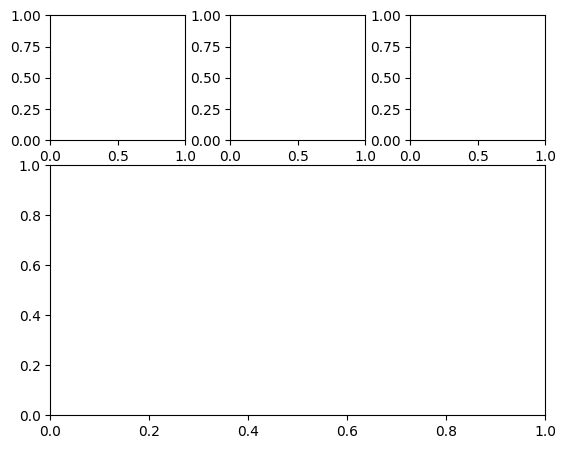

In [62]:
accepted_plot.summary_plot(choice(accepted_alerts))